# Scraper
A matplotlib-based tool for interactive visual element selection in Jupyter Lab environments. The Scraper enables precise definition of visual elements for GUI automation by allowing users to select click points and areas directly from screenshots, generating Scope objects for use in automation workflows.

## Core Components
The Scraper operates in three layers for complete visual element definition:

### Interactive Selection
Provides direct screenshot manipulation:
```python
from pyperiscope import Scraper
import pyautogui

# Initialize with current screenshot
scraper = Scraper(pyautogui.screenshot())

# Or with saved image
scraper = Scraper(Image.open('screenshot.png'))
```

### Position Management
Enables programmatic control of selections:
```python
# Get coordinates after interactive selection
click_point = scraper.get_click()  # (x, y) or None
box_area = scraper.get_box()      # (x, y, width, height) or None

# Set positions programmatically
scraper.set_positions(
    click_pos=(100, 200),      # Click point
    box_dims=(300, 400, 50, 75) # Area box
)

# Reset selections
scraper.clear_all()
```

### Scope Generation
Creates automation-ready Scope objects:
```python
# Generate Scope from selections
step = scraper.get_scope()

# Verify selections
step.find()  # Test detection
step.save_string()  # Generate settings string for automation
```

## Interactive Usage
The tool provides visual feedback and interaction methods:

Mouse Controls:
- Quick click (< 3px movement): Place/update click point
- Click and drag: Define/update box area
- Matplotlib toolbar: Access zoom/pan tools

Visual Indicators:
- Red dot: Selected click point
- Red outline: Selected area box
- Red squares: Box corner markers

## Integration with Automation
Typical workflow for creating automation steps:

```python
from pyperiscope import Scraper, Scope
import pyautogui

# 1. Capture and select
scraper = Scraper(pyautogui.screenshot())
# Use interactive tools to select elements

# 2. Generate Scope
step = scraper.get_scope()

# 3. Test detection
step.find(tries=3, confidence=0.85)

# 4. Generate automation code
scope_string = step.save_string() # will convert the cell into base64 string and object deffinition
```

## Technical Details
The Scraper provides:
- Single point and box collection (updates replace previous selections)
- Integer pixel coordinate system
- Independent point and box states
- Compatibility with matplotlib navigation tools
- Real-time visual feedback
- Direct integration with Scope object generation

## Best Practices
- Keep matplotlib window open during interaction
- Use zoom for precise selection
- Test generated Scope objects immediately
- Save successful configurations for reuse
- Use with Pilot and Binoculars for complete automation workflow

The Scraper serves as the bridge between visual element identification and automation execution, providing the foundation for creating robust GUI automation steps.

# Image Click and Box Scraper from screenshot
[layer1](http://localhost:8888/lab/tree/Documents/git2/Pyperiscope/src/pyperiscope/scraper/layer1.py)

A simple matplotlib-based tool for collecting a single click point and drawing a single rectangular box on an image. This tool allows interactive placement and updating of both markers independently, while maintaining compatibility with matplotlib's built-in navigation tools, used for quick editing the ```Scope``` object editing in jupyter lab.

## Core Concept

- Place and update a single click point on the image
- Draw and update a single rectangular box by click-and-drag
- Visual feedback with red corner markers for the box
- Point and box persist independently - updating one doesn't affect the other
- Compatible with matplotlib's zoom and pan tools
- Clear all markers with a single method call

## Basic Usage

```python
from PIL import Image
from pypersicoe import Scraper

# Load your image
image = Image.open('your_image.png')

# Create collector instance
scraper = Scraper(image)

# Clear all markers if needed
scraper.clear_all()
```

## Interaction Guide

- **Click Point**: Quick click (less than 3 pixels movement) places or updates the point
- **Box**: Click and drag to draw or update the box
- **Visual Feedback**:
  - Point shown as red dot
  - Box shown with red outline
  - Red squares mark the corners of the box
- **Navigation**:
  - Use matplotlib's toolbar for zoom/pan operations
  - Point/box drawing is disabled while using navigation tools

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib
matplotlib.use('widget')

class Scraper:
    def __init__(self, pil_image: Image.Image):
        # Single point and box storage
        self.point = None
        self.box = None
        self.start_point = None
        
        # Setup display
        img_array = np.array(pil_image)
        self.fig, self.ax = plt.subplots(figsize=(10,10))
        self.fig.tight_layout(pad=0)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        
        # Show image and initialize point marker
        self.ax.imshow(img_array, extent=(0, img_array.shape[1], img_array.shape[0], 0))
        self.dot, = self.ax.plot([], [], 'ro')
        self.box_rect = None
        self.corner_markers = []
        
        def draw_corners(x, y, w, h):
            # Clear old markers
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers.clear()
            
            # Draw new corner markers
            corners = [(x,y), (x+w,y), (x,y+h), (x+w,y+h)]
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        def on_press(event):
            if event.inaxes and event.button == 1 and self.fig.canvas.toolbar.mode == '':
                self.start_point = (event.xdata, event.ydata)
                # Start drawing new box
                if self.box_rect:
                    self.box_rect.set_width(0)
                    self.box_rect.set_height(0)
                else:
                    self.box_rect = Rectangle(self.start_point, 0, 0, fill=False, 
                                           color='red', linewidth=2)
                    self.ax.add_patch(self.box_rect)
        
        def on_motion(event):
            if event.inaxes and self.start_point and self.fig.canvas.toolbar.mode == '':
                width = event.xdata - self.start_point[0]
                height = event.ydata - self.start_point[1]
                # Update box size while dragging
                self.box_rect.set_xy(self.start_point)
                self.box_rect.set_width(width)
                self.box_rect.set_height(height)
                draw_corners(self.start_point[0], self.start_point[1], width, height)
                self.fig.canvas.draw_idle()
        
        def on_release(event):
            if event.inaxes and event.button == 1 and self.start_point and self.fig.canvas.toolbar.mode == '':
                # Check if it's a click (small movement) or box (drag)
                if abs(event.xdata - self.start_point[0]) < 3 and abs(event.ydata - self.start_point[1]) < 3:
                    # Update point only
                    self.point = self.start_point
                    self.dot.set_data([self.point[0]], [self.point[1]])
                    # Restore box if it exists
                    if self.box:
                        self.box_rect.set_xy((self.box[0], self.box[1]))
                        self.box_rect.set_width(self.box[2])
                        self.box_rect.set_height(self.box[3])
                else:
                    # Update box
                    self.box = (self.start_point[0], self.start_point[1],
                              event.xdata - self.start_point[0],
                              event.ydata - self.start_point[1])
                    draw_corners(*self.box)
                
                self.start_point = None
                self.fig.canvas.draw_idle()
        
        # Connect events
        self.fig.canvas.mpl_connect('button_press_event', on_press)
        self.fig.canvas.mpl_connect('motion_notify_event', on_motion)
        self.fig.canvas.mpl_connect('button_release_event', on_release)
        plt.show()
    
    def clear_all(self):
        self.point = None
        self.box = None
        self.dot.set_data([], [])
        if self.box_rect:
            self.box_rect.set_width(0)
            self.box_rect.set_height(0)
        for marker in self.corner_markers:
            marker.remove()
        self.corner_markers.clear()
        self.fig.canvas.draw_idle()

# Get and set positions
[layer2](http://localhost:8888/lab/tree/Documents/git2/Pyperiscope/src/pyperiscope/scraper/layer2.py)

functionality for in-python object manipulation

## Core Concept
- Get coordinates for both the point and box in pixel coordinates for creating a new step
- Set coordinates for both the point and box in pixel coordinates for editing existing step

## Basic Usage
```python
from PIL import Image
from pypersicope import Scraper

# Load your image
image = Image.open('your_image.png')

# Create collector instance
scraper = Scraper(image)

# Option 1: Interactive use
# After interaction, get the coordinates
point = scraper.get_click()  # Returns (x, y) or None if no point set
if point:
    print(f"Clicked at: {point}")
box = scraper.get_box()      # Returns (x, y, width, height) or None if no box set
if box:
    print(f"Box at: {box}")  # [x, y, width, height]

# Option 2: Programmatic setting
scraper.set_positions(
    click_pos=(100, 200),           # Set point at (100, 200)
    box_dims=(300, 400, 50, 75)     # Set box at (300, 400) with width 50 and height 75
)
```

## Technical Details

- The tool is designed for single point and box collection - new clicks/boxes update rather than add
- All coordinates are returned in integer pixel values
- The point and box states are independent - updating one won't affect the other
- The matplotlib window must remain open during interaction

In [2]:
class Scraper(Scraper):
    def get_click(self):
        return tuple(int(n) for n in self.point) if self.point else None
    
    def get_box(self):
        return [int(n) for n in self.box] if self.box else None

    def set_positions(self, click_pos=None, box_dims=None):
        # Update point if provided
        if click_pos is not None:
            self.point = click_pos
            self.dot.set_data([self.point[0]], [self.point[1]])
        
        # Update box if provided
        if box_dims is not None:
            self.box = box_dims
            if not self.box_rect:
                self.box_rect = Rectangle((box_dims[0], box_dims[1]), box_dims[2], box_dims[3],
                                        fill=False, color='red', linewidth=2)
                self.ax.add_patch(self.box_rect)
            else:
                self.box_rect.set_xy((box_dims[0], box_dims[1]))
                self.box_rect.set_width(box_dims[2])
                self.box_rect.set_height(box_dims[3])
            
            # Update corner markers
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers.clear()
            
            corners = [(box_dims[0], box_dims[1]),
                      (box_dims[0] + box_dims[2], box_dims[1]),
                      (box_dims[0], box_dims[1] + box_dims[3]),
                      (box_dims[0] + box_dims[2], box_dims[1] + box_dims[3])]
            
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        self.fig.canvas.draw_idle()
    

# Get Scope
[layer3](http://localhost:8888/lab/tree/Documents/git2/Pyperiscope/src/pyperiscope/scraper/layer3.py)

Generate ```Scope``` object from the current screenshot or presaved PNG image

## Usage
```python
from pyperiscope import Scope
from pyperiscope import Scraper
import pyautogui

s=Scraper(pyautogui.screenshot()) # Use current screenshot as base to mark are and click
step = s.get_scope()              # Create Scope object based oninput
step.find()                       # Find the bitmap again from desktop

# run this in sepparate cell to convert the step b64 string
step.save_string()
```

## TODO:
- [ ] Only area is required, the click will be center then 

In [3]:
from pyperiscope import Scope

class Scraper(Scraper):
    def get_scope(self):
        #Check that collector has clic position and area
        if not (self.get_click() or self.get_box()):
            print("Collector must have area and point set before scope can be made")
            return
        #Get offset of the area box
        neg_size_comp = [0,0]
        if self.get_box()[2] < 0:
            neg_size_comp[0] = self.get_box()[2]
        if self.get_box()[3] < 0:
            neg_size_comp[1] = self.get_box()[3]
        area_offset = (self.get_box()[0] - self.get_click()[0] + neg_size_comp[0], 
                       self.get_box()[1] - self.get_click()[1] + neg_size_comp[1])
           
        area_size = (abs(self.get_box()[2]),abs(self.get_box()[3]))
        return Scope(mouse_offset=self.get_click(), area_offset=area_offset, area_size=area_size)

# Testing and ideas

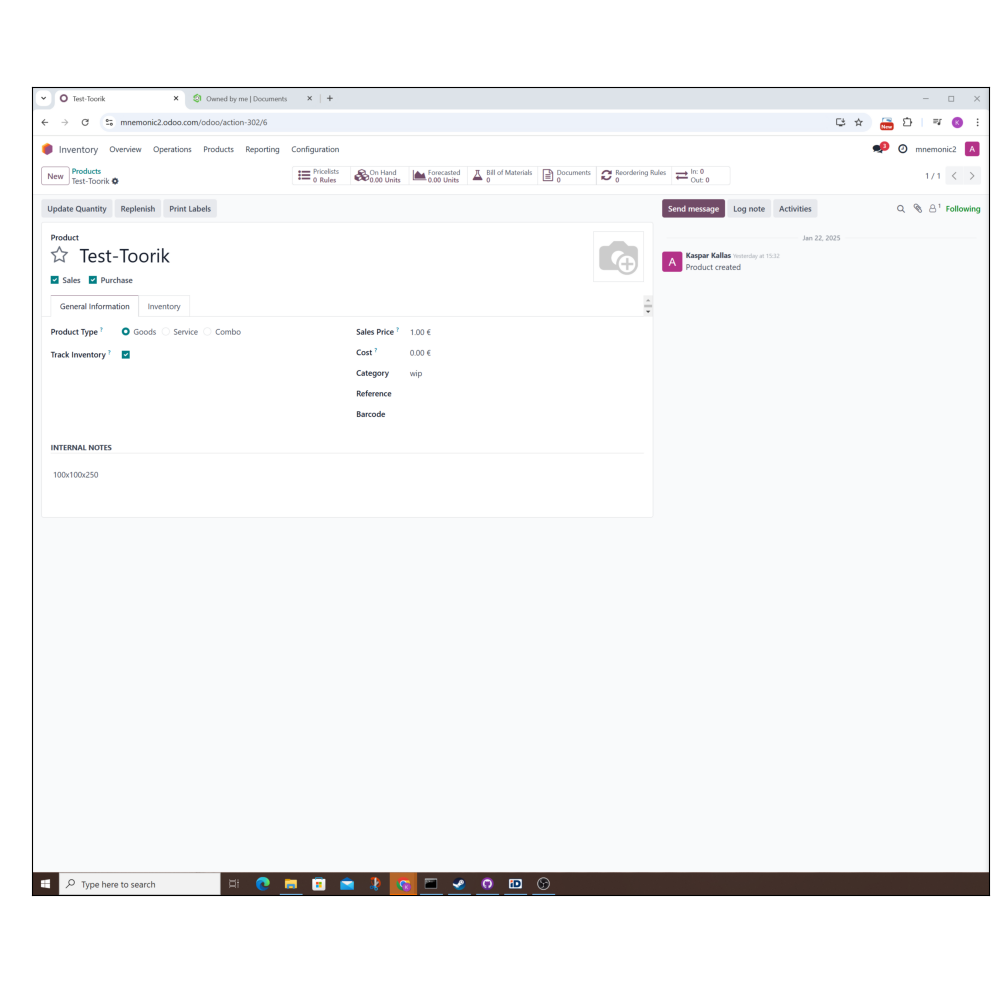

In [4]:
import pyautogui
screenshot = pyautogui.screenshot()
collector = Scraper(screenshot.crop((0,0,screenshot.size[0]/2, screenshot.size[1])))

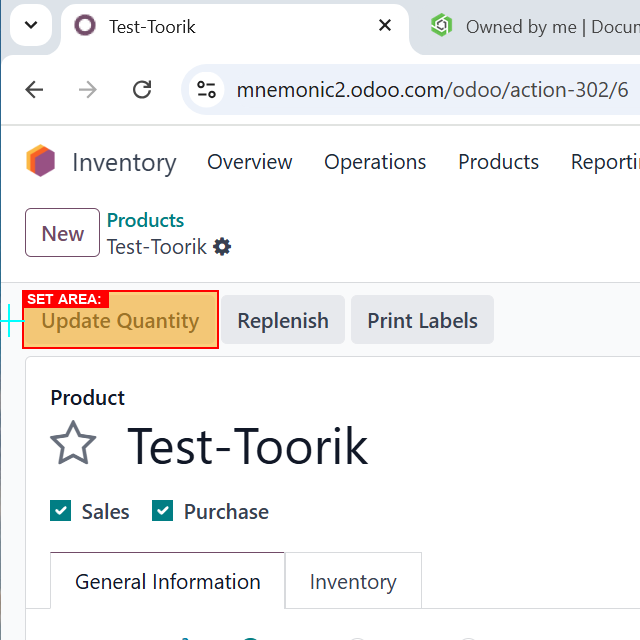

In [5]:
testx = collector.get_scope()
testx.render_preview()

In [ ]:
testx.find(tries=5)

In [ ]:
# testx.save_string()

In [8]:
# comment: Automated step generated with pyPeriscope V2 
payload = '''gASV1BAAAAAAAAB9lCiMBGFyZWGUWLQQAABpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBTVFBQUFBNENBSUFBQUF0bE1CZUFBQU1UVWxFUVZSNG5PMmRmMUFUWnhySHZ5RXNNRm1KWU9RaUE2SXA3VFIyQnM1TGppTlNMVDk2Rkl2dGliWXkzbUFkdkFyMVJCMlJhckVlVGsrdWxkRWlWc1VxOUViMHlrd1B2U0xUUW90TXF4d1drNkZKTFprcGFUVVhMa1FqUlUwbXVCbGdFN2svQ0NSQUFDRTVVUHQrL3NydSsrUjUzMzN6M2VkOTl0bWRMS2UzandXQjRBMThabm9BaE1jSElpYUMxeUJpSW5nTklpYUMxL0FkdmF1bnA2KzN0L2QrUC9yNys2ZC9RSVNISEE2SDQ4T0J2NzkvUUlEZnlDYlhxem43L2Z2M3VwbitmdHduTWlLTWl3K0h3K0ZnVmlETjlYRXVic09XdVh2ZGpQMStQMUVTWVVMdTkvZmI3L2ZmNjJaY2R6ckYxTlBUUjFSRW1CVDkvZWpwNlJ2YWRJcXB0N2VYeENUQ3BMamYzOS9iMnp1MDZlUFNNQlBESVR6aXVNckdLU1p5N1VhWUFxNnlJWFVtZ3RjZ1lpSjREU0ltZ3RjZ1lpSjREU0ltZ3RjZ1lpSjREU0ltZ3RjZ1lpSjREU0ltZ3RjZ1lpSjRqVWRDVE1hYW5SdlQxbTVNTzZLYTZaRTg5Tmk3NUo4Y0x6bFJyMkVtdHZVNmJwNjBuQVF0NVduRkNpQzI0Sk1zNllNM1BZcllXWVBpODQ5cm05UjZDOE1DWE4vZ2VRdWVXNUdSSGg5QmMyZDZiSzU4Zjc3b3ZBcFE2Y01rSlMrSFRIUG5qMFJrbWdLc1FWNWIrazcrM3MrTVhuRFcxVlNTOCtjdFIycmxXZ3N6OEZ5cTNXYTZvYTBwMjVlUmM3eXh5d3M5VEFtTHJxNjZhTSsyc2hhWGZVOUxrNE1BS2lKaGNjaDRadjhmUEl0TUR5KzNsZitxYnVpQUtOcGpUNHlxNU8zVGpkMEFmTU1UVm1Vdlh6SS9DT2pwK3ZaOFJka2xJMnRXbGJ4ZFB1dHdscFQydUtOSmMvMzhtVm81RU8rNmo1YmtuUGdvWjBLei93K1BhMlR5RnF6eTd4V04zUUI0OFhtSGptMUtpVjdJRHc3aUI4K0xUTjVVV0pFWEd3eWdXM0hzRTgxTWovT2hZUG9pay9MSXhzSm1ZUDZxazBXLzA1Vi9lUFFiUGNPQ0NveUkrMlBtbHFRSXlzV1N2YVU0ZGJTeVFXdGw0VXRIeXJadVRScmxqTzFzdVhDdVZ0NnNOUTVrTU9GUExWdVhreUVMQVlET1R3dmVxSEtzYnJxcWdyUXFERXZkR0cxZGVlWFpxM3BURDBEeHhOSVZtWmtwNHFBeEJtMitYTk5zQlVBbmJjNk40WTFvcEdNeXQ4U3BDNXV0cHEvcjVSbGlXY0JRcGhpNm9iaHdaZGlnM2VqMDBheHYrTEw2cTB0dEdyTU5BQlVZRWJjcUl6czFjakM2cVVyV0htOEVST21GQitMMGpxbmcrb1pIdmJ4bDZ3b3g3VEtaQUlERzRvMk5BT2F2T25sd2hmQkdiVzVldFE2SXovc29OMllNczAzTTNqMFhPZ0Zaem9mNXk1d1R6elo5c0taVURXNXN3WmtzNlpRU3dlbVBURGZQN2RsZGRFbmZ4L1VGd0hickc4djI3ZnJVbWRrd0xlWFplZVYxV2lzTFVBRmd0SmVMOHQ0L2YzZTRqeHNYaW9xckd6UkcwSHloZ0VmWmJRYk54YUx0SHpRT1hNTHdaZ3NGZkVkZUhNQVhDdmhDQWM4eFp4MFhDN2Z2TDVQclRlQUxCWHdhVm8zOGJQN09jdVVZMXo3czFkWldBT0MvK0x6WVhUc2wvWDBzRGNDdVZ2NHdpU2xRbnRsWGVsNnRZZnlFQW41d0FOaHVmZU9aL1RzcTlTTjcxMysrSzYrOFR0L254d1hzTnNQVjZ2eURGMDBESGZPZEIwVUY4b1VDdmpCb3BOYkhOSXVVTFFzQkFQbDNhdGZlbEZmVUFPajRaVk5URW1ZZ1orcFFOQ3g4b2VoRXVqZ0lZTHNhU2dwTFZWWmRWVVZkL081VUFXRFhWSllwVEhaZzRRdEYrUU0yRnZtSGZ5bHFIdUhGTnlJaEsvLzFXT0hBUEptYmluSk95KzNxOC9YRytOV2h3dVZ2bmx4dXJObFpjS29Eb2ovc0xGa2RPdmd0WTgyUlNtVTNSS3YzSGtpUG9BRFlqVFY3Q2s2MUt3NVZMcXZNZGlPWHpwOXZBd0FXTFlvYzQzRG16UDBWb0FPdXR4c2hDUjNEYUJSQjRnMTdzMWMrd3djQXNKcUtndnd2YjNmVzFTdlhEZ3NKQnJsYWxyMy9RRklJQld0cjJiNjlYOStHcHI2MlBYSGRRa1JuSGpxWjZRaGdjZG1IY21QYzl6T1cyWW9YSTgrZDBVS2hWTm9samg3dDZpdmZBK0RGTDNWNzJqd1EweCtaeERrRjZZNWxoUXBKemxrakJRQ3R2TVVDQUtxbXVtNEFvUnUyRHRud1pUbWJVMGVrdDJFcHVac0dsUVFnYUZsQ0RBRG9ET05ldTZucnF6b0F3UXZiMGdkWFZXN295alFKQUVhaGRKdjFkTjZhNkdKd1hrakVCQlp1a0s1L2MxQkpBQ2p4ODdIaEFPeDZ3NjNoZHBLTXZLUVFDZ0I0MGVrcDBRQnd1MnVFelpRSWpwV0lBZGpWeWg4SGQ2bVVqWFlnSkRINW1hbTduZmJJTkg5UnRLc3k2Q2VqNTBQWmdXNHJBL0FOT2owQWhFbWtZUzQyWEhGMEZPcmt3LzMwR0Z1YlZjcWYvcXU3ZHIzVFl1M3NucmhuUTV1V0FYRG5RdTdhQ3lQYkdLdmJoWTZtZVlCMVBLZTN1aHlMRXpXcG1XUk4xOXF1S0ZXNmRuMXJoL21lMmVLMmQ5R1RMcWxrME94Z0FJRCtwaEY0NEJBNEZvS2tOTW5aSXBXMThZb20reGt4QU9VVkJRQlJva3prZ1ZldmlJbGw3WUEzYW5lT1NPRGpSdzNmVHcwUG9FeEwrWmJEQ3BNZGdDOHQ0TTJQbEFsdlhHNmRxTjdqY0U1SHlHSWlBa2MyTHBqajdpdkNzRkJBQzdTMWFTRjF1OUoxR1g4R0FONml5QWV1RU5xTk5Ydi9la3ByQXdaU3VwRGZTb0srYmRGUGI4bWFraTZKZ2tyTnFGcDFyNHRGZHRXL0ZRQWlrK005a3FsbllxSjVOTURnK3ZWMnlJYlB0U1BHMEx5SjZpOXN0OHVaUDBZa3NOeDFUY0R0bXNvVENwTWRvdFY3RDd3U1FYRUJRSGxrWWpITkVmQUJDNEtpMW0xYUZUNkJyWVBncUdnUnREcFl2cnFrV1JjNU9wbGdsUmRWREFCdWxQVHBCL01JbU9vclRtbHRDSXpOTDhxVUNTZ0F1RkdiMjZMWFBhZ0Q3MERGcGFSV3FPdnV5TC9ScG92dUtodnRnRmkyUk9DUlQ4OXlwaWNpb2dEQThzVm5xbUVubGwxVDEyQUVnS2VmSEhrKzMrM3F0THRzdGl1YjdnRGdMUktId2hFSmdJNVc1UjBYRytaNzVUV1h6VnZhTmdaQWFNS3pEaVVCUmtPSCt3R3lOdWZuOExBRkFIQkQwM3JIdmJFYndoTFRGZ09BcWVGNFNjdElsVE10RmNlYXJRQ0VxU21PTkhiT2JDRUFNTjA5VGpQZFQyMnUzL3JQZFMwQVJFa2RTZ0p3ODZaSFNySlBiT0xHakN0T1R1SURscVlXZmV0M2FnQ3k1NWNHZXpJTVQ4VVVJRXVPNHdGZzVNZmZLbTNTM2JLWXpKYk9hMDFsdXc3WGRRUGdwYjRVTzJMQkFuTzVwRlRGREJ5WVdmUHhpZHBPT1BPKzRCaUpHQUMwWlFlcmRRTy9CNnV2S3o0cmR6TmZ4cllmTFFNV2hxcnlVeVBGNUR1dzdCclVyVVBhcFdReUdSZUF0cXl3VW1rZU5HUXRyWisrLy9HWWQ1QjU4YSt0RVhFQldCdUxkMnc1NFRoR1U3dW03a1JCWnJIQ0JDQW9NWGZ0WUJZZXRrREVCV0Q1NHV6RlRoWUFtQitxanRSWjNEaSsxcVladUROalZwV1VLY2JxZmx4OC9iZ0E4SzJ5ZGR4L2toelRUUFRzTWlIUWViV3FSbUVGTnlvaFp1UnZOZWtCZWZaMVN2cDZadklQeHh2TU1EU2R6bTBhMWlaSzM1MDkrdEpBRUJHa1BwNngzamM0RUNhekRRQzRjMS9kdHNxUjl3bFN0cVFydGxUcDBWNmJtMWxMVWI0c2E4UEMyUGd3UmVPTlFROWhVZEtRYWwwWDVHVTdNcXI0ZmowV0V4VWJINlZ2ZEMyYUlDUjY4VnkwMzhhMXMyK3NyNlo5cER2K2tTVU5pTjI2dmZYSFlvWHAxc1hDVFJmcElQNHNydTN1SFNzTHhPZU5mWWhoS1NWRmZvWHZWaXJOTnNPbDA3bVhocmNHUk9VWFo0aUg4c1dBMkxTa1NubURsYmxhK2Naci82UURiRXdQTHo1T3JHdDJYaXhHL3lZS3pXcDBYY3ovazBMSXg5MDcxdkE0U1hpenlqRFJYSTlpa2ZUWGFGQ0JhVHF5UnU1TGg3MThxR2lGY0ZKbUM1OWYrVlJ0MlRXTkVxQ1RVbVFCa3g3QkNEd3VEZENTbktQN0M5SWw0cUJCWFZLOGNIRml6cnVIWEFvOEx2Q2tlZTl0VGwzb2Q4OXNBM3pweUtYNXhZWHJubksyaDYvZWZYTGJVbkdnTHdBV2Z1S0VySk9GTHoweGJKZ1I2d3EzdlNxZVN3R00yZXEzTURIL3Zhem5SbVhVb2pWNStRbWhOQmV3Mi9vQ0hJVTdPaWFyN0hEV1N2RmNtZ3ZHYk9rMDk4MEtpMXladlRkYk11NHh6azhzS0QxVWtwMFlIVFpZL0tSNHdvSGo3VkdmTEs0M3VKenk0c3lDL09XUlFncUFyWStLU04xZWtMdGt0cXN6YXRubVk5a1NVUURBV2p1WjJYSHJkLy90bFFWVGlnbVVMR2YzaHNWektRQ3NEVHczUmN1SnpQaExsZ3lrSVI2Vmw0Wncvai9UWFpPN2FPdzluTGRURHJvOWdSNDlERisrWDFDaE1RRUlrdVM4azVVOHo5TmxZdm94MWUzZmNFYUxrQlVsUjFkTnVTZ3dKOWhSTXlNM2VxZE8rUEkzaisxS0RPY0NabFZwM2xzbGwyYnNZWlNwb3EvOVFndEErS3pVay9MU0VJL3JJeWpUQkMzSk9GYVpNZE9qbUJxc29hcmlYQmRBeDJhblRhR003d1lpcGw4Z2pydDFBQUJlL0tZTXFjZXA5d0JFVEw5QWZQMjRnQjMwdktqMFRWa3J4V05sN3BObStoSnd3dU1LU2NBSjNvZUlpZUExaUpnSVhvT0lpZUExbkdMaWNEZ3pPQTdDSTRxcmJGemVWVUMwUkpnOHJySnhpc25mMzkrSEJDZkNaUERoY1B6OS9aMmJRNThDQXZ5SWxnaVRnc09CNjd1ZGhpWGdzd0pwcmcrSHhDZkNoUGh3T0Z3ZnpxekFZVTlsYzBhLzhKbThiNDR3RGcvNnZqa0N3Uk5JblluZ05mNEhPTFRLMXFXemlHTUFBQUFBU1VWT1JLNUNZSUk9lIwNY2xlYW5fcHJldmlld5RYNBsBAGlWQk9SdzBLR2dvQUFBQU5TVWhFVWdBQUFvQUFBQUtBQ0FJQUFBQ0RyMTUwQUFEVUxrbEVRVlI0bk96ZGVWeU0rUjhBOE0venpOV2hkRWVGSWlwa0tVY2lLa2M1dGl3aFY4czZGNXNyMTdwK2ptekkxV0lkYThYU3NtSnBIVG1MU0tpV2NoUlJkS2ttcFpxcE9aL2ZIMU5qcXFtbVRFMzR2Ri83MnBlZTUvczh6M2VlNTVuNVBOL3pJYnBNM3hyMnYrOEJJWVFRUWsySVZIVUdFRUlJb2E4UkJtQ0VFRUpJQlVnQ0NGWG5BU0dFRVBycWtGZ0VSZ2doaEpvZVNZbFZuUVdFRUVMbzYwTVhVMVREdGlSSlVrT05xYzVpTWhrMEdvMmtrU1JCMUYyYlRWR1VTQ1FXaWNWOGdaQmJ4aS9sQ2NSaUpUOENWR1NNd1dEUTZRcG5EQ0hVM0VoK0xvUmlNWjh2TE9NTHVHVThzYmlCdjFjMWsvdzRpQ2tnQ0lvQ1Fyb0VvVVpIYjhETlJoS0Via3RON1JZYURiaFBDWUtnMDJsMG9MR1lEQzFOZFFxZ3FKaGJVTXhSeXZkS2tyR1dMVFErZlZjSUlaV1QvbHlvTVJuYW9BNEFoY1hjd2lKT2c0c05sWFlPUUZGQUVSUWhPVlRGL3hCcU1uU0NyTjg5cDZXcHBxZmRna1pUVHRzeEFkQlNTNk9GaGxyK2g1SVNidG1uN0VwVG5XV2dxMFhEUm0yRXZsdzZXaHBhR21wNWhjWGNVdDRuN1lnZ0tERUYyQWNWcVJSWnJ5ZEpIUzBOUTExdFpVVmZLUnFOTk5MVC9wU1NxNjYycHJGK1M0eStDSDN4YURTeWxYNUxIYTFQcWVnaW9MeTJHU0ZWb29QQ2xUbUdldHBhR21xTmx4VjluUlowT3BsZldGTGZEUTEwdExSYnFEZEdsaEJDelpOZXl4WTBXa04rTGlnS0NFTHBEY2tJTlFTcFlMTkh5eFlhalJwOXBVZXBiem00cFpZR1JsK0V2a0lOK0xrQUF0dDVVVE5DQWxGM3RhMDZpNm12MDZJSmNnTUEram90MU5XWUNpWldWMlBxdDJ5aWpDR0VtaHQ5blJicUxFVi9Mb0FBd0tJdmFrN3FqcjRFUVJqcGFUZEJWcVNNZExVVkdUalU5QmxEQ0RVM1Jub0svVndBRUlCekhxQm1oaVRxYWdOdTJVSmQ2YjJ1YWtlamtkcWFkZGNxdDJ5aGdiMnVFUHJLMFdoa1MwVWFvUWdjMzR1YW5icDdRYXRrV0swaVhSd1YrdFloaEw1MEN2MUcxWCttQVlxaXhKUUlBRVJpMGRNUER3NW1yTG1XZDdLSVh3Q0FWZGxJT2Vyb0JjMWlNcHE0K0N0Qm81RXNKb1BIRjlTVW9NRVplNStUejg3S3pjdks1WldXQ1FRQ0FnaVdPa3VqaFNaVGpXbGsxc3JBMUlqQllIeEN4aEZDVFkxR0kxbE1Pbzh2ckNrQkFVRFZwL2hMVVJRRkZFbVFCTkRlY2xMaWlxKzlMSHNzRW9vK2lOalpvdGVkV1E3ZHRRYlE2WFFLS0lxaVNBVzYwU0FrRjczMjFacnFyS2JKaDl4RDF4S0FOUlh1cUFVQVlyRVlLRW9vRUluRjRveVV0ODhlUG41NlA3R3NwSlRGWkJFRXdlV1ZHcG9ZYWVscWRldG5wOTVDWFVPckJaMU9JM0FDUzRRK0h4cHFyRm9DTUFXVTRoWFFZa3BNRWlRQlJESC93NzNDeTBtQ0IzeXFsT0lESFpqQ01zSExza1MrTHJlN1ZnOTFybkVwd1NjSVFneGlBZ2ljMGdNMVFCMGxZRFdteW9xRHRSK2F4VkkwWXhSRmtTUlprUHYrMWRPWFYwNzh5eTNpQ0FSQ0FBcG9CRS9JQndDU1J1Ym41TC9QemM5Nm5YbjdmRVQva2M3VzlwMk4yN1NtS0Fwak1FS2ZoZHAvTGhRTXZ4UkZpVUZNSTJobHd0TG5KZmZ2bDF3cklkN3pTd1JNa2tXQXFFaFlxRW5YOGpTZFBLYlRGQnBCdnl1NC9pVDNhVS9Od2Jvc1F3Q2dRRXpnNjlWUlBkVlJBbFpKL2JNaWg2WXJuREd4U0pTYm1ac2MvelRsOFl1U0Q4WDhNajVGVVFCQUVBU05SZ01Ba1Vna1dTSVNpc1JpOGJQN2lXS3htS1RSOUkwTkNCb0dZSVErQTdYL1hDajROU1lJZ2dhMGxKS0VXTzcxREg2S29FeElFOUVZTkNaWHdCRUkrVDJOK250MG1OQkJ4eXE1NE1tRjFGT1A4dTVydG16eHN2UlJkL1dCUGJTZDFlazRCVDJxTjNydDQ5SlYyTTI0OWtQVGFUUkZka0pSbEVnb2ZQM2s1YU03OGZscE9RS2hnQ0FKa3FBUkJEQ1lES1lhRXdCNFpYd2hYMEJSUUZGaUFWK1E5ZUt0R01RdDlYVjFESFFJa29HRllJU2F2enArRUNpRmFvamY4M0x2Rm9hbDhCTUVGQjk0TkRvd0JBU2ZXOFl4MVdqbi9jMTBleU5IQUhpUUUvWHI0NDFjQWRkWXd3UzQ4SUY0SHcwWGtyaHhmYldIV1d2WjQ4OEZxcGM2NGl0WnoxYzFLRkh0aDFid1JoZUpSRnhPV2VRLzE5Njl5ZVFLU2dtS1lLbXJtVnEybWJCb3F1LzI1VDhmMnZUem9VMStRYXVtcjUxcjFxRU5TMDJOQUlJcktFdC8rZWJ5bitkRkFqRituYXJMenM0Mk56Y1BDd3RUZFViUVp5a3pNM1BzMkxFcEtTblZWNldrcEl3ZE81Yk5aamRndDNYOFVpbjJQWDVVY0NkVlBWRlFKaEtYZ3BnU2Z1QzlwNHZwWXpyNEJBdzQwRjNINGM2ZE82bHBxVjExN0JaMFcyZXIxN09nTEw5VXpDWEVORkVKOVo3SXVsZDJnU3NvYWtET202ZTVNM3d1WFRndmQ5WGFsVXRPSEQzY3hQbXBsOTNiQTNadkQxQjFMaFJTUnduNGM1ZWIvdTdWa3hjbEgwb0VmQUVBcUd0cDJQVHFhbVhYMmF4REcyMDlIUWFUQVFCYXV0b2tqVGJBd3pVcC90bnpoMDg0SlNVQ3ZvQlR4SG54M3pPemptMzFqQTBVT2REcTFhdVBIejh1ZDlXOWUvZGF0MjZ0eEEvVjlFZVVIS3VSUGdqNnFpeGV2UGpodzRmZTN0NG5UNTYwdExTVUxrOUpTZkgyOW1hejJiNit2aUVoSVNySkcwblFCQ1ZDZ2dJS3hFS1JvTC9KRUkvMjNtWXR6Qk1lUHo3eno1bUhEMko3OXV5NWR2WGFucTM2MmJWeUNFLzlKL3pOV1k2b21BNE1FUS9FRkRUczlRNjd0d2NrUDM4bS9mUDc2YlA3OU8ybnZNK0VLcmwvNys3Und3ZXFMRnk4YkpWbEp5dVY1S2NlTDJPbzA4T0hEL2Z0MjdkLy8zNFdxMnJmYVI2UE4yZk9uTGx6NS9icTFVdFpoMU5FYnNhN3gzZmlCWHdCSmFZWVRJYXVzYjV0Mys1ZCszd2ptNGJCWk9vWU1Ic003TVZrTVhQZVp2UEt5Z1I4Z1lEUGZ4YWJxTlpDVGNFQXZHblRwazJiTmtuK2JXNXV2bno1OGg5Ly9MSEIyWTZMaXhzelprenRBVSs1UjBTb2FRUUdCazZZTUNFakkyUENoQWwvL2ZXWEpBYW5wS1JNbURDQnpXYWJtWmx0MmJKRmRibWpDSklBRWtwNVhCK3J1VVBhamNySnp0bDlaSGYwbldnNm5UNWh3b1FoUTRaY3ZYNzF2MGYvRFhjZk50ek82eHZEM3Y0UC9QaGlIbzJnVWZVYjZBUUFrUElpZWNkV2Z5dWJ6dnQrUHlaWjhqNmZ2WHI1NHBqb3FBVkxWaWo5c3lHcFRWdDI2T21YLzdCTHJnSUFTSzlDVXlLVkZZQ1RrNU9uVEprU0VSRXhiZG8wSHEvU3F6ckx5c3FtVFpzV0VSSGg0K09Ubkp5c2xNTXBTTURqRjc0dklFbUNBSUtpcU9GVFBNMDZ0Qk9KUkdKeHBWbnB4R0t4U0NReWJtc3lZTlFnaXFJSUlBZ0NFbUllczdNYVVodjI2VEl6TTFWeTNKcHMyclFwTFMwTmk3L28wN1ZwMCthdnYvNHlNelBMeTh1Yk1HRkNTa3FLSlBybTVlV1ptWm45OWRkZmJkcTBVVlhlQ0NDQkFvb1NBd1VkOUt5TEM0dCsyZXAvNys0OWUzdjcvLzN2ZjFPbVROSFgxMy8zN2wxeVV0SzI3ZHZ1MzQ4eGJkR1dRVENGWWlGUTlZNis3L1BaTzdiNmp4dzFSamJXNnVrYjdQdjlXRDQ3cjVuWDhYNUpMRHRaN2Z2OW1JR2hvVXBxclpYV3g2cERodzVPVGs0QUVCMGRMUnVEZVR6ZUR6LzhFQjBkRFFEOSsvZnYwS0dEc282b0NHNEpsMTlTUmxFVVFSSU1GdFBReEVoVFM1TkdvNUdWZTNpUkpFbWowYlIwdEV6YnQyR3dtQVJKVUJRbDVndEx1YVZObVZ1RXZnYVNHR3hvYUppWGx6ZHUzTGl4WThjMmgrZ0xBSHhSbVVBc29BR05JQWdoeFJjSWhPL2U1ZlRwMDhmUHo2OWp4NDRpa1lnZ2lCOSsrR0hxMUdtbHBUd2VUd0FnRmxOaUdrbFNBRlE5WjhlNmZPRzhnYUhoOEpHZTFWZU44Qmg5TityVyszelZQUDEvblh5bXpVcCsvaXpsUlpPV0QwR0piY0IwT3YzQWdRUHo1OCsvZE9tU0pBWUhCd2RURkRWdDJqUko5QjArZlBpZVBYdklwdTFXWGNvdHBRU1VXQXdrU1RKWnJKWUdPclNhZTB1eU5OUU0xWXlZTENhL2pDY1dBNHRHRXdwcW5BbWtYaVJWeXBKL0R4Z3c0Tml4ajNVZFBqNCt0Mi9mbHZ4YlVvM3M1T1NVbnA0T0FIMzc5cFV1ck84UnM3T3pKWnRMQkFVRmVYaDR5Q2FRYlVKdTA2Wk5WRlNVZEpXVGs5UEFnUU5OVFUyM2JOa2lXZlhiYjc5dDJiSWxMUzJ0bG84bWR5MUNja2xpOExoeDQ5Ni9mdzhBdXJxNktvKytBR0N1WlpuRy95LzlRd1pCVVdLeFdFZW5aWWNPSFNUekFRZ0VBanFkTHFrODA5TFNJZ2pKTUEyU0lBZ3hBSjBnNmp2VjlOMm9XeU5IalpHN3FrL2Zma2NQSDNqNUlybGpKMWk5ZkxGc3EvQ0pvNGZ2UnQyU1ZwWktxazhYTDF1bHA2OHZTWm1mejc1dzdveGtyV3hGSzhqVXRRS0FsVTNuS3JYY3NrM1JpNWV0cWpQL2N2ZDI2Y0w1QytmT1ZEbXVwR1JadlZMOXhOSER5VW5QZktiTmt1NUgwaFlyelltQm9lR0dYN2JMYmlMWnYrVGZJMGVOa2Z2NDBqQ1NOdUFYTDVLa2pjR1M1Z0JwZ3VwdDg3S1prV1JWZWpta082bXlaTzNLSlZiV25YWDFEYVFiMWpFT3VGNUlrdHk3ZCsrS0ZTdE9uVG9WSFIwOWUvWnNnVUFnaWI3ZTN0Ni8vUEpMMDNjcUpnaUNrcWxqSitxYU5LNXk0a3JiTmxoWVdKaXZyKytaTTJmczdlMEJ3TW5KeWNmSFJ4S0RuWnljTEN3c0pLRXJPenY3M0xsekFCQVZGU1hacE1HZG5pU2JTNE91SkVZK2VQQkEybVlzcWF1UWhrd2ZIeDl6YzNQWnc5MjZkV3Znd0lGMXh0VHM3T3d4WThaTW5qeFp1bWVFRk1SaXNhVGZyMll5M0tDMy9nQm5nd0dIeVY5dlpWem1pd1FVUWZrdThCWHloU0tSU0ZKeWtHUllNb1V0VWZGMlE0S2k2dHVRSnluZGR1cGtYVk1DQTBQRGxCZEpmZnIyczdMcExQbUhaSGx5MGpNQVNIbVJMQTBZQm9hR2xwMnNKRHM4ZXZqQXlGRmpKT0Y1OS9hQTFjc1hTME8xcFBPUmJDVFl2VDFBR2hUWHJseWliMkFvVFR4M2hrL3QrVTlPZXNabTU4bW1sK3h0K0VqUEMrZk94Tnk3S3cyTjcvUFp5YytmMVJUUjJYbDVGLy85UjdLZkUwY1A3OWpxYjJCb09NSmp0Q1JqYzJmNG5EaDZlTkwzMHlXSlpSOCtwTkZSaVRIWXlxWnpRVVd0ZytSMFNZT3VKSTZtdkVpU1prYnlsQ0E5QTRvM0dVZ2V2Q1FicmwyNVJNbmxVWUlnQWdJQ3hvMGJCd0FSRVJGMzd0d0JnTW1USjZzaytnSUFuY0VRVVNLU0JFb3M1dk40ZVpudmVOeXltaElMZUlJUCtZVjhIcDhTVXlRSkJKMVExMURDK3g1OGZYMlhMMTh1aWI0QXNHdlhydHUzYjhmRnhRRkFlbnE2bDVlWFpIbnIxcTJWMVl0S2NrUnBrZGZlM2o0b0tPajQ4ZVBaMmRrQThOdHZ2NlducDhzV2VZOGRPOWFtVFp1OWUvZks3cVRPbUNvcFpBOFlNQUNqTDZxdjlQVDBDUk1tRkJRVTZPcnE2dW5wdlgvL2ZzS0VDWktLSHhWNnlYM0dKd1J6YlpjdjZiSEp1RVhyM0p5OG5UdDJwcVdsU1pxb0tJcGlNQmdrU2RKSW1sQWtGSXFFNVlWZWdnQWc2bHNGcmFDT1ZqWjNvMjVKL2kycElMV3k2ZnppUlZKNWhwT2ZXMWwzbGlidTV6UlFHcENtVEowQkFQZnYzWlg4S1luTjBwS1piSTNycFF2bjJYbDVzaVhVT2t2QTFkTkw5OWJQYVdETTNkdlNWVEgzN2tvZUVXcmFsU1NmQURCc3BDY0E2QnNZU3A4MlJvNGFJM25na0h6MnUxRzNwQm5UMHpjWU9XcU10QnlwZEpMVEpjMkpaU2VyNzZmUGxyWUxYTHB3UHZuNXMwMWJka2pUU3dOem5XVGJIVVo0akZaK2hUQkJFRnUzYnAwOGViTGt6eDkrK0dIVHBrMnFlc0pWMTFBbm1IU0NJQ2d4SmVEeHMxNm5GeGNXMWRRSmkxUE15YzNNRWZENGxKZ2lDSUtwcWFhaCthbXoyMGdDN2FoUm82UkxKSkZZMHMycVRaczJ2cjYra3JoWU8zTVprdktyNGtjRUFFbm44NGNQSHdMQXZYdjNwRmRIYXVEQWdiZHUzWkw5czg0c1NhS3ZiSFU2UW9xUVJOK01qQXhEUThQVHAwLy8vZmZmaG9hR2tuN1JxbzNCY1RuUnZ5VDYzY3k0MU51b2Z5czFNelZORnAvUDM3Smx5K2JObTVPU2traVNmUFBtelpNblQ0UWlvWWFHaHE2ZW5naUVrckl2UlZDTjlMWkRTU2xaRXR0ZXZFaXlzdTdjMGNwR0d1R1Nuei9yMDdlL05MR2xUSkc2U3VVekFEakkxS0JLSW1KK1Boc0FYaVkvNytkVTZmdGU1NWdjdWVrbGUrdlR0ejg3TDAvYW1CcHo5N1pEdndFMTdjZkEwRkNhVDhrL09sclp5Q1pnNStWSi9pRXQ2MHRYU2M2TUVsdks4OW5seDZwK3VnQ2dZeWNyQUhqNUloa3F6cGpzR1ZhYzdBT1R2cjRCblZSc1NxbjYyclJwVTh1V0xRbUM4UFB6YTR6OUs4akF4TWpXb1h0ODVBTUtLSUlnYnAyN09XVDhNQU1Ub3lySkpQVkxtU2x2cnAyNlRCQUVCWlJZVE9rWTZqRS8rVjBVa2tBcjJ4d3J1endxS3NySHgwZVJ0bDdGVzFqbDlxQ1dyY3BPVFUxdDI3WnRsUVNtcHFZSzdsL0MxOWNYQURENm92cVNqYjdTWVVoLy9mV1g3TmdrVlRVR3F6TTA4c3ZZUjU0RlJXVmVHZFYreWplR1BRUDh0NXo5OTB6NHhjdnIxNjhmT0hEZ3ZYdjNldlhxTmNacmpQOEcvL2FXN1V2NFJYUTZIZmhBRW1TOUtxRWx2OTJ5TFk1VnNQUHlSbmhZQTRCbEp5c0RRME5KeXBpN3QzMm16ZExUMTc5dzdzejdmTFlrR05RZUxDVkJVZkovMlJiTlNtdlplUVlHaHZYSWZhMWtNNXp5SXBtZGwrZWdqR0hOQmZsc2RsNWU5YnJ4OS9uNURRdUUxVW5QZWI2OG9DNTdGQ1dlTVhyajlZcGF1blJwSSsxWmNRYXREVHIzNnBvWS9aOVlMQklLaGU5ejhoUHVQZUx6K0JaZExEVzFOUmxNSmdEd1NzdUszbi9JU0htYkZQL3NmVzYrVUNna1NJTEJaSFJ6N0dGazF1b1RNeUFKYkxXMDVrcGltS1RWTmpNejg5T3JjK1dHVXRsQ3RvV0ZSZlVFOVIzNEZCUVV0RzNiTm5OemMreDdoZXJGejg4dkl5UER3TUJBR24wQndOTFM4cSsvL3ZMMjlzN0l5UER6OHp0MTZwUks4aWFpaEV5Q3dXQ3lVajRrYmY5dmRkOVdMc010dkNhTW05Q3ZUNyt6NTg5ZXUzYk4zTUxjeGRXMWRhdld1V1ZaN3pnWmV1cUdZb29DQ2lnUkJVeEtSSW5yUGtZRlNWV3QzQ1pNU2IxeHg0cklhbVhkK1dYeTgvZDkrN0h6OGlUaDFzRFE4T1dMNUpRWFNWVktvalhSMXplQWFuMnlsS2hLTWRTaDN3REpSN3QvNzQ2VlRXZWxIRlJYMzZCNm55d2xrcHh6U1oyenZyd01OMUtuZEZJcC9ZeWFMVDFqQTZzZU5wcmFtZ3dtQTRBb0xlRStpWGtjOVc5RVRucDJjVUdSZ0M4UThBV0YrUVVacjk3ZURydjVKT1p4YVRFWEFCaE1Sb3VXTFd6NzlqQTBOZjdFREppWW1FQkYzVzh0UER3OEprK2VMSzBFcm05NVZKYWtpbHZTbjB0S2tnRkpxM0Rmdm4yclQ2RjE2OWF0aVJNbjF1dEFVVkZSYmRxME1UYzNiM0JXMFZkb3g0NGR2WHIxcWpJTkZnQllXbHFlUEhteWUvZnVPM2JzcUduYnhzWWsxSUJCOEtCVWk2R3RRZGVNeXI2MitjSFNrT2NIRGRyb0wvUmQrTXZtWC96WGIrN1N1Zk8xTitkWDNaMmJWSkRJSUZpU0Z5Mnh0R2hNU3AxRjFxUENiTmhJVDNaZW50enBIaVVOa05LNDFhZHYvK1RuejJMdTNaV0dXeXZyemlrdmtwS1RubG5XM0kxTGxwNitQbFJVbjFablpkMVoydFFxSVcwNXJrbVY5REV5MFFzQUhQcjJrOVJDMzQyNk5lTGI3eFRKWVozMDlRM1llWG1ORkFYZjU3TWw1MXp5cCtRcEo2YnlTWkNjUGNsbmRPZzNRTm93TDB0eW5tVUwwSElMMDdKSUVaOWZ5Mm9WaG1leFdBbUhwaWlLUnFlNVQvWnMwOUZjZzhHaWdPS1ZsYVdudkQyOFlWK2dyLy9tbVdzMnoxd1R0R1RyWHp1UFpyeEs1NVdWVVFTbHdWQnYxYzUwNEtqQm1scnFOUHFuMXMrM2J0MTYrZkxsdnI2K2txWlpDVWtqYm5aMjl1clZxNlVMSlIyUEpmOVdNR3pYWlBueTVWdTJiSkZPMXh3WEZ5ZnBsaVg1VTFMUkxkdVE3T1BqazU2ZTNvQXVZSktlWEJpRGtlSk1UVTFQbno1ZEpmcEtXRnBhbmp0MzdsT2VQbXVpNE85WWI3M0JBOGpSdWd3ajBCQ0xDYkVPUTA4RXduL2ZudnI1OW84MzMxNjBzR3FYSVh5MUlXYlJzYVI5eFlJUFRGS05BS0MzSU5YVjFUdFRUcDRHczFpTWV2VFoxTk0zK0g3NjdBdm56c2gyb0gyZno1NDd3OGZLcHJOc3liZzhIdHk5TFEyM2ZmcjJ2eHQxaTUyWDExR3hDUlFsWFphT0hqNGdPODUxN2NvbGtuOUlIZ1drMDFCSW9sSHRPMlRuZlp3cUpPVkY4b1Z6WjJTSFZPbnBHMWpaZEQ1MjVHRHQzYS9xUmRJaFhMWVdQZVZGc2xLbUs3bDA0ZnpxNVl1ckRHcVM5UENTUG9pa3ZFaVdqZENTbE5JVENCVzlvUFgwRFF3TURTK0duWlVzVk9STTBvbGFxNkJGWXJHQzd4MVNPcEc0SHZVNU5TRUlna2FqdCszVXJxamdBMG1RYjErazhubDhNU1VFQUpGUUpPUUpRT1oxaEFSQk1OV1k3YnAwc1B5bVUvdXVIV2wwdWxMNmpra0NtM1FjTUFDY09YTUdBRnEzYm4zOCtIRnBZVlIyTUk4MGJFc0NaMzFENDQ4Ly90aTdkKzh4WThaSVdtb2xSNVIyd3dhQXRMUTB5ZEFqeVo4REJneG9jRTF5V2xxYXBHdFk5YUhHQ0RVVENuNk5HWFNtdlo2THBjWTMvM0VpSDR1aUJMUXlzb1NteTlRdjRMTVBQOXNaa1hIcEhUZXpWTVRSWnVvVThZdElHZ2tFdENHdE91czZkTkR1Mm9CYzllbmJyMC9mZm10WExwRnQycFE3TDNFL3A0RjNvMjdKZHNvRmdIclY3a3BpaG5URUxjaDBkZGJUTjlpMFpjZnE1WXNsMlRBd05OejMrN0hhUnlMMWN4cW9xMjhnVFZOOWpPeUliNytUelBPbFlQWVVzV0RKaXQzYkEyUXoxdURKSTJVRHVlVHpWa2t3ZktSbnAwN1dPN2I2U3lOb2xldXk3L2Rqc3BtUlZrNXMrR1g3M0JrKzBqTzVlTmtxMlhOZUhkRjFldUQ1LzAycGFiV3BrUzZyMWpkZE41NHluaUFycjZDbXRlM05xbmFrcW9sa0hIMU94cnVrdUdkMy9yM0pMZUlJQkFKSjE4WHljUU9TbVNlQllERG9HdHFhUXllTjdOQ2xvNTZSdm1SREpYd1NoRkRqZTUyUlc5TXFTc0gzRVFLSUtSRkowQURnSGVmdC9hTHc1TEwvS0lJaStBUkJrQnhCTVl1dXhpU1lmSXBQcVlzbW1jenRvdGF2b0xTSVFXZUtLUkVCSlA1Y1NFbkcwVFplcTNQdGFwcjZveG1pVTdVV05Ia0NvYW9DTUY4b1ZNcCtKUE5wR0xZMjFISHIxNzFmajhmUi96MitHMWY4b1RnL00wK0RxVTRCeGVQeldGcHFOcjF0dS9UOHhxcUhEVWtqNlF5YVdDeHU0a203RUVLTmhGQTAvZ0pKME1TVW1LTEVyVFRiZW1yT2VsbjArRzdCSmJiNkc3RlEySUxTRW9HSTBoQnBpclZzMWZvWmlqdVZDTW9rMFZjU3M1RlVUSFNVc3JwZmZkbnFtSXFTVzhyVDFsVENaQlFOd0MzbDFaMUlNUVJCRURRYWkwYWowV2lXdGxiYXV0cDhQciswbU1zcjVWRkFNUmdNbG9hYW9ZbVJmaXRETlUwMVpSMFVJZFJNRUVROVpza2dDUklJVWt5SkNZTG9xUDFOV3cycnA4WDMvK05HdktmblVEeXFBOTIrVnd0WE04ME9NdWt4K2xaeS85N2RLdk5Vb0pyVUVZQkxlUUt4bUtyalpkZU5RQ3ltU25tMTlRNXJHRHFEYm1KaGFtS2gvRjRlQ0tGbWl5SUlFTmZ2ZGIwa1FRS0FtQkt6NkdwMnVnTTdhTmpHZmJpaHA5bnFHOTMrQkVGZ3FWY3U2ZHQyRnk5YmhjVmZSUkJkZnRnV3RyNjI5bmE5bGkxMHRENTFRcWo2S2l6bXZ2OVFVa3NDeGR1QUVVSmZnMXJhZ0FFQUpBT0dFR3BPU0tpcnMzRmhFVWNwSFpJVkp4S0xDNHM0dFNTZzBiQjFGaUZVQ2EzMlRoc0VRVFhLYk0wSU5WemRrVXhNVWJudmk1b2dLMUs1K1VYaVdzZnRxV3BrRkVLbzJhcmp1WndDRWt2QXFKa2hDUVdDV1drWnYvWUtZU1hLTHl5cHMvV1hqaVZnaEZCbGRmNHNTQWI3TjBsZUVGSUlXZnRFSEZLRnhkeGlUbWxqNTZhSVUvcWhoRnRuTWlaRG1hOHhSZ2g5QVppS0RKaWtLS3lJUnMxSFBlYUN6aXNvem0vTWNqQzdzSmhkVUt4SVNnMDFadU5sQXlIME9kSmdLZlN6UUdBcEdEVWJkRW9rVWp6MWgyS3VVQ2pTMTlGU2JpV3dVQ2pLLzFEQ1VXemdMNDBrVlRVM0NFS28yVkpqTVVpU1VHUU9lYXJpL3hpSmtXclZNUmQwZFp4U0hxZVVwNldwcHQxQ2cvWEpWY0U4Z2JDb2hGdk1LVk44RTAyTlQzMUhMMExvaTlSQ1hhMUk0Wll5QWdBSWdoSlRXQ0pHcWxMSFJCdzFLZWFVRlhQS2FDU3BvYzVrTVJoTUJwM0JvTlV4REFBQUFFUmlzVUFnNGd1RVBJR0FXOHB2d0FBbkhTM05CbVFZSWZURjA5SFdVRHdBQXdCUWt1aExBQUZVeGR0OEZaMjFFcUZQUnYrVUZ3Nkt4T0ppVGxreDFLUDgrb2xhYW1sZ0YyaUVrRngwR3ExbEN3MUZPbkpXUmdHRmNSZXBBQW1xZStOdmZaRWtvZHZrYzNJaGhENGp1dG9hSk5ZcG84K0Vvc09RbWdNanZaYjRoaUtFVUMxSWtqVFUwMVoxTGhCU3lHY1R6d3gwdFhEMEVVS29UcHJxTEFOZExWWG5BcUc2MVdNY3NBb1o2TFJRMVZzUkVVS2ZIVzFOZFgyZEZxck9CVUoxb0VOOXhnRTNQWklrV3VucnFMRnc0QzlDcUI1YXR0QmcwdWs1N3o4b01qSVlJWlVnb1JtM3FyYlFVRE16MXNmb2l4QnFBSFUxcHBteG5xYUdtcW96Z3BCOERSd0gzTmdZZEpxQnJwYTZZblBMSVlTUVhIUWF6VmhQdTFSVGpWMVFMQkEyNjlvKzlCV2lONnZwMkVpUzBGQmpxYk9ZV3ByNDBJb1FVZzUxRnJOTksvMWlUbGtwajg4dDQyR2xOR29tNkRXTkF5Wkpvb1c2bW9ZYWs4R2cwMmdrRHExRENIM1d0RFRWOE1rZU5TdHlBakNOUnVxMDBOQnVvVTVnMEVVSUlZUWFSOVczS1dpb3M0ejB0TEc4aXhCQ0NEV3FTcDJ3ZExRMDlGcmk0RG1FRUVLbzBaSFNBS3lsb1liUkZ5R0VFR29hNVFHWXlhRGpCS29JSVlSUWt5RWxvNUIwdGZFbHV3Z2hoRkRUSVFHQVJpTTExVm1xemdsQ0NDSDBGU0VCb0lVNmpvMURDQ0dFbWhTZEFBS0x2MGpwUkdLS0w2VEVZa3BNVVdJeGlLblA0clZiQ0NIVWRPZ0FGSk5aZFRRd1FnMGpGRkY4b1pndndNbitFRUtvRG5SS0xNWnBOOUNuNHd2RlhKNUlMRloxUGhCQzZET0JaVi8wcVFRaWlsc21FbUdaRnlHRTZvTU9SUE45SHpCcS9qaGxJcDRBaTcwSUlWUnZkSHpqQW1vWU1RWEZYQ0VXZkJGQ3FHSG9GT0FQS0tvM2daQXFLUlhpcllNUVFnMUdCK3cyZytxcGxDY3E1ZU50Z3hCQ240U09CV0JVTDN5aHVNN29TeU1KQnAxazBJQkJyN0dIZ1VBb0ZvaEFJQlEzV2lVMlFWRVVOckFnaEpvdE91QXZGRktZVUVTVmxJcHFTVUFTaERxTFpESHE3dG5Ib0pNTU9nQ0w1QW5FcFh5eEVnY09Fd1JRWWdBQ295OUNxRm5EWHRCSVVXSUtpa3VGTmEwbENGQmprR3BNV24zREhvdEJNdWxrR1Y5VUpoQi8rbXhaQklDWUFneTlDS0htajQ2L1ZVaEJuRkpoVFFHU0lFQlRqY2FzdWNLNWRnUUI2aXdhalVad3lrU2ZHSU1wd0RvZGhORG5nUVJzQkVZS0VJb29nVWorclVLU2hKWTZ2Y0hSVjRwSko3WFU2UTJlbHcyZkpCRkNueGNTNHk5U0JKY252K21YQUdpaFJxUFRsQlA5NkRTaWhYb0Q5NFhkK1JGQ254ZHNBRVoxNHd2RndocUt2NXJLaTc0U2RCcWhxVVpyd0laWUFrWUlmVjR3QUtPNmNjdmtGMzlaREpLcFFJZm4rbUl5Rk9wSGpSQkNuN1dtR0lhVWs1TkRVVlNyVnEwYS9VZ054ZUZ3Q0lMUTBOQlFkVWJrNEhLNVQ1OCt6Y2pJQUlCV3JWcloyTmpvNk9oSVZ1WGs1Rnk5ZWhVQXBreVowbmdaRUlnb3VVT0VDQUkwV1BLTHFrS2hNRGs1bWNsa3RtL2Zua1pyU0hGV25VWGpDNVhRS1JvaGhKb3RlbU4zR21XejJVdVhMaFVLaGR1MmJUTTFOVzNVWXpWTVNVbEpaR1FrU1pJdUxpN3E2dXFxenM1SGp4OC9QbjM2ZEh4OHZMaHk4MmI3OXUyblRadldxMWV2bkp5Y0V5ZE9RQ01IWUg0TjcxcFFyMkhFMGN1WEx5ZFBucHlUa3dNQVptWm14NDhmTnpjM3IrOUJTUUxVbWJTYUdwNlJyS3kvdlVadXpQejJ0OGoxL1ZtcXpvdU16T0RSN3Y2d0xPTHNGRE5WWitVemtSbTZaT0ZSbVBqYjl1OCszek9XY1htcDc1K0ZBNWJ2WGZnTlU5VjUrUncwN3NzWTJHejI0c1dMYzNOenRiUzBSS0ptK21NcUVvbUVRcUZRS0l5SWlHZ21NWmlpcUlNSEQvN3p6eitTUDl1MmJkdXlaY3ZTMHRLMHREU2hVUGo2OWVzMWE5YTR1N3NQSERpd0NUTERGOG9Kd0RTU1VHUEtxU1V1S1NtWk9IRmlYbDVlMTY1ZE16SXlNakl5dkwyOWI5eTRvYW1wV2QvanNwZ2tUOUI0ODJSOXJYZ1pFYnVXLzNyK1FWb3hBRUFMcXhHK2F6WjRmYU90Nm14OTVnck9yNTMxTzB3OXRtR0VycXF6VXJkbmU3MDNQWEJZZlhSaFoxWG5SQm40YVZmMy9YRXg3azFXb1FBQUdEcnQrczFjUEhPQVlaWHd6MG02dkhmZm1VZXBYQUV3TkN6NnpscjFRejlqbVNUOHZMdUhmdjA3NmswV1J3REEwTERvTm03bTlCRzJPalVjc3ZDaTM5eGdtSEl3Y0pqMGFoY2tYajUwU0xKL0FJYUI0OElOaXdiVXRMbXNSbndmc0RUNnFxbXBiZDI2dFczYnRvMTNyRS9Sc21YTGdRTUhSa1pHY3JuY1poS0REeDA2SkltK0xpNHVucDZlMXRiV2t1VmlzZmp4NDhlaG9hRnhjWEhoNGVFSkNRbU5uUk9oaUpKYkQxeFRHMjF3Y0hCZVhwNlhsMWRnWUNDUHgxdTBhTkdsUzVkQ1FrSm16cHg1Nzk2OW1KaVk2cHUwYmR0MnpKZ3gxWmNUQUhRYWdRRzRUaWJqUXVQSEtaZzJJL1FIbDgwSkJyYnVzMzRlMWwwcjgrS1JYUmMzVDc0ZCsxdGtRSCtNd1EyWGRpa3NCZXptRC9rTW9pL3diNGRGY2d4R2VYeDY5T1UvRGQwUkhLb3o5dVNjM3RKbFpzTzJuUjMyeVh1dWo5em5kMTlyZEJya1BhNTlTeWg0RTNrNVBITGJnclRjd0cxZUp0SWtuSmhmNS9yZkU1aDJHekZqZ0luZzNybVEyN3Rtdk1uOTdaZUttb2E4aTM0TGdsTmJkdXpqUG5WQU80M2NlK2RDNG9KL2Z2NWkxZTVGRHZMS0RhOHZYMHlHN2tzSFZWeHR6dE85Sy84WHptYVlkaHN4WTRDNTdvZTAyL2ZTQ3JnQU9ncmt2ckVDc0RUNnNsaXNYMzc1eGNMQ29wRU9wQlM2dXJvREJ3NjhkZXRXYzRqQjBkSFJaOCtlQllEcDA2ZVBIVHRXZGhWSmtqMTY5T2pSbzBkd2NQREpreWV6c3JJYU96TnlpNzhBd0tETHJ6aDUvdnc1QUxpNHVBQUFpOFVhT25Ub3BVdVhuang1QWdBeE1URzdkKyt1dm9tam82UGNBQXdBVEFhSkx4dFdMbWEzRFdmK21HQlJYbGM5eE0xenhBcVh1VmMzSHBoOVpXbXovb28yYTRuaFYzTTFuQmM2Zmc2VnJvWFh3aExBYXNydzlwKytLL2FMNndscG5MNmZ2cU5QWWpac2ZaQTA1RHYyOHh4NFlvN2Z1YVBIN25xczZGZCtQWjRGNzdySHRmRGVGZVJoQ2dEZzZPSVF0dlRIa3lHN0xqdVhGMkVGR2xaVHRnWU9zeWhQNytqaUhydDF4bzdvUTJHakhDWlUvMVk4RGJ1UnB6bGczb0R5MUp6cnYvNHZuRzArWnJQL1ZIUEpvbjRERkg4RW9UZkdSQnpTNk10Z01EWnQybVJqWTZQMFF5aWRucDZlazVQVDdkdTNWUnVEZVR4ZVVGQVFBSXdhTmFwSzlBV0FuSndjU2R1cW5aMWRiR3hzU2twS1krZEhWTVBvSXhvcFB3Q2JtWmtCd05XclY0Y09IVXBSMUxWcjF3QkFVdm5oNE9BZ2Q1TmFxa1lZTklJZ0FMdGlLWStaeC9JSmxSWm9EL0VZQmxmUFAwcGtnNFdCaWpMMW1lUGZEYjNOTmZwMnVLMnFNNktJcXFXM0w0K0o4K0RXNTQ3bTVlWUNtQUdVbC9nMW5HZDZmT3lBWk9ZeGRWRFkvMjVjajh3WTlwMFpBSmk0ekRPcHRJOFdQWWZZd2NPbzV5OEx3S0xLbWVKSG43dkJOUnpqM3FYODcyY25mazhBcXg5K3JvaSs5VVJYK3ErYk5QclM2ZlFOR3piWTJuNFc5eVVBZ0lHQlFmLysvYU9pb2xRWWd5OWZ2bHhZV0tpdHJUMXQyclRxYTY5ZXZTcnBkZFZrNm50M2pCMDc5dkRodytmUG40K0tpaElLaFVWRlJTd1dhOXk0Y1FEUXQyL2Z2bjNyL2JoTUk0bWFoaUJYbG5IaVc1ZnRzT3BDcUZQczZrV2J3NS96QWZSZE5oemNOc0dDVlpUdzk5ck5XeTYrNEFNd2JiN2Rkbmk5cTJIVnJmNGRrYnhsNGViakQvSUJRTXZtMjAyeWFRQUFvT2hSNk1hMVFlSFBTd0NBYWVxOGNOZjZLZDIxUHVuUUFGQ3RSZFo4c05mYURiNjlQcWJKK3ROdDVGWllFbjdGTFhuVHlnMUg0L0lCUUt1VDU1WTltNFlZVkVyemV1aHZMd1A2Zjl4eDhlTy8vRGNHUlNheitRREFOT2cwOS9ESjZmSXJIZlgxRFFDS2kzazFuOXE2TWlrNVFRbC9Mdi9mYjlmVGlnSEF3SDd5aGwvazFZcFh6ZFV3djErV2piR29VdmxkOUNoMDQ5b0RONS9uOHdHQXFXODE4cWR0cXp5cUpxbzloNlBYSDluaVVuR0M2anJvN1JXMjA2KzZINDVmQTBFTGxnZkhzZ0dZblNiL2RtajVBQzNJaTVEZUZmcURsK3plTWtsT1kzbkJqWXZ4MEhIR01ObWlFajhuT25qYm1idXZzN2tDQUlhR2llMmdxWE1uOURDdXN1R3pmM1lkUHBlWXpSVUF3OGpTZWVaUEkrUjl0SUxFeTRjT2hUMUsvU0FBQUVaTDh3SGVjMmNNdEdoUktZMUNod09BYXFVM0FIN3U3VDkzaGR4THkrUUtBQmlhN2ZvdFhEelBvY3FsTFh4Ni9uQndhRUphUlNQcjJQVy85STVmc3ZCb05nQUEzTnYyN1QwQUFLZkZwNWYxaEl5d0JUK2V6Skw4VzlIc1pmMHp4eThFdkhmdDc1dTU5OWZnR3lsNWdwcHkwaEJQWXhJQTdIdFZEa05kSEd6Z1J0ekxqUElnWFoyT2Jrc0FnWUJmZFhuQjVmQkhZRG5WMDd6ODc1Z2IxemdhenQ4UGJ1Z0REVjI1NVF0cDlDVkpjdTNhdFQxNjlGRGl6cHVBa1pGUnYzNzk3dDY5cTZvWUhCVVZCUUN1cnE0c1ZyUG8wVnJma1VDV2xwWUhEaHhZc21USisvZnZBY0RBd0dENzl1MXQyclJwY0FicTJVZncwWUZKMnhJdGxxN2Z6VW84SEJRU3NYYk1BbVp3djZOVGYyTk9YTDV2TnR3UDNuWDAzd1Z1ek9QeHE3NlIzU29qWXFsSGNOYUFxVnVuR3JBdkh0aDZzV3Fhb3RzcjNLZGY1ZGtNWGJiVHpiUTQ4ZS9nNEsxalJ5UWN2cmh0Z05hbkhKcDlZYkhIb3NoaVppZjNWYjhNTTRYTTZ5R0h6d2IvY0QxNldmakpLUjFrODVkOWMrR0V3eG1PMDNkT05HQmYyZWQvOWZ6YzBjelR0OWQycitFa0ZNVnU4SmgxT2hQMGUwOWNzOEhlZ0pmMThPeS9tZXdhRXVjbHhyS0JPZGkycGdFS0NtWHkxWWxKN3RzVFFML2I5ejlQNzZPVmVUM2s4TnpSRDIxWUFETG5oNWU4Yyt5RVA1NVg1SXFkK0hkdzhQa1ZZMjVHN1FuZjVWZ1IxM2hKMjc0ZmUvQUZHTmhQM3ZCekw0UDh4MytGL0hIMmZ4N1hvbXRwcFU0OU0zUFNpcmlLSERMWmo2NWNmcDNQcThkQkFRQ0tMNjd6dUowMnpIZjdPTjZWZmY1WGowLzNaaDczeS9weFNVS2ZKVnYzR2JEUEJtMjl2bjN5ajFvUkp6eXExQk9rbnIvOEVyb3RIS1lqWFZKd08yRGh0Z1F1bzNXdmliUDdHVUZ1L0kxTE4vN2RQQ05oNHNkR3gvTGV3bW1DbGgzZHA0eXcxY2lOdjNISmYrVkxDd2FBN0ZCSWZtcnd1bVZuM2pDTUxKMW5UT21pK3lIdHh2V0xOdzRzaTBsWSt2dFB2VnZVNTNEbCs2dFNlZ09JT1RCdjJ6MGRxd0ZqRjNRekF2YmR2MDVHK3Evay8yL2ZJdnVLQ0YzeTdPQ0NUZGR5R1laV0E2Yk90TkhoczU5RzNjb3FBRU1IbjRWR1dYY1AvZm13MEhMNFV2ZE9BR0JrS2ZmcUtKeTl2QWRiMTE3Sy9XYjRYSGVkd252blF1SWkvVmN5TnY4K3E5N2xOODZMeEd3dytyWjcrYzZ6MGw0RG1IYXNlbnViZFRTQnVNeU1MQUNUYW5zQWdNSm55UjlBczZkNTFZZVlxbzM5VCtNZUE5ajBhbmdoVTVsdHdHdzJlOG1TSmJtNXVRQmdaV1dWbkp5Y25KeGM1MWFOT29TbWltZlBuaW1TVEZkWDkvMzc5eXFKd1pMeHZsMjdkcFc3ZHNxVUtVMTV1Z0FhOG5nMmFOQ2cyTmpZVHh3SExFVVNSRDNLNFdrWEV4ZUduNTNlQVFEY1hFZll6ckZmZVhmRjFMdE92OXo5dzAwYkFJYTRkR09OR0h2d3pQSGJxNzRaSUxQVjBRUFdoeStla0VUVElXNjlURWVNUFhqbThBVy9vSkVzQUlDOHNBWFRyK3I3blFtZExXazZkWEdkOE8xaHR6RzdmZ3lhL1BSak5LMzNvZlBDbGk2S0xMWlpFaFkycWJ6d05NUnRpbC9vTk1mTlc2Y0g5WS8wL1ZpaWVoM3ltODJlOEZCSndIQVoxdHZFelRQNDlJRXJ5Mzl6ay9lUVZueDU0YXpUbVMzY1paNFBYRWRPcXVHRUZkL3hEMHFBMWo5TTdTWi92VUtaWko5YnV6MEJPbjBNeVVQY3BzdzY0ZVcrWFRZQVA5NDA4NC9uc3JseWNaMHc3ZUVhN3g5T3psODkrRjc1cVg0VStNUEJGMW9qUGtaSDF5RmUwKy83ajUxODVzZmxMckZ5UCsrem9Ea3I0aXJuMEVWYStGYm9vQUFBY1BjQ2IvZTlvNjdhSDgvd0g1T1htTXo2NjhwU0t3Q0FJWTRHUHd4Y0ZoVjhPY09qOHFpcVo1ZkMyUnFENXZTVEZpa0xybS9ibGlEVDRnZ3dZT0IzRXk3L1BPUFBrSFYvZFQ4c2FWTXN2THJyenpSQnU0OUJhTURBNzd6Q2x2NTRzbElBVHZ6emYyZmVhRGd0M3Jlc3A2UXZVTDhCdzBZbDdsLzY4KzF0Mit4UHJIZGtLbnE0aXF4VktiMEJBTU55K09ZcDB5cTYrL1p6YU9rLzRVRDBYN2VuMmt1S2RKeUliWnV1NVdvNHluUkg2amZZQXdBQXZ1bG5acGdiOHVmRFFzTXVBeHg3UXcwVXoxN21qWFB0Ris4TGxIeFNSeGU3WTNNWGhGOExqWjVxVzQrV2RYN095N3RIZjkwWGJ6Qms4NWlLUFJmbUZRSVlNUmp5MGhmbUZNb053SnlZUC85T0JzTXhnN3BVV1ZHMXNiOHdNNVVMcGlhR0JjLysyYlgvZER5N3ZCWmhycHh1MkRWUTVueERXN2R1bGJSUUFzRHo1ODlQS0VhSkdhalRNOFZJU204QXdPVnlIeng0MEpRNUxDa3BBWUFHRE5wcEpBMnJINkhUNlYyNmRPbllzZU1uUmw4QUlHdG9iSzZCMCt6SjBtS1p0ck9uRXdEby8rRG5KaTNyV0k5dzB3ZEllbDI1OTVyVHFrMHlaVmxKbXRUTThqU3B3UWRpWWVqeTJSWXl2LzRXbnJQc2dSOFgrNnJoaDA0TlBoQUxyWC9ZT2FsU0x3OURyN1d6V2tQbXYrY3FQU24yWGJORnByalcyYzNkQU9CMURUM3dNc0wyUlFIVGUwZWwwcmw4dk5RRE0zKzhXR0sxYXMraUR2SlRLSlRKVnlHL1BRQ1RXYjlVS3JWM21MVGNXK1luaUhmbDhNa1NHRnpwUEFObzlWcnQ2d0lRY1RhU0J3REF1M3pnVERFNFYvcXdBTnA5L0JZT0JyZ2VkbE5lTGZtZGc4RlpZTHZtOENRNVhjZ1VPbWc1L2FuVFhLVkhsWnhoNkx2UTEwcTZsZXZvdmdCcENhOHJIVUhTbzNpb1RJL2kxUE5oTDhGZzFFS1BTa1V1NDJFenh4aEE3dTFJeWVhdkw1OUxCc014c3lzVkFjMDhwZzZxVlB5OUczcURDOTFtTGV3cCsyT2dhZnZESkR1QStOdDMrUW9mcnB5azlPWmVxYXUyL2JCcHNvTnRXblRzYkFwUXd1Vksvc3k0Y1M0ZU5BWXRsdDhaV0FIMXlWNjNxYktmdFAyQVhqb0FPVy95RkRsTXpLOWp2NTA0OXR1SmsyYXMyL2Y2bTU5L0Q1eGxLNzMzdUJ3T2dKbWhrYnp0dUJ4dTlZWDgxMy85ei84ZTE4SjcxVlR6S212dWh0N21HZzJTYWV6bmNrb0FPQW43ZnR4MGlkTjU3SUw1QzJjTU1tZThpZHkyWUZXb2d2MWpsZGtKYThtU0pVdVdMR0d6MlFEUXVuVnJBNE5tMTZsRHdTeVZscFp5T0J3QVVGZFg3OVdyVnlObnFoSXRMYTNDd3NLaW9pSkZFdCsrZmZ2ZmYvL1YxdFplczJaTkkrV25rZnBBaVVTaUZ5OWVNQmdNQ3d1TDJvTzB1RjdEa016N2RKSUpreXd0YlFDdy8wYTI3Vk5idjNwY3FyeFZlWnEwNTlrQUZnRHN4NCt5QWJKLzdIaTErdUdTTWdFNnlOMUpuWWRtUDM2VURjd3hydFVpbjBXZm5uRHczNFRuYk9oY2NiTzI3MmxkS1g5YUJ0b0FyNU16QWFwSEhkNmo2RFFBenlFOXE2MnBraTdyM01MdjExelA3N2JxekI5VGErci9yRkFtMlk4U3M0QTVka2pWblpoMGtDbGJQSSs5QzlCenNIM1ZJaXpMdHBjTlJOeVBUUUszYnlENTRXMkEzczY5cWlYcTFxY1RYSTk3K0J5R2RhK3lLdm5oZlFDYm9mM2t0aFVxZE5CeXZicGJ5YVRRTXRBRzBLNTAybG5hMVcrYzZqMktDMTgrWVlQbW9PN1YraGhiMkhhRU0vZGVKaGRDZTUyQzVPZDVvREhFM3J4S0doMnpsakovcFR4TkJyRHEyYmxxU1lyWjBhNGR4S2U4VEFZWFc0VU9WNzZvcHE3YS9LeW50MlB2UG5tWmxwU1NsL3VoVUFBQWJ6SUJUQUg0U2MreUFCeWRHanhncVQ3Wk0yM1hxVkxPbURxYUFKbHNTVTRBWW5kK3V5TmFaclhKOTRHN3BRT05yTndYTHJVSGdNTFg5KzVHM2Q0ODQ3YjVtTlgvbTlyeFl6am5jUGdBMVl1a09ycFY0Z0UvOS9xdnEzYkhjU3k4dHdaNlZLMjFsdGZZRHdCUStBYStEenhVbmhuSGZwN0QvdkgxQ3ptNi8rSWdSUWFGMDVYWUNkclkySGo3OXUyTEZ5L096OC9uY0RnYk4yNlU5SWx0UHB5ZG5ldE1VMXhjSEJrWkNRQnFhbW91TGk1TlBEK2xxYWxwWVdIaHMyZlBGSmxrNC9yMTY0bUppWjA3TitKNGVwSWdQdlVOdmRYY3VIRmorZkxsa2djMUl5T2pyVnUzMW5KZDZ0a0lMYS9sdk82Nm9OcmEyL25GYkFDRG9XczJ1RlYvZURPUjdkNWZ2MFB6aTlrQVp1WnlIZ2piZHpJSFlCZkxkdjlnS2w0THgyWm5BNWhiMVQ3SUpPK0tyOGZLQ0o3OXN0Tm5QM1lsYTJnbWVjWDVBQ1oxZEtFdUt1WURHQmpLT1lVVzdRR2VGeGNEQUpRVTh3RU01VHdrbTdZM0IzaFJMT2VwTkQrTERkREhRbjREdGtJSHJTRHY2dFZ4MnVYMEtPWnlTZ0IwREhXcUp6WnVad0wzT0J3dWdBNlh3d0ZvYVZqSHJ6T1h3d0V3MHFtZXlzallCT0FOaDZQbzRRQ2dwcTdhbVpjMy9yenZPUmNZT2hZMjNhMTc5dkl5ZVhuMHo0ZUY1V3Z6Q3ZNQVdsZHJCMVdjNHRrRGdOb0wyWllqbHM2WHJlaldhQzl6V1hVNzlodlFFUUJnZ09PSXFaQVp1bkxoMFhYK3h2czJEOU1CTURFM2hlaWNEM25sZ2J3U0RWM1pLNXdYc1dudHZ2dUN6dCt2WCtiVnNYcHVxamYyVjdBZjZ5VmJqMjB5d3FOYnlPNkVwOGt3UXY2NEQxbEtIZ2RzYkd5OFk4Y09TUXhldkhqeGpoMDdtbHNNcmwxeGNYRkVSQVNmejFkVFUzTjFkVzM2MmFGNzlPang5T25UaUlpSUgzNzRvZlorV0FLQklENCtIZ0RzN2UwYkx6OGtBY3Fkd096MTY5Yy8vdmdqbjgrWFRKV1ZtNXM3ZS9ic2E5ZXUxVFFZcVJtOFpKQUZ3R2FaREhIcFgzZlNldTcyVlJxNyt1OENPeTBMb0plQmZrUDN5d1JJUzJYWDJMMFRYcDN3Y3QrZTFmdm5zRCs4TE9yczZLZG9Kb3ZaZGRUWnNBQ0FuY2NHcUJJTzJldzhBQU1UQTJtaVBMYWNSSG41QVBvbThtSjhUWnNvZnRBR3E5YWpHQUFZVENaQWJsNWg5VE5Xa0ZjSTBFbEhla3h1WWJVZXRwVXhBQUJ5Q3dzQXFzVGdnb0k4Z0pZNlJ2VTVuTnpTVzhIbHZmdWVRNS81QjFjN1Zod2k2NS9RandHWXdXQUM1T1VWMUh3djFVSHhzMUVublU0REhEc3BsdFRVYTB5dm96c2VKcWJBc0o0QUJqckdBUEZ2Y3F2a0llTmxGb0NqaFRSd1p2M2o2eGVTYXpOMTkvSVI3ZVUrZDFWcjdBY0FNREUxQThpc1ZrZlJRaE1BOG5MeUFPcnN4VTBxZlNwb1NRelcxOWN2S2lwYXZIaXhwRmZSWjBIbDBSY0EzTjNkU1pJc0tpbzZldlJvN1NuMzd0MHJGQW9aRElhYm0xdmo1YWVlVGJBQUFLZFBuOTRwei8zNzl3SGc1TW1UZkQ1LzdOaXhGeTVjdUgvLy92RGh3M2s4M3VuVHAydmFtOHBmeUdEUzdSc21RUFJEaGJydjFYTzMvT2licjZxdVNMMFd6WWZXVmpZTjdBUnYydDJXQ2Z5NzExTGxyK1pGcng2N1BXdkU5dkFUQ2tSZnhUSnAydDRXSUQvMmNaVnUxdXk3RjlJKy9tVmozeE1nOW5wYzFXWmNYdHpOQndEZHJTd0FBRHIxN0Ezd0lQSmh0VVFQcjhjQjJGckxhYWl1YVJQRkQ5cFFraDdGN2pJOWlnRUFETTJ0TklEeitOSHJxc2xUNHg1endjQzhQUk1BVEMzTUFUNjhUQ3lzbktUd1VVeTJ6Si90dWxnQkpNYytxeHFuK2M5aVVnRGFkVEpUOUhCUVVYb2JVYVgwbHB6eUVxRDdZRWVaQUYrWUo1TXBvL2FXR3NCOUZKY201K01EbE1mWDJpaWF2Y2JFN0dUYkd1QlpsVHc4alhrTzBLMTNlWDBBLzcrdGEwTnkreTc5YlUwTjBWZE9ZNzlFUjN2TDhtY1UyY1FsSEFBd01WTmtEQlhaR0M5aitCeGpjSE9JdmdCZ1lHQXdmdng0QURoNzl1eWhRNGZrVHFBdEZvc1BIVG9VSGg0T0FMTm56MjdVdHZhYTN2VmJ5OWpjME5EUTNmSkl1ck85ZmZzV0FGeGRYUUdBeFdJTkdUSkV1ckE2UVEwVFlUYXBiOFo4cXdYNWY2dzRVU21tRlVYOGVlR1Q1aUg3WnZaUDVwRDl4NkxLdTgwTDNYQXdHM3JQbmxKRHI2aTZkWjg0MlJTeURxNDgvRXBPVUdKZk9ISysySGJoS2hjRjU1MVVLSk1EdmgzTGhJUnRnWGRrQ3NGRnR3TjNQWmJaeE5CdCtnZ21YUGRmZlZ1MjNyZjQ0YWFnQ0dneGRyYWtlN1BCc05sRG1SQzVjWG0wYkhHNjZIN2dydXVnNVQxMW1Kd25Cb05oRTV3QklqY3VqNUJUQWxmb29BMGs2VkU4UXJaSE1RQUFkUEgwTUFIMnVWMWhtYkpMY3k0Zk9zTUdLNC95MW1MN1FjNmE4UEt2UHgrVWZFd2k2WGtyUThmWnE2OEdKQnpjRmN1UldjcEovT05FUEdpNGUwaUtZZ29kcnJ6MDV0RlBYbkRKeXltVS9qc3o5TTlyc2dlekhUVFVDUExPSERqeFdtNXAzZERRRE1yYlYydWdXUFkrUlZiRTNzdXBsVE9RR1hybUlVQjNoL0tPL2FhRGhuV0VENWYyWGM2VnBzZ0lDNzdCbFo1REtMaDlPb3JiY2NLVTNqVTJDa2dhKzRkVno3RHVJUGZ1a1BMM0lkbHJsSFU2TkFFMEJ3MVZxR0t5VVdiQ2dzK3RMcnFvcUNneU1sTGwwVmRpeXBRcFQ1NDhTVXhNUEhQbVRGeGMzT3paczd0MDZjSmtNZ0dBb3FpNHVMZ1RKMDVJWm54MGRIUWNPWEprbzJhR1FTZEJYaVUwWHlpbTE5QjV5c3ZMUys2a1Y3MTc5d1lBeVpqZ2E5ZXVEUjQ4V0N3V1g3OStIUURhdDVmL1ZhenBSVXhOcTd2djF0R1JQNTdkN3RIM3F1ZnNpYTZteFkvL0NqMGU5Y0prMVlWUEdoRm1OaWxvMVZVUC8rMGVYZjUxWHpwdG1DbGtYZzg5ZkRZdVgydm9iNzlWSFd4YUh4YUxEaStKZGQrK3kzM2daYWVKNHliWVNzWUI4NmFlWERzQWtxTGlBRnBmRGx4WGZSTHhudCt2SDlVWklDTjBrc3ZtaEc5K0RnLzFNbFUwa3owWC9qWTBmUHJWSCsxZjlKczFjVngzZVB4WHlCOVIrbU85elUrZmxPNmUxWC9ERHMvNzg4OVBIL2l3OThTNVUrME4ySWwvL3hWeTl6bmZhdFVaNllCbTFvQlZ1MGZIL1hoMmZyLzc5cE45Si9ZeXlKZWNhcjdOa3JDTkZRT2xLdWVRTlhMOWIxR2pmenk3cE45OWU4L1pYcTdsNDRCN2J2ck55MVN4Z3paSXpaTS9tM2tzbTNGdjZlOG5GNDYrMVd1aWgyVGs2N1hiS1htYWZaZitUenBkUStlcEMvcys4TCszelNldHU4ZGc1L2FRZHVQNnhYaE41MEd0cjkzNHVDZW13dy96bko1dGk5b3hNOW5TMmNPOWZCeHdmTGJBd252WHZNNktINjdHeVovdEJqaHEzb3YrZmVYUEdSNGpiQ0h0eHZXTHlab2RUZUhseDJocFBtbjlsRWUrZjU1Yk1QT0JuZnZRUWUwazQ0QUZIdHZuMlFNQWRMU3loS2lFNEhWL3dUQ2RSNjlORmszOXB1b2hGRG9ibjZRdzhjOWwzcGM3RGhnOHhNNEFjcDlIWDcvOUtGT2c0YlI0b2JScFFIZnd2Tzl2TER6NjU4STV6OFo2OVpVTU1zN1M3THYwKzRvVGt2ejhKWUJoek1tOTFhdU5yTnpuRFRPdmJmb3dwdVBVR2Y4dS9YM0h6TmZkUmd3YllDSkl1SGIrOXN2Q2xvNnJ2S3NPWVpKUHlSTnh5S29TZzdkdDI5YXVYYnRHT3RhbktDb3Fpb2lJRUFnRXpTSDZBZ0JKa3V2V3JWdTdkdTJ6WjgvUzB0SldybHdKQU9ibTVscGFXbmw1ZWUvZXZaTWs2OVdybDUrZlg2Tm5oZ0NTbE5NUXl4ZUthM29aY1BVWk5HWDUrUGljT25YcTdObXprWkdSa3FteTlQVDB2TDI5NVNZVzFEQVRkUlBUNnIvbFF2amd6UXZXWGpudnYvSThBTk9nayt1RzREVVQ1QTdocndlTHFVZnZkZy9kdVBiQVRmK1Y0UURBYk4zeisrMG5scnFZZnVJY0xCMG1uWWl6L1h2dDVsMFhnemRHQVFCVDM4WjUrY2RIbk96WXMvL0dWdHVJTjJMOXFJWm1VbnRBUVBocDI5VUxmNDA0dVBrdU1FMTZlKzJPOXJPNk9McFN3NEsyNDZiSUM2N2IxdTA4RzdKeGJnZ0FhTmtNWFhONjFiaEt2Y0FrcC9yWDFZRmh4OWN1T1E0QVdwM2NOd1N2bWRDdDVpSjd4U2Irb2VmOTQ4NERnSlo1ejlrVERlcHgwUHFyZGZKblU4OWY5cmEvZk9oUTJLT2pCeDRDQU1PZzQ2RDUvNXZwYUNTVFd0UGhwMTJiMiszYmRlYlJtVDhmQWNQUWFzREMzNmViUmkyNVZtbFBtcjJYN2Q3cjhPZXVrSHVSdisrNUJzRFFiTmQ5eHVxWm5wMTE2M0c0bWlkL1puNnphUGRpcHYvK3UrRi83Z3BuR05xTitkL3ZQWi82K2IyVVRXTTJiTnZoZGhmMy92bDMvTC9COFFEQTBMSG9OcldpVzVhdTUwOUxVd04yM2ZoMzN4T0dvY2RxdWFkS2tiUHhDVXhHckorZnQrM00zZHNuOTkwb3o5N0VWVDRqSENvTnd6WDErbVd2MmY1dHUrNkY3STREaG9hNTNSVC9oY002Vlo1TkxPL0o3Y2duMVhiUDd6bHZtTG04eHY0cUh6QnMzNjR6NTM1UEFHQVlXZzFhR0RpbDBxdVdha04wbWI3OXllK0xGZnkwRFpDVGs3TjQ4V0tLb3JaczJmSXBNeUkxbnFLaW9sdTNiaEVFMFJ5aXJ4U2Z6ejk5K3ZTWk0yZTRGWVB5cEF3TURLWk1tZEtvVGIreXVEeFJHVjlPSU5SVW85WDBUcVRhWldSa3JGdTM3c2FOR3dBd2FOQ2dqUnMzbXBqSWlXVThnWmhUMWt4ZllZbStadnk3NjZidXl2aDI2MkU1TS9VM082Ly9tcnZnWDlPbHdhdHFpQitvRHZ4by96RjdNc2RzM2xkMVdMQlMwSUZVNWx3YzFVbkdKaEVFWVd6YzhPN3NqVXBiVzl2VjFaVWdpT1lUZlFHQXlXUk9talJwM0xoeGNYRnhLU2twa3JaUWtpUzdkdTFxYTJ0TE52SlZrOFdnazNJRGNDbFB6R1RVdjQ4V2dKbVoyZUhEaC9QeThzUmljVTEzQlFWUXltc1d4VitFS3F0cFBHaXpWSHZwRGRWSnp2Umh5a1IwbWJIOXlhRkdMQUdqTDhEN1lvSGM1Um9zbWhxelVSNEZ5dmhpTGcrTHZ3aWhMNW04OWoyRUt0TlVrOS9jVzhvVEtmYXFvdm9SaXFoU2pMNElvUzlkMDlWa29zOFhpeUYvUERBRlVGd3FGTlZydHNpNmlNUlVjYW13SVh0VS9ZZ2xoQkNxQnhJK2VicDg5RFhRcUtFUVRGRlF6QlVwYTdvTWtaZ3E1alowN3NzbWJCZEhDS0ZQUnhJWWdKRUNtSFNTVmtPUEt6RkZmZUFJK1o4OFpJZ3ZFQmR4aEEyUDVWZ0NSZ2g5VmtqODJVSUswbEtuMTlUbm1hS2dwRlRFS1d0Z1VWaE1VWnd5VVVtWkV0cVRDZVZQN0lZUVFvMkNiQVp6L2FIUEEwbENDNDNhM3Q3QkU0Zy9jSVJsL1ByMW55cmppejl3aER3bFRYb2x1WjN4cmtZSU5YK05PQk1XK3ZJd2FJU21HcTJXK1RFb0NyZzhNVTlBTWVrRWswN1NhcGhLR2dCRUlvb3ZGUE9GbEhMN2NFa1EwdmNZWTRrWUlkUmMwWUhDWVVpb0hsZ01VaVNtNUU3TklTVVNVNlY4cXBRdkprbUNSaElrQVFSUkhoTXBpaEpUSUJKVDRrYUl1NVZJUWk5QkFBVUVRVkZBNElnN2hGQ3pRc2NpQXFvdkRSYU5UaElsQ3N3VEtXNkNRRnM3aXBMK0QyOTFoRkN6UXVLdkVtb0FKb05zcVVuSGV3Y2hoQnFNSlBCSEZEVUlqU1JhYWpKcWVtRXdRZ2loMnVIY0JhamhTQUswTmVpYWFqV05FRVlJSVZTajJrYVZJS1FJRm9Oa01VaWVRRnpLYTR3ZXpRZ2g5R1hDQUl5VVF4S0doWkxCUlFJVmQ3MUNDS0htRDN0QkkyV2kwd2c2amFiQm9vbkVGRjlJaWNXVW1LTEVZaEJUT0RjR1FnaFZnaVZnMUNob0pLSE94R2M3aEJDcUVjNEZqUkJDQ0trQXpnV05FRUlJcVFDSlUxRWloQkJDVFk4azhEWG1DQ0dFVUpQRG1iQVFRZ2doRlNDeEJSZ2hoQkJxZXRnSkN5R0VFRklCSElhRUVFSUlxUUFkQU41bXZGVjFOaEJDQ0tHdkMzYUJSZ2doaEZTQURnUzBOV3VyNm13Z2hCQkNYeGNzQVNPRUVFSXFnSjJ3RUVJSUlSWEFFakJDQ0NHa0FoaUFFVUlJSVJVZ0FhZWlSQWdoaEpvY0NZQUJHQ0dFRUdwcUpNWmZoQkJDcU9saENSZ2hoQkJTQVJJQWh5RWhoQkJDVFEzSEFTT0VFRUlxZ0FFWUlZUVFVZ0VjQjR3UVFnaXBBRW5RYUtyT0EwSUlJZlRWSWJFR0dpR0VFR3A2MkFzYUlZUVFVZ0ZzQTBZSUlZUlVBQU13UWdnaHBBS2tDbXFneFFLS2ZWK1VzSW5LdlFPVXNNa1BqeEJDQ0trZUhTaHgweDFOeEtPS2tzV1pWNmljV3lEaWk5aXhwSkVqMGNhVGFORVdhT3BObHcyRUVFSkkxZWdnYnBJaXNGaEljZExoM1UxUnpoMG96UzZQK2tLdU9PTTY5U3FPWURyUWJJY1RwaDJCd0NweGhCQkNYd1U2a0kwZTh5aEJzVGo3SnBYK0w1Um1nVmltenJsVVJMMHFGci9PQU9FemNmUU4yc0R4TktjeHdOSm83UHdnaEJCQ0trY25HM0VpRG9vUzhZamkxK0xYeDZuOC80QVNWU3dHRUlxcFBKNzQ2UWQ0endNS0FFUlU1a3ZoWC83aXVLczB6L2xnMFoxa3NSb3RWd2doaEpEcTBSdnJiWVJpQVZXVVFyMkxFR1hmQkVIUngrVkNNWlhQcDlKS3FBd3VDQ3JYZmxOVWFkTGozSXhkSmQzSG1neDAwR3RyUkdmU0d5ZHpDQ0dFa0lyUnhVcHZBNmJFVkJtYnlycEM1ZHltdUprZjY1d3BvRW9FVkVvSmxja0ZqckJLNzJzeGtPK0Z1cy81MXRuRnJYazV5ZG9KZWUzNzJsaTVmcU5sMUZMSjJVTUlJWVNhQVRxTnB0UTJZTEdBeW9zUnZUb0duUFJLL2F1RmxQaE5DZlcwQ0VxcmhsNEFLS05ZeVdWV3ovZzJmSXBKQVFGaWNVRTYrNy9zdTJrUFg5aVBjN0xvWTZYTUhDS0VFRUxOZ0pKTHdPTE1LK0tYdjRPUSszR1JRRXpsODhRcHhaQlZWcVhITlFWRUdjWEtFUmc5NTl2a0NvMm95clhoWXFFNFB6WG41cTd6MzNqMjZlazlVSW1aUkFnaGhGU09wSlE2RHBnU0ZIK012aUtLWXZQRWp3ckVEL0lobzdSSzlCVlM5Q3hCNndmY1huZEwrK1VJamFrYTJxS0ZQQUgzQTFmdUtrV3MzYlRUd1hWMFpGUk1nL2VBdmpyYzZPVXVEdWFUUTlOVm5aR3ZFWjU4WlloWTRXRGVlVjJFcXJPQktzczZObm1BdVV0Z2hFeEFhN1J4d0NKS25GcENKUmRCU2RVNlp3cWdSTnppU1ZtWGRFR2JVa3E5cHRENzFSSUtSYmZ2UGpoei92TDgyVDQyVnBhcXprNWo0YjJOUG5ZNDVOVDFoSlFDUGdDQXJybmpZQysvaFY1MnVxck8yUmNCVDI5ejhUWmtzSHRReXNlL21kb2R1NDJmKzdPZm13bU85R2lZOUQ5OG5BSmZ5Q3hnYW4vajRyZlV6OGRPUzJWNWFxaEdHd2NzcHFCUUFNV1ZacHFrQUhnVTZ3Mi9iVUtaTFlkcTBTakgvZnp4K2Z4VFp5KzhldjJHK21KZkZjbFBPYmxpOUlib0ltQnFmK000ZnJBMkFPUytpSWc0SFRqNjdCSDNnR1A3Uitpck1uY2FqbHNpWXJhb01nZWZxSG1mM28vNDhVZlhyamxvNEhmWHowVzY3TE0vK2ZLeHVqcVBzdEVHQU9CbTNid2VlMmpSNkhOamQ5eFk3Nml0Nm93cFJ0NlZVakd0TG00dVhTV25yeURwWE1TVnRaTWp3djMvQ2ZtdW1kemJBRyt2TE45dzVLWFRqclBmbTFRc012RTVmdHVuY2lvNjBWVGxUejdGZkNjMFR1RjN5QkthQ0NrY1gvVDFTajg2WS9DV0Y5QjE2dGtEYzJRS1pEL3oza2F1bmJ2aTFGS2ZCUm9uZDd0OGZnK3p6Y1RuYzNyWmNlY2pueGE0cVRvYlRhR051KytXSHlwK2lFWDV4MmFQV0h2YS85ZlJGMWQ5bzlKc0thb1pYcW5Xb3hiOVBMTnQrUjliQ2lJWGVLNDRIM0FrMnNQUHNmRW10cWlYVjlHbm90TXNIZXRJUlRaTk1hdFVyUDVmMlRmM3VBNXZCVzB4K243VjNvVXREM3dCYmFkZS9HdE9sZXBRVmx2bkxYOEZlR3JsbjE5M0lGNVV3K2FvZG5oNm16K2F2cy9DcVlhUWZ5N2lSZDJKa1NKMG5YK2FiQTdGQ1U4elZaMlRlaUtoU1FLd2dLTG5DSTFMS2RXL2NlRlowc3ZCMzA2ZXZXQlZDWWNiKzEvaUQzT1hPdzcyY2h6czljUGM1Zjg5ZmlwSlExRlV3STc5RHE2amY5MS90UG9lVHArNzVPQTYrdWYxMjRUQzhwOHhIby8vMSttdzd5Yk9jUncweG5IUW1IRSs4Ni9jaUJLTEsvVnVrM1lISytGd2QrODc0amJxZXdmWDBXNmp2dC85VzNCcGFaa2tUUjc3L2FnSnMxMUhUbnFjK0x5RXcvMWg3bklIMTlGVk9wR0p4ZUpiZCs3UG1ML0N5VzI4Zyt0b0o3ZnhNK2F2dUhYbmZwWER5WDdNSzlkdkR4L3pnK09nTWFmT1hIQWI5ZjNJc2RNek1yT3JmQ2loVUxSMDlTLzloNDY5Y3kvMjAwNXdIZEl2aFVhTHRIeld6K2tpOTBGVnkzbjFJbHRnaHg2OURRQXZBdDBkelBzRVJsZUpGbTlEQm5kMjZMV3I0c2RMVkJ4L2N0MklmZ1BNT3p1WTJ3NXg4ZzJKTDVBNTNCOCs1cDE5RHIyRnZPdUJnM3M0bU50dXZucGxoWGxuaDlFbjg2c2NPV0tGZzNubkZlZTVBQkM5b0xPRCtlZ1EyWDVBdkxlUi9qTzhyV3dkekRzN21QZWJ1ZnhLRmsreUlqN1FxclBENEQreVpOTG1uNXJtWU41NVhiaE10dFAvOERIdlBQOFVXL0h6MUVEMU9iM1NqUGtjZWd0RjhTRnpSZzRwUDRjemdzTGZWZG1TbjM0bGFLSWtRZWNCM1NZRWhyL2xmMXdac2M2OHM4T0NDQ2g2SERMTnhjRzhzODhoeWU4Z0x5dDh5L3pCa2tzajJlcWQ3SEZIK3ljQndKVnBuUjNNT3p1WXI0Z0dBTGtuSHdvU2o2MlkyYXVQZ3lSN3ZTWUVubnBaTExNNjY5Qm9CL1BSSWVtaS9QQXQ4M3YxcUxoRzF5dGY0dUswVXhzcWR0Smp5T0Fab1UvcmMyS1ZyR3MzUjRDOGQ1SWJRaWIvRzd6Tk96dVlyNHV1U01kUHZ4STAwVk55MmgzTSszblArVFUycjlyREUrOXQ1UElKSXlRM3A5VzRkY2NlRjFkZUg3M2c0K210ZGFIa3ErUlNmamdybDVsN2ttcTVVZ0R2WWdOOXZidEpUbmlmRVNQOG8vTSsvY3cwRkl2T3JMcW9JUEhZaXBrVjJmT2U4MGRpMGNkVEp6M254ZkYvckhEcVU1NW00cGJJYXFlM3prdFFjU2FMRXcvTkcySGUyV0hFMFFzTE9qdVl6N3NDQUNtQm84MDdPMGkrWXVVSGxla2NsLzZIejlmNzhvUFQvMXowKzNselFlRUgrKzVkTlRYVW55VzlYTHI2bC9oSFR3Q0FJQWpuL24zb2RGcnNmNGxGeFNXeVcvRjQvRHZSc1hRNmJmaFFGenFkQmdERkpSeS8xWnQzL3haY1VzS3g3V3B0M3M0c095ZHZuZjlPLzhDOUFrSFZseTNtc3QvLzVMZnUzSVdyNXUzTUxOcTFLUzdoL0hVNmJOUFdQWktVSkVrYTZ1c1pHeGt3R0F5U0lQUjBkWXlOREl5TkROUXFKdVlzTHVFc1dMNWgrZG90ejVKU2pBejFIZnZZNmVwb1AzditjdVc2clFFN2ZxdCtPQUM0SG5GbjA3YTk3d3NLeFJSbGFLRFhyYXMxTzcvZ2NlTHpLc25lcEdjbVBrczJNMjNkeGFhamtrNndYUG5SVVM5QXkyMVVueHBUR0RxNldBS0VSeWNDZEJvL3JoTVVYd212L0VpUWNqNDBCVXpHdTNjQ0FJRGlpRlhlby8yandXbk83cDBCRzJiWnM2S0NSbnV1aTZqOEU4UkwzRC9hTnpTRkJ5RGlNUVo3ZU5JZy9rSkVwUjhMYnVTcGl3QnU3dTV5WnlKL0hUSjZ4SXBER1FZK3F3TDJCL2lPNzVSMWF0SG8wWCtrQVFCODQraE9nNVJIaVR4cFl2YmQ4L2NCSURyNmNlVlBiZTNvYUtESUtmb1U5VHE5SCtWZVg5ZC9lbWlSMCt6OU85ZXZHbTFWZGo5a3poREpUMGE1bEQ5bU9DMEtmZG5xMncwN0EzYjd1VnUrQzUwellzYWgxNVYzWFhobHdlU2dpQndBQUJBQkFFU3NHejNuZUtyMjREbTdkd2JzOW5OcCtTUjB6cmpOa2k2Z1JzNisrM2Y2ZVpvQ2dPM01uUUg3ZHdic255eC91RC92eWY0UkEyYXV2WkxmY2JUZi9wMEJHMmJadDB3S1hlN3B2YURLTlFaMitDcWZOVWttczlZSDdQWnpzK1FtbnZMMVdSdGZzWklidlh5RTkvSi9pcnRPOXR1L2MvMHFENnNQOXhOejZ6cWJqWWpOemdNd2JDVjdRL0RqZjUwNTUyUWFBRUQ1elpSL2Z0RjNUb3RDNGxpT3F3SWtOMTV4K0cvemUwMElTWkVKQUVVUm0vdVBXSEVxU2N0OTBmcjlPLzFtdGtwZU8zbGVZQU9LMXNXeGF6MkhqTjRRa2R2aDJ3MDdBL1lIK1ByWThuTHphcjVTYjBOR0RKbS9KOUZnMkUvcjkrLzBtOTlINjJsY1dsa0RUNGNTcEdka0EyaHJTNysveGRFTFBHZXVqZUM1bEdjUHdnTm45bDhWWFZScEkzYjRLdS9SZjVlNEx3cllIK0E3dm5OeDlORVZ2U2JJUHZ3cGRBa2t1enEvYXFaL1JENEE4RVFXczNZRzdQL0JGZ0FNUi9qdDN4bXdmNmV2U3czZmZUcDhsWjJRWDc1S3kzNlhHN0IrbVVQdkhnREE0L0czN054LzZXcmswWkN6WFd3NnNWak16allkTzFpMGUvTTJNK1ZWbWwzM3J0SU4zMlprSmIxNDFjR2lYYmV1MWdBZ0VBaDM3ZnNqTGo3Ulo4TG82VDdqV0N3bUFMekxaYS9adU9QSzlkdDllOXNOZHU0bmU5dy8vdnk3WncvYmZUczJxcXVyQWNDanhHZkwxMnk1ZGZkKzNIK0pEcjE3Nk92cEhOcnpDNWRidW1qbHBsZXYzd1Q2cit4cy9URWNTbzcxTUM2aHh6ZGQxcTFjME1xby9KSytlSm02OG45YkwxeSthV2JhMm1mQ2FObkRmU2dxUHYzUHBWblR2TDNIZk10ZzBBR0F4eGZjdlJjYmVlZSsyK0NCa2djSWlmakhUd29MaXp5SEQ5SFZhZFNweDVMall3RmNiTHZVa3FTdGVSZUFsT0ppQUdnejNNTXVNUERVbGRnTmZYcFdySDV4N21JVzJQbDlidzBBa0hkNjViUXdmYi96djgvdnlBUUFjSFAyR1JFOGVPVCtPVUZleWF0c0t6YmhuenY4YnhmL2s5Yzl6RmswQUFEV1dLM3pKNjljZnVmbDA2bzhCUzhxUEZ5azVlUHRMS2RqcWloeDdkU2dGUGVBaEFCbmJSb0FnTHZIdHk1TFI4OEpERHpsc1dlOFFVL1h3WEQrZW5TMHlNMkZCZ0RBdXg4ZHJkWEpVdnZGNWRzdk50aDFrdXdoK2o0WXp1clo1aE5PbkdMcWQzb3J2RGgwd0dML3piUHVraXByTnplZjBVR0RKNFQ0NzR6MDJlbk1Bb0Q0d05HQjJaNDdMKzUyazdRY08zdU9kVnd3ZUlYL3hyQlJSendNSy9ieTlNOFRyT2w3SHY3WTAxQjZFbTJtbmwwdXJRbDNkakhtZFZzYWR1amliSmV4K3F6MlBkM2JtNlFmZ1BOZzR1am1YR1BYSGxHaS85emdwN3B1Unk2dUwyKzJkblAybVJxN2R1ejhZNzcrcnZjRFBLVS91RWtodjNiYWNlZUlwRnVUczJmdjFrN2pnby85R2JuS3pwa0Z3SXNJTzhVR3o2Q1R1d2VYZjhhWkM0dUw1QjJ3YWFTY0RZMEdMWisrblQ0dUV0Mzg5WHluTFJkT2ptOWZYcExMTzcxdXdaWDhMbjRuTC81Z0xsbmk3akhSNytUOFhodUNwdTNyR2ZWVCthMFZ1QzRzVCtiOHVMdDV6WXBZMTM5ZWZTTnc4ZmxWODQrOTF2ZmMrN0YvZ0x2SFJBQUFrSCtsbnA0TmZTb3k5enU4WjM3Nzh1UCtWRkFzWjhkTmd2Y3kyUDkwc2ZiWWlhUEtmeFR6VC9rdVBtOHc1L3BmVXkxWjVka2JkZEJuOEs1MWdlT3ViYkNyMkN3cEpMQkRRTUpGNmZmYWEzeWc5K2cvZ3Z5dmVPMTNZNEtDbDBEaVJlaEIrdFNRMno4NEdwUmZ2aTdNQ1BnanNhV05vN3ViQ2RTTUpMN0tOd0NXbFpiTm1qWkJFbjBCZ01WaVRoanIwVkpiNjFYcW16eDJQZ0JvYTdWdzZOV2pqTWU3R3hNbnUySHNmNGtmaW9vZGV2WFExbW9CQU0rU1h0NjhkYytwWCsrWlU3MGwwUmNBV2hrWnpKdzZuazZqWDdsK1cxcE5YYkhLME05M3BpVDZBc0EzWFcxY0J2UVZDa1VQNHhQcXpMUGtXQmJ0Mm14YXMwUWFmUUdnVTBlTG41Zk9ZNm14TG9aSHNQTUxaRGRKZTVQaDJNZCs4dmhSa3VnTEFQYmR1eG9iR3o1UFRubVg4N0VBd09QeGI5OTUwRUpUWTJELzNncWR2azlRSmdMUTBGSjBBRVlybDFGMndMc1krYkVXT3VubStiZGdOOUxGRUFEZ3hkSERzZUF4cHp6NlNyVC9kbVlmNEQySWt4bjRrWmJlZmYzKzc4cWpMd0E0dXJteElQRmNwTFNLa2g4ZUhnbGFidTQ5b1RyZTlSUEgySjM4ZmlyL2xnSUFnSmI3QkRjV3hFWS9BZ0NtKzJCbkVFVkhWSlIzbzZNaXdlVUhQM3ZJdXgxYi9pajlPRFljdElZTjZBU05yMzZudDRMZElsOTNtUVpqMWpkei9BWURYSW1JRUFFQS8veWZvVVhXMC96Y1pQcHRhVGwvNzZFRjkrUGlaTzd1RkEyUDRJVXkwUmZBNWZ0SzdkRGF0dDBzQVhLTFAxWVcxSWwzL2NReE5yaXZXbFdwMDVoV3oxV0xuRUVVZVM1Q3Bob2NuRGV1bGVsVTNOWFYweFRnZFpwc1ZYYVI3R09IcnBaS2VpRHppck9pLzFnOGV0Y0w2RHB0cG14RnhjdHN4NEFBYWZRdHY3ZmJUdDFkOGRNdlllanRPNzh0cElmZGxOU2Z5ejAvMmk2K2ZuWlFQMi8vL2ZVNnNMelgxN04zSHYrRHpCbGw2ZGI3eHZzRTJlZDJibDYrYnZQeWRac1h6Qmh0NWJrL2Q4RFBaOWM2bG1jZzZmU2UrK0Q1VTNuMGxiQWM3ZVVJeGRHeGFUSTdzVjIxUlBaN3piU2JPOXNGSVB5NnBJNWRvVXRRTG9rMVBtaU9OUG9xcnRGZXh0Qzg2ZW5wZExlMWtWMWkwdHFvclpsSjZwdDBhWjN6d1A2OXo1eS9MS21GbG9SYkhvOGZIUlBYVWx0cnNFdDV1ZmIyM1FlOE1wNzc0QUhTQ0NkaDBhNk5qbzUyZW1aMmNVbUpiSm5Tdm50WG5aWWZ2L2dFUWZTMHN6MTM0V29lKzMyZGViNTk5MEZwYWRuUVFmMzE5WFNxckxMcDFLR1RwVVh5aTlkdjB6TU45RC8rNXJYUTFIQVo0RURJOUhRM05ORHIwN1A3dVF0WEh5YytOek50TFZuNE5pUHJSVXFxalpWbEI0dDJkV1pEQ2JqRlBBREZ2cXY2NHljNHIxMTZKVHpXejdFUEFNRFQ4S3ZwTkdjL0QzMEFBSFpTL0Z1QXQ0dk53NnB2bUpvT0lCMUQ3ZTVVT2JUMjhaaHBHcnJuUWtTZXQ1Y2hBSEFqemwyQk5qOTZ5TzAvK1RRMkRxRFkzOTNCdi9xcXQxa0FKcXcram80UUdSMmJCbmJtSUlxTmlBQ1h0WTR1NEF4aENmSGNpVzAwNE9udGFCN04wYVhKK3J2VzQvUkttRGgyclRKNGcyblh2Uk5jVDAzUEJHaWJIQmNOVUJ6azFEbW8yb2FTQk9WL1dMbzZHbFpMd1hzZEd4NFpIZjM4UmR5ajFQUjMrVHdBZUpFR1VGdVpRTmJUMkRpQW5pNzJWWC9YV0YyN2RZSEk2RWZKTUtLaW5xT2pkWmRLelFjdFdtb0JKSlhmQnF3QkhwNEdrZWZYZW85K01YdmpkUGN1OWYraC9FUXBnYVBOQXovK2FlamllelpnWXVVYUVVY1gyWGpNVG9wL0M2eEovYXJOQTlESnZnL0E2U2RQMk5ERm9LYnpvOS9HRENDKzZwYTE0Q1VtcEFDTWQ1SDNCRnFETGg1ZVhRNEhIWnJxbmZ1VDcwL2VqcFpOL1JiWjRxZFh3aXBDb0w3N3pvdjczVDdldzNtSlQ5SUIwdWM1bksrKzNlc3NBUFB5ZjV2YTI3ZXF2RmJEMXRFYUlsNWxwUU8wVWV3U2xMTjJjV2xWTlowaTZGUWpUY1RSdkxVMk50TFZyVlRYU2dCQlZwNFd1NE5GT3hzcnk4U255ZEphNkZlcGI1NG5wOWhZV2JZMU13RUFIbytmOHZxTm1LSlcvbStiM0tPME1qYXNVZ0syc2E1Nk5lbUt2UTVTY2l3Nm5XYlRTYzdVSEJvYTZxYXRqUjhuUG45ZitFRjJlWXNXbW9ZR2xYNWJDWUlZNnRvLy9OcXRxemZ2REhicEx5bTEzN24zc0xpNFpMaWJpN1FRMzJqTXUzYUY4L2NUbjRKYmpjL29tV2twQUpidHkzK2pXUzd1N3JUSWlscm9GNWN2WnNGZzMvS1dXbTVKTG9EaENMK05nNnMzc0poOGJEYUFUbDA3VkZuYmFaU0h5WjdmeW11aGVSRVJFV0F5ZjRqOEV1cUg0bUlBMjVrN0o5bFhXNlhkMFFBQXdLQ25pelg0MzB2SW0yVnUrRGp5VkxIelZoY21pK3ZvQ0p0djNnZFBsNnpvNkN3WTdOc2tveVBxZlhvQkFLQkZ5OW9LZzhVZmlnSHNKdTZmMHEzYXFoYVdNaWUraTBYbHNDcEtPelYzM3ZLb2ZORFM3OUtubi8xZ3g1OU1remR0dmxLdmZqb2Zpb3NCOUkycVgxNVRjMHVBcDdJbFdocXp0bWNPTGNmZDV3OTFYYmZPLytqbUVVYzNHL2FadVBFWFgvY0cvV0kyakhRY3NLR05vMk52UjhmMjFiNW8xcFhuM09HVzVBSzBhUzFuVkt0bHUwNEFSVVZjZ0ZyT1R6M2w1bVFCZExLczErTjMrNGxuTDVxczlmTS9GYmo0ZkNEVDBzTjM2eXF2SnB3Sm85T3E4R016MndLUEhmdnJ3c1Y3RnZrc2tLazhMeXN1QWpEeC9ObDNXUFZIUWxPWnJnWmEyclhkK0lwZGdvcnNtRGVzZ1lrTzFkK044QlVnYVNSUlY5bWZ4V0k2T3RnL2pFKzRHeE1uQ2NDMzdqemdja3VsZ1Vva0VwWHhlQ1JCNk9pMHJGSUNsakRVMXlNcnozT2lZTGl0VG5Jc05SWkxXMXYrQkNadHpGb0RRSHFHYkhkY01EWXkwTlNvMnZPOG82VkZlL00yeVNtdk03TGVkYkJveStXV3hqeDhaR2lvMzYxTEU3ejB3c1RSMFFTZVhEbDMzOCt1aG81Q2VWRVJUMEhMcDZkNStkOGFqc01HUS9qRnlPaFZQUjBmaHgzSzFQTFpWTkZTU3dNV1FKNkdpYnRiWGFQdHFyRWNNclROYjhIbkl2Tjl2T0ZjYUtTMFVWa09GZ0R3akxvNnU1dlcvS0VHbU1EQjZHaXVoK1h0YUY2ZnFZNGFBQnJkSER2Q3I5R0owQ2NyK2dtNGZPL1lKTFZ6OVQrOU5jakx6Z1pvRFRRQUFEVWFBTitnaTV0enZYNWk4azc3TDQvaWUrNjh0bHRhZC8wMjVOZDZCbUJnQVVCK0xodWdTb3lSMDRtcExycTJNNFBPeml4NGNlcGdVT0R4a0RsRFhteTV0bWQ4VThYZ1N1T0FGVUVERmtCS2RuNzEyb0s4N0d3QWU1bWd5eXZpQW54aUFaUUdBTm5wN0kvMUdZcGd0WFhlOHJmemhyZlJ4L1lGK1ljRmpvNU9PeHZoWjllMHczQlpCajM5RGdia3VTOCt0UzV3Vk0rS2pnSTBBTWhTYStmczdsVGYvZVduWndLMEs5K0p3cGVnNGNpdnN4T1dncHo2OWpUUTE1WFVRaGVYY0I3R1BUWTJOclN2NkpORmtBUkpra3dtYzlPYXhlZFBIcXorMzZFOXYxU3ZMbTRZeWJHRVFsRlptZndtdFBTTWJBQ3dhRmYzajZSV0M4MGhnNXdLQzR2aUh6OEJnSmV2MGw2a3BQYnRiV2ZTMmxncFdhMWRsOUZlbGxCOGJIdjFib1FBQUZBY3VXbG5JclFkNC9PeEJNZjA5SENUOUlXT3YzeUZaenBtdkRTMG1OcmFhd0ZFSnpSa1BJbTFoNDgxeEYrSXlHUGZQWDhmWENaNFZIOVdsdWphdFNmQWkraEgvQnJXQXdCMEdlRElnc2liOTlPaWIyZFpPdlUwQkFBd2QreXR4WHNRbDNJL09nSjZ1dmRwb2pyUCtwOWVBSGdSblZqbDA3MjRHVlVNcG82T3BnQmdaZGNUNEVsQ2ZEMW5aSC95S0JIQWNaUnN5ekU3cStvTXozWE5DTkMxYTArQTJJaTRxaWVmRnhjZERXQnZZMTYvUEFHQWJxZnh5L2ZjMk9uR0VzVWV1NUpWZDNwVk1iVzExd0plMU4yVXFpdGUzSXdxaHJibWt2cDJTNXRPQUhGeGlaV1RpR0lqS2swRHJkVlNxMnB6T0x4TmsvM1d0TEh0eG9MaWlMczFkOTJxK1VxeDJqck9ERGg1ZldFbllJZWVpcTR4V1NQU2NOemc3NkhOdnJMQXY3eVRjeHZiYml5QW0zRjE5VVJMcW5aWEo5Mk5LQVpEeDU1dFFORkxVQ082UW8vY0pORmtVMkY5aGxvWkczWHJhaTNwQy8wNjlXM3EyNHcrUGJzYkd1aEoxcXFycWJVMk5pemo4VjZsdmExOVA1OU9YVTNOb3ExWkdZK1huSkphZlMyWFc1cVpuYVBHWWtuYXF1dlVzNGR0UzIydE85R3hQQjQvK240OEphYUd1dlp2b2p1aDdjVDlmcDNnU2REb3VaVUc3QUlBNzIzWUhJOFY1N21kVnUyYlU2azZic0MzUGxyRnA2N3ZQeGRXM01iRFZhYUxyKzBvRDMzSURGNG1HUkZVb2VoNnlQbTZ4K09iakJwbkMvR1JSLys2R2sxekh1VlNZNEEwZEJycVNJT0lMZjZWaHIzdzBnNGRseGtkWmVjMlhndWl3L2FmUytvMGZuRDU4N0tkb3lPOGpQMzFTbUtUREVDcTBJRFRDeER4YTFDMHpLZEwrV1BUbnJkZ09jR2pDd0NBdnV2d25nQ1JhelpVR3NMQmV4bHlyTzVmMjZ4MDZYaGlVZHFoZ05ES0Q0OG1sdTJodkFCWEE4TVJFejIxSU55Lzhza3ZqdlhmR1FrR1hyTUdLL3BZd3l1bzFQVkx1MVZyYllDV0dzMTVNbWJibWJNN3dkdmdCWlh2N2J5VFFYdmVndVAwc1pJcjJNYk53NjdhODFiSzBhQmpsZm9qVzluM0FYZ1Nmdjdqc0xIaThGK1BWSW9yZGg0ejIwTDZ3VTE3WHNwOTBKUnpwWW9xOTNsdVkyb0NvTVhTck05SFZCNlcwMDliUjJnVmhmbjdSL0VCQUw1eEcyOEFlWWMzVlJvcEp5b09QM3FsOGlOZ1pHQmc3TWU3V3BSMmFHMXdPblNhTlZyU0dxWFFKYWhSTzNOTGdBOUZKYldub24rNUV3NHJBWjFPYzNMc0hYazdSdG9YZXRpUWdiS0JxcGY5TitIWGJsME1qeGppMGwrbjFwYTArcUlvcVBLbVNFY0grN0RMMThNdVhoL3E2bFNsWVAzOHhhc1hLYW50emR0MHRMUlFaT2NXN2RwMDYycWQrQ3o1V1hKS3pNUC9GTjlRS1N4LzJCdVNOM1BpMGFEUkE0NjA2ZVBvYU1vQ2dOem5FUkZQaW9GbTd2UDczcG50SzI5QTZ6bktRK3ZZeWVCakl0c05ZeXUxMU5yNXJocC9mZkdwUU85ZVVSNnp2bk5zdzAwNmRmWk14SlBXcThJbjFwa053OEhmT203WXZPY2dzTWJ1OGF6bFliYVZ4d2EvZndkdnVUSnRRTExMRDE3ak8ybWxSLzk3TUN3MnoyM0h6SStKYkYxYzROakZ5RHpUcVZ1bGxYaDlIRjFnM2ZtTFlEaTlDUVlnZlZUdjB3dm1udDBUSm5yTUh6L2xXeGZUNHJqVElZZWlzNkNyNy82S09Xd05SL3V0T3Uvakg3YTQyM1BuK1JQY3UycGtSWVNGbm9yTzh0dzcwYWZxd1Q5eUhPR2hIUmEyZHNMODlObGU5cEIwNnErUU9MMmVsaEFyKzd2ZnRic3RoRVd1V2JRZlJodEV2emJaOG1PMXBnUU54NDBCSHRHK1lkTUdKRHA2VC9UcGJwRDdJdnpVOGNpbjNFNnJ6dGVqdGpQM24zbE9COEJsc3NmNFRnYTh6T2lqd1dGNUJtNWIzWnZOdk1IeXRQbCt3NnFiUHY2QjNsYmhibjZUWGRwQStXblg5dGl4ZjJ4RnpsdDViZlVMR3h3WU5IaHc5UGdwMzdvWTVFZjhjK0xVS3hlZkVTK09YWlR1aWVrKzFrUDdlbGpnR08rWFAwMGJacEIvK2ZEK0NCc1hGN2dpVTA3dTVMZlBOM3BNVU9Eb0VaZGR4b3dmWVczRXk0cTdIczRiZTJ5REU0QzhLeFczWmNpMFJ6M0hqL3ZXeFpTVit5THMwTUZvNk9ycm83S1pOYlhjMS9xNWhLODd0U3JRUGZ4bkZ3MWJ2L1VlbDMzRC9EMUhYQjQ5Nlh0SGt3K1MyOGJVTitwN21ZMDZ1dGs5V1R4b212dXM3eHpiY0JPT0JZZEd2NFV1Zmh1a00xd3FkQWxxWXRySlVRdU9IVjY3dk5VY3g3eUVNay9mOGZLcTkrbWcxTmNSRW5STmlxWU9vbEpsN1pDaHh0RFVWZEZqRlFBQTlMTHIxc2JNNU42RGVKSWtMZHFhdGJlb2RCYjc5dTdScVdQN3BCZXZ0dTArdEhMSmp5MDB5My9JQ3o4VUhUOTVickJMUCt0T1Zmdi8xRWxkWGMxQVgrOXg0dlBFWjhsZE8zK01ONzNzdXZXMDZ4Yno0TC9WRzdkWEdRZThlZHRlb1ZBMFpjSjNXaTBVT2xkME9zMTFvT1BkZTdIbkwxNTc4elp6OXZTSkNtNm9KRnFPeTA4bWo0MzhkZGVKVS9ldlNLcXRXTWEyTGo5T1dqWGRXVzUzU2p2UE1ZWW5ndlBzM0lhMXFycW5MZUZuWGJhc1czTXh6UDkrR05DMERMczZiamp1NTZOSVU1YUIrL2pCbTZPdmE0MTNxNlB6cCtYM2h4SnNRNWF0UHhMK1cyQUVBT2lhTzNvSG5GMVlLVm80T2psRFdDVEx1ZC9IQXJwR1QvYytFSEcvaVFZZ3lhanY2V1YybmJ2MyswNytDdzZzTzFVTW9HWHUrSDNBYmo5blEybDRvNW5QUEhyUi9xai9zc1BSZXpaRVN0N25NM1BubnRvbjVtYzUvWHdqaURsMVhkaWhEYkdIdE16ZForKzlNemh4dEh1bFNWVU14d2JzZjdGb3dlbmdCVkZNd3gvM3l0MlB0c3ZQZHk0NkJtN1lmK3BrNEp5akFDeXRMbTUrWjVmWDc3Vk9ScjI5UEs4ZENEOFlHQ0VDME5MdjR1SjNkbmxUOWhocUVNbHBQeDI0NWtDMC80b3JBTUJxMzNQbXpqMVZYcU5rK2NQdlVhWkJjemFFblFxTVBjWFM2dUkyKzJ5UTF3Zi8wR015YWFUWDRuemd1dk1zclM3ZmJiaXhpcmtwN0VxbHc3V2ZlUGFtN2JFdFFZRlhndGRlQjhsWGFYVkZ0NnpxVjZxcjIwVEg1LytlQ293OUJRQzY1bzZUQTBJV09yZFI0VHpNV201YjEvN2JhMTNZZ3AzZkpxeXlsZHcyYTVkdk8zYzJhTUhwanhlOTBxTXd6Y3J2c0ZmNEt2L0FWV0U4RWJEYTk1d1p0SDdWWUpuSXF0Z2xrSS9XMCsrZ2IrN3kvYWMyckRpbDVieDdndnhVUkpkWjI1OGNXUHdwSDd3U3NVQ2NGeU4rZFF3SzM0Z2Y1Vk1wNVFYd0lwRldKSGZnZTVHZTRuc2lhYVJlT3lPN2NmMHRlamU4YzlEYVRUdXYzb3dLV0wvTTJjbEJzdVJaMGt2ZnBlczd0RyszODVmVkdqSWRsS1RUWHdSdFd5YzcvUVZGVVZ0MkhqaDM0U29BTEpnN2JZTFh0MVVPOGZUNUM3OVZ2eFFVZm1Bd0dHMU1XeGtaNnI5SVNTc3MvS0RaUXZQWGJldWtBYmg2VGlRaW8ySldyTnM2MU5WcHcrcEYwb1dYcjkzYUdCQUVCTkd1alNtZFRwc3pmVkkvQjNzQXlNbGxMMXNUa1B6eU5VbVNyVnNadFd0amt2TDZEWnY5bmthbno1MDUyWHZNU0ducHZLYVBLY1hPTDVpM2VHMW05anRORFkwOTI5ZDM3R0Rld0ZPTVBtZnBmL2c0QllLa1F5bENYNDJzUTZOSCs0TnYxTm1KVFZrN1ZSMGRsRHNSQjhrZ2pmb1QydGJpdHhlSnRJdkFTS0lFdGZWZWtiOFBHcW5kU3JkRGZ4c3JsMiswREJ0MVlxYTZTYWFsdkJCK1E2ZWx0bE5mT1VXbExqYWRRdjdZOWNlZnAyL2VpbjZkbHY0NkxWMm5wZmFRUVU1VEo0MVJwRXVVWEc2RG5Bby9GQVVmRDAxOWs5NVNXMHROcmZ4NXk5akk0R0RRNWlzM2J2OTErdDgzNlptWldlOGtQYW9hY0N4OVBaMGUzM1I1azU1cDM2TnJnL09KRUVLb3dZZ3VjM1krK1cyaDhuY3NFbERwejBYUjU4WDNMMUhGN3hVdEFST2dvZE9pdmFOTnh3RmQ5YzJOYVBMRzlpQ2xrSlRzd3k1ZTgxL241ektncjZxemcxUURTOERvcTlSOFNzQ04xQWVMeGlEYTJkSmFkU0I3alJEOXV3OFNFK3ZjZ2lUSlZwM2IySTN0Yjl6SmxNNWlORTYyVUxtczdKeDdEK0xibUpuWWRxbHBBQ3hDQ0tGR1JHL0UxeEVTQktHbVNYUzBJK1pzWjBSSGFGeEtLMHd2Rll2azlQbWlNZW5hclhRN0Q3V3pkdTFHVjJ2cVdlSytUcmVqSCtia3NyK2ZPRVoyNmtxRUVFSk5SdG1kc0dvZ0Zvay9aT1luUnlTa1BYaFJsRk1nbmYrU0lNa1dCbG9kK25YdU9LQ3JibHRESEpUY05ONmtaeTVlc1luSEYremJ1VUV5clNaQ0NLRW0xa1NOckNTTjFHMXIyTk43UUx2ZW5aS3VQWG9kL1V6SUZ6STFXQllPVnRaRGV1aTNNMkpnd2JmeGNibWwvL3RsZC9MTDErOExQZ0RBdWhXK0dIMFJRa2hWbE4wTHV2YURzUml0YmRvWVdacTBkN1IrZWZ0SkIwZWJkajA3a25RVmpoMzd1aEFrVVZ6Q3ljbGxtNXEwV2poM1duOTVuYm9SUWdnMURjTDJ4OTBKKzN4Vm5RMkVFRUxvNjBJU0pEYTdJb1FRUWsyTi9EcmZCNHdRUWdpcEZpa1d5MzF2R1VJSUlZUWFFUWxpWmI2TUFTR0VFRUtLYUxvdTBBZ2hoQkNTSW9HR280QVFRZ2locGtaQ1kwMEdqUkJDQ0tFYVlSVTBRZ2docEFJWWdCRkNDQ0VWSUVrU1l6QkNDQ0hVMUVneERrTkNDQ0dFbWh5T0EwWUlJWVJVZ0FRS0F6QkNDQ0hVMUVpQzFrU3ZCRVlJSVlTUUZJbWpnQkZDQ0tHbWh4TnhJSVFRUWlwQVl2eEZDQ0dFbWg1SjREaGdoQkJDcU1tUkJLSHFMQ0NFRUVKZkg1S2lzQTRhSVlRUWFtb2toZU9BRVVJSW9TWkhBbUFkTkVJSUlkVFVTQUliZ1JGQ0NLRW1oK09BRVVJSUlSVWdzUWtZSVlRUWFub2tRZEpVblFlRUVFTG9xNE85b0JGQ0NDRVZJQUhIQVNPRUVFSk5EZ013UWdnaHBBSWs0REFraEJCQ3FNblJpVWFZaUNQaXpOWC9vbUt6MDdKRVFxSFNkOTVrYUhSNmEzT1RIazQ5WGNZTVZYVmVFRUlJZldub3lxMkNabWZuSGR0eXlNaXNsZWVNc2Uyc0xPZ011aEozM3NTRUF1R2I1TlI3NFZFN0ZtNzJXVDdUb0xXaHFuT0VFRUxveTBGWGJpL29ZMXNPMlEzczVmemRFQ1h1VTFYb0RIcUhyaDA3ZE8wWStjKzFZMXNPTGQ3MXM2cHpoQkJDNk11aHpFNVlFV2V1R3BtMStqS2lyeXpuNzRZWW1iV0tPSE5WMVJsQkNDSDA1U0NWMkFMOFgxUnNYM2NuNWUydkdlbnI3dlJmVkt5cWN3RUFBSWtueUhYKzVPNHJxYXJPQ0VJSW9VK2h6RGJhN0xTc2RsWVdTdHhoODlIT3lpSTdMYXVHbGJHVDExMEprVjFBcDlzWVdTNGVNV2k2bVU3alp3MGhoTkJuaWFTVVZ3VXRFZ28vNjE1WHRhQXo2UFhvMFMwVVBzOUttbmxvYjcrYkdZMlpLV1VvZkxyOTd3TWREbUI1R2lHRW1ocEpvK0ZjME1veDBXdVZlUDBxOGZwVjRxVmpOcHJRQWVCZTFQV1FNbFZucTNicGo1WStaYWMyODB3aWhOQ1hpQlNMY1M1b1pXdGh2ZXE3N2pZQUlNNjg5RkxWbVVFSUlkUXMwU2xLcE9vOGZJbU05SHNBUEMvL283eVJlS0xYZ25ucEp3WTlaSmZwOVh6MWs1c0ZRQm43L3Vvek1YL2tsaFFLQVVoNkt3T3pWVU5Iek91b0k3T2prbnUzenMrUFR2dXZESUN1TnJydmlOK05LeDNuVW9qL3lHU3djZnIrNldBenFIUTRuVzN6NWkweEtsOVU2VUIwZW84T3pxRVRhV3VrVGRmdll6dXNpd1dBaVY2cmp0dFdUV3hqWkg5ODl1QWVqWFdtRUVMb0svVmxOdG1xWHVxYm13QUFhdVl0UHk0cmpEdlZMNVVOQUNBR0FDaE1QTkUrTkswUUFPajBWaTNvWldWbDczTFRmanArNEIvM1NkZjdTcUpweWFXUXZTT1RoUUFBYW1xdFNPSFpxRFBQOVhUcW01Zm5kdy8zdS9xdUVBREk4Z1A5bDV6eUhMcTNhcUhXU2xqMnJneUFwTGZTb0FOQUt6ckF1eXY5RHNUK0p3WlEweGx1cFphZHl2NHZLeWNiQUFNd1FnZ3BGeDFvcEtyejhHVVJsNzE3YzJmK3lhUjNBS0RYZFhyYmoyc3VwYkluZXN6KzNkNUFEUUFLSXdlZlRTc0U2TkZyekkzaDFqb2tnTGp3M3FVVC9SNFczcng2UGFUSDFJbHFBTWtYdlpLRkFQU0pvMllmNzZFREFQRCtydGVCeU9meURsdWpqSXNqcjc2cmRxRDdCZEFsY0dtWHdNUVRaR2dhNkhTL3U4Qk4wbi85M3RsSC80a0J6Snpmeit5bkF3QUFoUytUQ2o3NXJDQ0VFS3FDanE5aVVKYVFVUCtRVUptLzFWb2RHdThtT3lxcmxiM25jWHNEeWI5VFk1L2VGQU5vZHo4KzBscEhzb2pVNlR2Y2VkN2pjM3Y1bVNHSlpSTjdxVjM2TDZVTUFEbzQvOTZqUEFubzlUcytPRW5qd2p2RmMzWHZ3Wk5VQUxCd3ZpRjdvSkZ1TmFWWFk5SUJoTUIrZVliZFo3b0JIUUIwT2xac2lCQkNTSGxJZkJtaDBxaXB0V3FoMXFxRldpc2RnK2xPSTE0dG5UNjlWYVgxcmhiVzBuOC96eTBFQURVTGN4dlpGR1FYbDNZQUFLa2YyQUFaejNNQUFGdzdXS2xWT29qc1gzWEtpRTRYQW9Ccnh5NDZpbTNRdzNYZ2RBMkFzc3ladjI0aHR4M3dpOHNvdzE1NkNDSFVDTEFOV0drbWpseHkzTForbStnd1dYV21VV1BXSytKKzhrNDBlaDVhYWpuMzRZMmx0NU51bHJCM2hCM2RFZDN6NlR3M0cyeXBRQWdocFNKcE5JekJLbUJoMEFJQTNxV25WYXBORmlkRlp3TUFXTFEwQURCbzNSSUE0T2FiVjdKSm5xZXpxKy90ZWE3TWJ0N2wvUGZ4ai9LZFhIcit1QjVqZlVtZEhuM0dYRis2aWp1emp5c1RnQjM3MDcxQ3hiZEdDQ0drQ0ZJc3hrcG9GYkRwYm0wREFPL3VqN2lhVmg0YXhZWDNMdDNZVVFMQU5KOXJxd2FnNW1waEFBQmxUeU5YcDVaSWtwUmxYSno4c0tUU2ZveDBBQUJlUGo0c1dTeG1IdzUvSXROTFMyMjB2YmthQUx5S0hIbEw1a0FYcmx5UzNVdGh4ajF1K1QvL1M3eWZXakhsbDVxWnRZc0dBRUFCRDZmcVFBZ2hKYU5UZ0FGWUZZemNRZ2VtZExsVitOL2RFeHIzNmEzVTZHVmxaWVZDQUxMRlBDL1A0V29BQUsyYytpK09PYmVEVzdnNWVQY09EVFVkRUw3anduU2JWdjg5LzFqZXRlalp4Zlh1M1p2aWR6TzNiMW1qUVM4ckt5dXpNQjBPbWRMNHFtYnJHZnIwd01qblpUZHZudEM0TFQyUStZV1JBQUJnYkdBRGFjL0Y3eVp2MytLbkJpUGNsMytYZU4zK2JHUXJiUjFYWGVITjdNSjNaUUQwVm5QdFdsWE5QMElJb1U5REVxUktHL2N5em04YU9XZnh5RG1MSng1SUtLMisrc0doa1hNV2o1eHo2RjdUNTZ6UjJiak9leis1ejBRak5UV3g4RjFKV1NIUWUxajF2REJ2M3E5V0xjcFRrRjBDZnhyenE1V09HZ2xsM0xKQ3V2RzJ5Yk1QZGFuY21xdmpIT3JUYzdRMkhjVENkMXloaFpYYjY0bGRkU3FsYURIY2U4RXJEMnRYSFRvSWhlOUt5c3FZT2hOZDdSMGxLNDNjUW9lYVdqQUJoTUozWlhSakRiQ3hNdStoQWU4SzJTR3BoZS9FYWoycyt0eGROSDE2NVQwaWhCRDZkSVR0M08wSmV4Y3JaVitMUjg3WmNXRi8vYmJKT0w5cHp1WDNBQUNnUG55Ky85eXVsVmMvT0RUeWorY0FOcXYyeit5cmxEdzJYRU0rSFVJSUlWUURrbW8yYmNDbGw0NmR4Wm1URVVJSWZSMUlpbW9Pd3p5MTlkb3hBSXJ1Qkp4TXc2bXBFVUlJZlFYb29MejNBWDhDcHQyODRXOVdubnlaRTNuOHIzNnJKN2VwUGZYN08zOGVPUjZmazFFcUJLQzNibU0vZWZyb2dhMFlBSEJ2ejJML0p3QnRQUDVjNWF3clNWc1V1V3haMkRNQWUyLy85Yzdxa21WMzlpd09lQUlHenI3QjN1YU4rYWtRUWdpaG1qU2I2UlcwbmNmUGFBTUE3MDhmdmxUYmEreTV6L2N0MnhSd056TkR5RERRMXRKbENMUFQ3Mi83MzQ2VDZRQUEzYnQyQkFCSWYvbTBJcmtvNldVeUFBQThTcFpXYno5UFNBWUFldSt1NW8zd09SQkNDQ0ZGa0tEYVh0QXk5TDZkN2RFWlFQVHVldEMxOXpXa0tiMzN4NUZMUmFEZGRmeWZ2L29IYjEzLzU2LytxN3FxQStRY1AzYU5EYUJ1WjlNWkFPQmx3cFB5RFo0K2VTbXAweGE5U2ltUHdPOVNud29Bb0dPUHJuSU9nQkJDQ0RVSkVvam04em9HQTJmZlljWTBnR2RuVGwzbnlrdkF2blBtaVJDZzR3OC85Q212WVFiMXZwNTl6QUFnUGVGZUVZQzJqWjBCQUFpZnZzb0JBSUMwdUNRaHRPbnpiU3VBb3RTa0lnQ0EwcVEzYndEQXlxWjc0MzhnaEJCQ3FBYk43RzFJWnA2VHh6N2NmcEw5OHRBZjkvdk83Nk5aZWEwb09TMEpBT0RscnNXTGQxWGR0SlREQmRBMnR1K3FkVHl5K00zcmw2VmdyUDd1V1d3UnRPdm4zRGMvN3Q5M21VOFQ0ZHQra0pqOEVnRHNlOWlyTjhVSFFnZ2hoT1JxZGhOQm0wNzRvWC9FMWpzNVQ4SU8vTmV0eXZqa2JMYWtYS3ZWclllRlVkVU45ZHByQUFCMDdOcFJNektlazV5U0NQMDdKajUvQS9UaEhZeTd0TzVJZS9EOHYrVG4wRS85NlNzQU1PMXBoL0VYSVlTUUN0R3BadEVMV2dhdC9lZ1Z6bzhYUlJiZlBIWm1zRmVsVmZvdDlRSGVBNWdObnoyMWYwM2JkKzNjRStKdlFlclQxNlZGVHpJQmJIcDBCUnJYcGpzOGozdWRtbEdrOGJ3SXdNQ21oM2FqZnhDRUVFS29aczJxRGJoQ1IyL3Y0ZW9BcGZHN3oxZnFFSzNlMXRnQUFPRGxmMC9rYndnQUFEWTlyQUNnK1BtcmhCZXZLOXA2TlRyYUdBQ3czenlOZi9rTXdLQnJaN1BHeXozNlZQbDNRalp2M2J0NTY5Nzlkd3BWblJlRUVHb3NKTkVNQXpDQXpUU2ZidG9BT1VYRmxSYTN0M1BSQmdEaGxjTkI1MTRMS3BZS011NEdCMXpPcWZoVDNiNnJLUUE4dTNVdFFRQ2R1MzZqRGdCZ2JOOVZDK0RsMzVjeWNBQ1NrbVdFL2pqZXdXdHZkUGxVM2hraDAwYzdUQS9OK29RZC92dDdhRmo0amJEd0c4Rkhybi9DZmhCQ3FGbHJkbTNBNWRSN2pQK3A2MHYvSjFWZTBHQSsrYWZCY2Y3WFg1ZW0vYjUxK1RGMUxXMkdzS1NvdEF5ZzNiQmgwa1M2dGpidHptUytZYi9QQUwzSnRscVNoUjJ0TEdpUkNUbEZ4WkpLYVdWNUcrb3pOZVJGamF1ZGR0eGM1S2kwZzlVa1pwM3IxaXMxcmpYekRRNmEyTGJSTS9GSlJEbFgxcTg3WVRoejcxeDdMVnBHNnR1SzVXL1Qwd0JNUklYUnY2NE5MSjE0ZEptREZrMkZ1VVFJSVdXaVUrTG1NQldsSE9wOWYvRG92L3pVSFVHbHBiUTJ3M2R1dGZqM1dOamZ5VGxGcGNYc1VycTJ0bkhQZmtPK0gyNzhNVkVyZXllRDYyL1lBTnFkN2FYdjBiT3k3QTRKY2FEa0FVZ3RMRnpkQjFtWC81RWJHNTZZMWNyV283dTBoMWg3ZzRidm1wOFlzalhvdE82MGYrYlZGY0tON2QwSHNjci96VW02RS9NQ0xKejd0NjlvNWRZMWIxSFRoa3BoNXZYYkthKzZrOVZNVkJqNWk5KzZPeHdBL3hGeFZ0MzRyMk0vcm9wYU1URzNHeTA1TmhNQXRucUxscDFjN2FEMXFSbEdDS0ZtUWRWVFVacDVycjdnV2NNNmpUNHJmdTFUZlRGTjIyYlVmSnRSdGUzVjJIdlREdStxZSt1L2ZuK05QYmNhVE05KzZqTDdpajlpMW9VblpuVWU5dk15QjJYc09qZnhSbnppQnljRlVscDRMSnZuVWY3dmpKRGttQmZRMTNlWmw0a3lNdEVFK0xjT3JyakpLZi8zMitUWUttdmZmVnlTZjNQbmdhR24vSG8zWmU0UVFxaXhOTXRPV09ocnduU2R0OE5Wcys1MEFQcXVpMlpqOUVVSWZTbm9KQTFiMVJvVlArdm0wYzFIcnNkbUNnQVlXbFlEVnEyZTZXektsSzdPZnhDeWJkL2w2TGNjUG9DV25vWGJralYrZlhXeS92UWRmVVRTQVR4cXNXc1VBSURyc3BqVm4xQ3c1dWRFSHRpMS8rYnJ0QThDQUlaV1c5c3hjMmZPNlcxY0pWSFd6YU9iajkxT2VNdmhBekJibWptTytIN3BOSHQ5NlExeVo2ZkQyaWkzRFdmOVdvYXVXeDhTL2Q3Qzk4L3RFMDB6UXFiN0JxWFczTnI5N3ZxS0gvZEZndTNQTzlaN1dNaE5vZWs0dzh2MjV0RkU2UUk5SzdmZVppemdaRDJJaWYwNEs2bkZwQmxZLzR3UStuSTBzNW13dmpocGY2NzBQcEpoWWp2WWI1cTFWbWJDditkdnJKajYydmZnOW9rV0FBQlpwNWFNUHBDcTMzblFuQ1hkVEVyVHd5K2NUMGdwZ2I0NkJ2Mi9EekROaURodzlFcWUxY1RWdzdzQlFDdnJPbzVVaTd5b0ZiTjJScFl3T3ZVZnU5N0pHRElUL2oxL0kzakZqOUhUZ281TmtZN0hLb3hjOWRPS2V4d3RDNGM1Uy9xYVFFNzA1VXRoSWY2UkR5YWUvTTNMWFBZaDdjTjEvL1VoMFNJQUVFQ2Q3NDRzaVZuMzQ3N0lFZ3ZmZy9LakwvOXRZblRLNjRUVG9SK2pyNlhNRVVVWklULzZCcVZJVnFTZStEWFVaSkNWdWIyVmVVdW1uSDBoaE5CbmhkNDgzZ2Y4aFhwMGFONlJYTGZWQjlhNzZnQUFnSlBiZC9ickptNE4yblhaYmZjd2ZVZ05PNXNLYmIzMjdwbG9EZ0FBemw1ZXhlOEJBSmdXOXM0V3hsa25qbDdKTStycDZ2UnAvYWdMd3pidGpDeXhrRVo5QUNlM2lWNmhpMzhNUExKcGY5LzljeXdCQVBMLzJiTGlIcWVUVEVoMkh1RTFPM1RsaUgwaGk0L1luNTN4TVhpbW5yME1YdXN2VHJQVnJ6TUlpakpDRm0rOVVtTGtGYkJob3Z5eWI0ei8xQ3I5dDgxOFY4dkVlNXJaeE5VVHd5djZtZWZmQzFseEQ1cXFiemxDQ0RVdVV0eGNlMEYvL3ZpUnB5L25XM2pPTG8rK0FBRFF3c0hMVlJNU0V4T2xaY2RTVHZISGNpUlRTMC9aWmJ1VVM4R0pZREorZnFVUVNEUDIrc25MQkhLdjNrZ0ZBSURVMDZlVG9aWFg2aW1WSmlqUjk1bzF0UlZrWGJzbE84N3FoZnFBbmJNVmlMN0FpZjVsWlZDS3B0dTY3WDcyQ2pYeEFnQ0FoWG1WRVZOdHplVEhib1FRK3N6UmdhcXpHaEUxVEhKc0lrQkp5R2pYa0dxck1ySXlBZHBhdUkrMENENXllZDcwZ2prekpucjFOV1BXMVJ3djB6WXNVWGRaTUQ4eE1RczB2WHBXaTJLV1ZqMXBFUFlzS1I4czlOOG5QWGtIV2g2Mm5hb21zdWhtQzNBdE9lazlkTklyWDlTcGo3MStIZGtFZ0lMSVRYT0Nib0x6c3NEMS9SV1B2Z0NRbXZZV0hHVmo4TnVNMVBwc2p4QkNud3M2UVRTWDl3Ri9jVGpGSlFDZFBRSkdkNmkyU3NQY0VBREFmTW92WjAwUHJkaCtJMmh0VEJEVHpHM0dQRDh2cTFyNkdSbjAvejdBVlBaRmpVWldkV1dDVjhJQjBEWFJxNzdHMkx3dFFBbUhCd0FsbkNLQTF2cTYxUk9abTVrQmNFcEtBQ3IyWUdHaHdEU2VieThIcFFLMDlab3p4TGpXZEE2ci90bitiVnpHaXhzSGcrNUpSaUpsQkcwS2RaUnRBOTcwY1o0VGZhdGgwOFphbTF2MjZWbDNEaEJDcUxtajAwZ013STJFd2FJQjhIVTd1VHJWUENTWGFlSTY3NWpyekt3N1lRZCtQMzFsMzhyWWpQVVhGOXJXbU5yQzNybStGYkpNQmtCdTFudUFxcE5oRldUbEFYVFdNUUFBR2dNQXN2TUxBS29HMS96OEFnQXJmY042SHJUdHhFUFQwbGVzRFoyM1ZIZnZ0bUhtTlpmc21TMHRlcnBhOU96OFB1SmVSUy9vbEJEdjhYSHlla0dialYwMjB3dnJveEZDWHdxU3hBRGNXRHAwN1F5UWtwaFlXbWRLcGtsL3IvV0h0OCt4Z1B5TDE2UExGekpBR1FQRVRLeXN0WUFUSFZ1dEhqY2xNYm9FVEN3N01BSEF0SDIzRmxEOElMSGFuSnFwZHg5d29GVjdpL3EvdTFHLy82SzkweXp5SHgyYTkwdE1jUjFwT2RHL3kvU0NCb0QzeVZmQ2I0U0Z5MFpmQU1nNGZhTE9YU0dFMEdlREZJdVZOaE1XalU0WENvVEsybHV6SWhRSWFmVDZ6cHV0MDgvWkNpQSthSHVsc01GUENRMTlJUGtucDFnMndOQ01XaHNDcUxlb3FJSTJObThMQUp6aXV1TjNyYm9QbTJZQldhZjJoTWlHWUZGTzZLK2hXVFNycVo2U0VxWHR4TEZtOEM1MDA1K1YzajZWSDNvdytCMzBIRHU4V3R1d1FzeW5iTmpocXBsL2M2dDM3VEg0UWJCMEpxemE1ZC9jR1hpTDM2QzhJSVJRczBNWGlaVFdDYXUxdWNtYjVOUU9YVHNxYTRmTng1dmsxTmJtOVo3YlVkOWpudS9WSlVFM3Q0NUlzWnM0Y3FDMWVrNzAxZXZoaWJrdUc3eThBQUFTQTcxMkp0b084QnJhelVUOWZkTGx5OEZ4MEduYU1Ha0Z0SlcxRmR5TUQxb1ZBaU0xNDk2WS9Uek52dVpEMWNKczR1cnZJMzQ4R2pScmZIai9zWk1rNDRBdjM0NTlwK20yWWJWSFJkMnl5Y1JsdnRGTGdvNzREb2wwbURhNnJ3bVVaMVhmZGRrdjMrazA2TGdBb09tNE1uQjlxZCs2YTF2bm1jbU9PYTZzOTlRQTE1akZraGhzYXRWVDlEcjIzY2NKd0ptdHJDcm1nZ1o5MTBWKy9YRUVNRUxvQzBHbmxGY0M3dUhVODE1NDFCY1pnTytGUi9Wd3FuL1hINXJaeEQwSGJFUDIrSjlORE40WEQ4RFFhdHZlYS9YNk9lVnpVbHU3ZmRjKytlYnRvTzAzSktzbXJsNC94L1ZqcnlYOTd4WUd2UGIzdnhhNjdoSERaUHlHaHVmZXd2TlFTUHZRWDRPUFBBaFpkd3VBeGpEdlBEaGcyL2V5RTNLVlovV2ZnMEVuNDRLMnh3Q0FscW1WMStyMWMxeU5QeW5pMFl6ZE52eVMvNk52MEJGZkg2Z3BCbXM2cnQ2L2c3WWtDS2J1WGVhZ1Q0dmJQTVEvclB5eDBDa2daSkdqcURCNjM5cWdQSSs5Sy9GdFNBaWhMd2ZSWldiQWs0UExsYlc3SFFzMzJ3M3M1ZnpkRUdYdHNEbUkvT2RhL0sySGkzZjlyT3FNZkNVa2Mxc0NBRUJicjVQQjViT1VJSVRRRjRaT2tNcWNqTkpuK2N4ald3NWx2RXJ2Nis3VXpzcUN6bWl1N3h0V2dGQWdmSk9jZWk4OEtqZmpuYy95bWFyT3p0ZkR6RzJhVjFwMEFRRG9PUTQzVjNWdUVFS29rUkJkWjIxSlBMQk11VHVOT0hQMXY2alk3TFFza2ZBejdwTkZvOU5ibTV2MGNPcnBNbWFvcXZPQ0VFTG9TME9uR3VGOXdDNWpobUxRUWdnaGhHcEJBcjZNQVNHRUVHcHlKQUMra0JBaGhCQnFhaVRnVEZnSUlZUlFreU1KQWt2QUNDR0VVRk1qUWFuRGtCQkNDQ0drQ0N3Qkk0UVFRaXBBQWdaZ2hCQkNxTWxoRHl5RUVFSklCY2pHbUlnRElZUVFRclhERWpCQ0NDR2tBaVNHWUlRUVFxanBrU1NKYjFoRkNDR0VtaHBKbzJFQVJnZ2hoSm9hQ1lDZHNCQkNDS0dtUmdvLzUxZjJJb1FRUXA4cFVpekcxeEVpaEJCQ1RRMW53a0lJSVlSVUFEdGhJWVFRUWlxQVZkQUlJWVNRQ3BEWUNSb2hoQkJxZXZnNlFvUVFRa2dGOEdVTUNDR0VrQXJnVE5BSUlZU1FDbUFBUmdnaGhGU0FEZ0RKTDErck9oc0lJWVRRMTRVT0pHbGgzbGJWMlVBSUlZUytMaVNkamhOeElJUVFRazJOSkVsc0JrWUlJWVNhR2ttSmNSZ1NRZ2doMU5SSVBwK3Y2andnaEJCQ1h4MlNUcWVyT2c4SUlZVFFWd2NiZ0JGQ0NDRVZJRVZDb2FyemdCQkNDSDExU0NhK0R4Z2hoQkJxY2lRTjM0YUVFRUlJTlRtU3dpcG9oQkJDcU1tUkFsNlpxdk9BRUVJSWZYWG9aQ084RDdpc2pNL2o4Y1FVNE11R1VYVUVRWkFFc0Znc05UVm1uWW54WG1va2VCVSthL1c2ZktqWm9xc3hsWG45UkdKeFNUR0hva0NNWDFSVUE0cWlSQlNVbGZGNFBGNExMVTFhRFpPaDRyM1VxUEFxZk5ZVXZIeW9tU09aU24wWlEwa3hSeVNtOEx1SzZpU21LSkdZS2lubTFKUUE3NlVtZ0ZmaHMxYm41VVBOSEVtU1N1c0ZYVmJHeCs4cHFoZUtnckl5T1pPaDRyM1VsUEFxZk5acXVueW8rU05KVU5vM2pNZmo0Wk15cWhjeFJmRjR2T3JMOFY1cVNuZ1ZQbXMxWFQ3VS9KRmlvVUJaKzhMM0txRUdrSHZiNEwzVXhQQXFmTmJ3U24ybVNCQ0xsYlV2N0NHSkdrRHViWVAzVWhQRHEvQlp3eXYxbVNKcHltc0RSZ2doaEpDQ1NFMTFOVlhuQVNHRUVQcnFrRGlBRENHRUVHcDZKSWhFcXM0RFFnZ2g5TlhCOXdFamhCQkNLb0FWMEFnaGhKQUtrS0M4aVRnUVFnZ2hwQ0NTSkxBTWpCQkNDRFUxa3FUUlZaMEhoQkJDNkt0REFvRVRjU0NFRUVKTmpSUXJieXJLWml6Ny9OSVpvN3huakFxS1YzVk9tajFSWHN6SmZUdjNYMG5DVjV6VkpuNm45NHhSM2pNV25jMVc1bDdyYy9MamdtYU04cDR4YXVuRkhHWG1RS1dhOWIybnBDdWVlWEdSOTR4UjNqTjJQbFJTdnREbmpDNFVxWFFZMHNORG83YmZCK2l6NXVSTWU4VlhmWTVFZ296N0Y0NWZqRXA4VzhRUkFORG91cTNhRFJneGFkekF0cHJLZkNQekozdDhMdUJjUEVEOFcxTzduZDhhcWpvMzlaRjVjZEdTZjFKbGw5RG91dVkyZzBaTUhPOW95RkJWcnVybDh6MzVVdFd2QWtQRHJFTWZ6eW5mRHVtZ1hjZTJqZnZ4czg4dlhYTWtIU3pHYmR3NXVyV3lkNDVRUTVCQ0lVN0VJWmNnSStiaTN2K3RXUHV2TW9vNGVWRTc1LzA0UCtoaXpLc2lqdVR0VXlKaFFlYXI4d2MzVEpxMzcxYWVFbzdRSUVXcGwvNEpXT1Y3VVBaaDNNcCtpQTRBbzYxemQ4UGFrbjBXUk1LQ1Y0bWhRU3RuN1U5UTJqdS9HcFdjay8vNUUzQXpraUwycmxxMm9zNnZVZ00vdmxLL3FnZzFJYnJvcTZpQ2JnQjIzSmwvcnFXRFJiZFAzaE1uZnVmUFIyOFZBd0RkelBtN1dlNTkyK2dBbE9YRm5ncytHSmt0S0l6ZitmT2hGcnRtMm10KzhvSHFMZVhjc1lzeEFBTmxsMm5hemR2Lys3dzZrelZmcmFkdDMraHBDZ0FneUU4NnRTMHdOQTBLSWtOT3VYZWJiSzdpbk5WTnpzbi9URlZjQlpHQWt4NXpNT0RvclVKaDBvbmdTNDRyaCt2WHZGRURQNzd5dnFvSU5TMFN3MjhqRThRZERyNVZEQUFhQTVmczJEUEhyWnU1dHE2T3RtNnJEa1BtYkF4ZTBrY1hBSXJ2N3ptWnBPcDhmb0VZK3RhVFp3NDFCZ0JneHlXcXJKN2hxMFpqYUpvN0xWb3h3aGdBNE5XMWFMd0tDSDFFaDgrbkUzUmMwSXlOMFFCdHZqc1EwRHYxMEcrLzNuM0xFUUJEcTYzamhLbnpYZHZLTnZJSjN0MC84dXVKYTYrNEFxQnJkbkQ0NlNmWGFqc1Q1RHk4R25veEp2cFZ0cVJGMXF5ajArUjVreHdNQVFCeXpxNlovWGQ1ZFZicTMydEcvUTJWbXFJNXJ5NGRPbkg2MGR1Q01nQ0doclg5aUtsVDNheDFhc2gwNFozejBWd0EwSFNkdTZpWFJwV1ZtcjJtem5kTTNCak5MYmg1SldhU3RZT2F0T1g3WXpFT1FGNXplT0hiYStILzNJaDhubFFvQkFDR1Zsdkg3eWJOR3Q2aG9oUWR2OU43M3kwQWkzRWJ0enErTFQ4Vk5McVo3YmZ6ZnhwaHJTbHpNZ0VBNE5iMkdiY0FvTTEzQjdhTk1LNW93eHU0NVBkRnZXcElOb2V6ZHRYVkhBQ0hlYit0Y1BwNDRnVlJ1OGZ1VFFSYW56WEhadG8zazRadGMwdHJ1Sm9EQUFMWnZnN2NwRXZCd1dFSlNZVkNBTHBtaDI2VEprMGUzcm04aFZMeDI2eTZncGdUTzAvZmY1N0pGUUJvdHVvd2VOeU15UlhOenhVM1ZaODFKOFpybmoreUp5d3hvd3dZV20ySFRQOXhsa05Gald2bGt3OEFJQ3BLdW5JMjVHcE13anZKaFc1dDg5M01EY1BiVmpxcUlDL21jSGsrTlZ2Wmpwc3owOU82NnAybVl1YnRyQUZ5QUZKVDB3RU1aZS9QVGVZM1Z3ZEZwSmExbmJacnJhZW82c2YvZUMwMjkwNlY5eG5yK0tyV1N4M2ZLUmw1OFVmMi9uMHBpUzBBdW1hSGJsTm56aHhpenFpVzRKL3JrdDhXTllOdXp0L05tOVRIdUtaYlI1RkxqTDVRSkJETjVKZFNjVm1ocTFZR1JMN2wwK2dBSUNoK2UrdmdobVV5WFJNNUR3L05XbkxvMGl1dUFJQ2hCcHhYZHdLV0JKNTdYM2tmbVZjRHR2OXpMU2tiTkxXTjlUVVlJbUZHVWtUQXd0MjNKTjB2TlZvYTYydVg5NDFTMHpiVzF6YlcxeWovK3FSSGJGejR5OEdZdHdXZ2JheXZyUW5jcEpqVEs1WWVpcXVoMzZiZ1VVSUNBSUQyc0VIVzh0WXo3QWYzMFFRQVVXTGNzM3FjZ3JoakcvYWVTMHppTUkzMXRYWFZRRkQ4OXRheFh4YWZlRnYxNkc4dkxGdHk2TkpiUHBNR0lCSm1QUHBueGJhSUFzbUJ0VDkrS0lhV3RyRyt0ckdPbkY5dCtjazZPRGdaQWdERS9KY29lN1M0ZTRrQW9EblFxYmxFWHdCNGxoQUxBS0JoWTEzUjcwYVVmVzNEaWhYSDRwT0tRVmRmMjFnTE9LL2lEMjVZdmZNaHQvS1dkZHhtMVhBVERxK1l0aXNpSVpQUDFOYzIxcUZ6M3IwNkg3U3kyaVlmYnU5ZHZlTHZ4QUlvMysybFhSc1AxbmpwdVhGN1Y2ODRkaWZoblZCVFI5dFlYNXZKelU1SVlWZEtJbjRUc21abFFHUVcwQUFBT084U2oyemNmUzFmc1pQVDVEUTFLOTlqR1JkV2I0MUlMUU1BQWRUU0Y2V1d6MWpMVjdXZUZQeE9RY2FGUlF2M25VOHFaS29CZ0pEektuN3ZxbC9PcDM5Y3owazhNWC9odnZOSjJYdzFiV045YlUwQk95SDgwT3cxRnpQa2YwQUZMakg2Y3RFSld2UDVzVlJNK3YxcjVrTUQ5byt6MWdFUTVGM2J1WEZ2UERmMTcrQkxBMWNPMXdjUUpaMDRlTDlBQkdBK05HQ0ZKRTFSekcrckE2S3I3SVhlMW5ubWl1a1ZqNldGVVFIempzYUlFczlkeVI0NHVyV3h1OThCOTRvK2t4NUxaZnBNWnA4UE9oRlhEQmFqMTI0ZDE1WUJBS0xzODZ2V0hFbTd2K09FMDRsWmNrSnNUcTdrdTJSajA2R0dqNk5uWUFTUUNwQ1NsZzEyQ25mTzFMR2V0bmFXWjNtaFRaQVV2R1pGT0R2bjBwVTQ3MHBGejR5WVJJZFp2MngxTldRQU4rSGdoclUzMlpCMDVXS2F5MlJ6NkRaMXg0R3A1UVVSeDFrN3lzdGIxZFNVYk1Td0RxSEhYc0g5dURpUlhma1JSWW4zSGdPQXhzRCtjaDgxVkVDUUdiVTk2QTRIQU14SGVIWXVYNWh6ZnQvZVoxd3dIN0ZuNDNkbURBQ0FqTE1iNXYvOTl0Yit2d2ZaVGUwbVBYdTEzMmJWai9Yd3hKWnJiTkRxczJMYlRBY2RBQURPdzBQenQ5K3Z0a25TcmF5SzNlWmRXYnZ3ZElLSWUrbkMvV21kKzhnSkc2OHVISXptQW1oN3J0MHlyVE1EQUVDUWR5Mm1xRkthelBoYjVpUDIvUG1kR1FNNE1ZZm03N3BmSUhwMTZWYjJrR2JWMFRkUjhoZ0V0cDBxZlExU28rOWJmT3QzWkp5MXJ1VERaOWF3ZVdaOGd0MzNCelk2R1RPQWt4aTgyUDlPanVoVjZMVzNRN3piMXZ4VnJUL0Z2bE9TUEovd3R0YWtnZUJkMVBZMVIyT0szeDQ1SERIZ2Z5NjZBRkFXZjNCWFJJWklZK0RDVFlzY3RBRUFPUEU3Ris2N2xmYlBuaXRPQWNPcjlRTlg1QktqTHhjcCtQemVobVE5YjgyNDhpcGZodUdRZVdQdEFRQmV4VHdzQWdDSWo3cFVEQUN0cC8wa1RhUHRNRy91OENvVlNhWnVpK2JJVkFycE9EbjNBZ0JJemFpMUkyWGlsYi9UQWZTSCtvNnJxSXFrdGZZY1pRY0FuUHR4Y2x0eGM5N1YxVE96bFdFREtwdnNmZndxZmlrQWdHRTlxSThaQUlqZVpyeXJuTTV1MGhKWFNSV29ScmR4YnQwQUFOaDVWZEkwaUc0Zk8yc0FFQ1hHSlZjc2lvKzdKUUl3ZEJuU3VaYnRta0Qya1NVelJublBHT1U5WSt5U296SEZvR3M3ZHM5R04yUEpTbEhTK1l2WkFOcGVNOHVqTHdDWWVZNGNDQUNjK0poazJmM1VlcHRWVlhRdDdENEh3R0hTVkVuMEJRRE5YaU5IbUZiZnhNQnJUc1Z1RGQwbXVtb0FBT1JreVIvTHl4T1VTUDVCVnVTVllUakVxY3FqWElkWlM4cy9pNmFENUloMTNjWk5TU1FvU0x5NFVmSVlwT1V5eXJIeVk0YmhDTjlKRmRHM0ZqVGIyYjVPa20rcnB1MW9MMnNBZ0p4M1NpNG1LdnFkNmpoMjdTUnJTWm1iMGNycHB3bldBQUJKQ1FsbEFBQUZONi9jNGdCMEh6dmZvV0pYbW5aamg3UUdnS1FIY1FYVmo2clFKVVpmTExxWSt0eGV4dERHcHB0c05OVzA3TllHNHRLaG1Nc0IwTTVJZlFzQVlHcG5ieXFUaG1iZHpSWXV4VlRlVDFsMlFuUjgzSXMzcVM5VGNvcTRPY1YxSHpuaitTc09BT1JmWGVSOXRlbzZEbGR1SmJTbXBnWUFWOTZhQ3UveXlpdTVHUFdhRTFSUThQTDV2Ymo0MUxTM0NlbUZKWVZGY285dVlTblRacW5UVWhjQUFONW1aUU44Y3ZGSTMzV1UzZW1BZU82dGUwbXpPbHNEUU55OSt3Qmc0ZUpnOGFtN1ZpSzZ4ZkNGbTN5c1A5NHZXYzhUT0FCUUZMcHFSbWpWeEZ5TzdFbXM5VGFydXFrb0pma2xBRURNL2g5SDdhKzZzdkltSFd6TVA2N1MxVzBKd0lWTWRnNkFXZlhzVzlrUDFJcTRWRngwZnVPY2hGN2ZUaDQ3MU42MFdyQnEwODMrWS9HNnRVVzdtc3VSVFNyN3lKSVpSMlFYTU5wT1d6dkp1bkoxbTdHRHZVSjNpNG1saFpyMEQyMDlQUUFBeU16T0FURCs1SXpLVU93NzFhT2Jyc3lmbWxZMkZwQ1VDdXpDZkFCVFNIN3hDZ0RnMGRHeDNrZXJic25oOHF2dlRwRkxqTDVjOU9ZeEY3UkFJQUpRUmwxNGVZbVRaRmE1aXhtVlh6bkJlU2lwckFNQXVxYStScHNPRHNhWmR4THE2cUZadm5QTnRnNjkybXBWWGRsT1Q5NG14cWF0QVY0QlBILytDdXpsUHRmbVplY0NBR2pZZEZCNDdLTW8rL3phOVVkZUNRRWs3VjZHUGUxMFloKytiZHJwZ3hqMmZXMGhQcEVUbjVBNjNkcENGSC83UGdCMEdESlE1VFdma3Y1cmdvTEVmellFWEUyOUZEaS9lTzZlZVhibHdmUWRPd01BUU1PaWw1MWx0ZDQxblJvOCtQWmR0dVFweXJoei8yNUdWVmNhbXpkMGhCbk5ldGJtdVJCdzhGS21NRFhtbjQweC8yaTJjVm04YXBLOVRrUHpxUW9NcmRZMi9ZWk9HK1Zrb1ZOMWxZWjZzd2syeXZsT1plZElubjRNcllkME1haTZVcWNOcy9vV1g4UWxSZzFHWjdKWXFqeStwb1ltQUFkU1V0TEFvWEo4S2kvTGFtclU5ZXNsS0pZcFlkWlE0aXg2TDlzSlM1UjBZdi85QWhGWWpGNjdkVXhiQmcwQUlDNm83Z0NzcDY4TlVBUTZ0cFBuZkNlbnZDS1BybTAzQzNpVkNrVTNJcE1tZDZqZU9DcUlpNGpuQUFETjF0NUtzVDBDRkZ3SlB2SktDRnA5VmdSTWRkQm5BQUJrWGx6MDhHMXFYUnNxRjhQUmJYaHc0cVg4bUx1dnhsbThqN3NsQXJCMjZGdkxLTThteGRDMUhiZnBKL2FzWGZFRlVjRUhlMXVYZDBIWGEya01rQU10KzQyYjZ0V21YanVzZEp0VnBhOXRESkFLWUQxMDZqeUhUOHAzVllaMnM3YnZuNVlaZituMFAzOC96T2FrUjJ4Y283SHoxKythVXpXRFhKVzc4VGQ3RGY5T2xYRms3Z3NESFgyQWRJQU9ydlBtMkNsNjdNLzFFaU1sSUVXcXJZSnUzOVlXQUtEbzhyL3hsUjQyUlVtWHJtVURBRmhaVmkwM3ZzL0xrZTFQbUJZWGxRL1NicTdHcHEwQkFOSVQ0bVE3Z25JZXg3MlUrZlBkcStjY0FHanQzSzg4K2dKa1o4ajBZNVFsTzNyRnpMUWRBRUJtVW9MaXZVeE5YVVoxQndBb3VMYXZXajliNER3TTNoUE5CUURqNFc3bEhUMzBXaG9EQUhDS3l6NG1TMzN4WEhhcjF5bXZBQUJzN2N0L0tRQWdLK3VUb3ErQ2s2RlZTVWF6SHVLcURWQVU5ZkJ0d24rSkFPQXdxTCt1M0ExVlJOTmg2cXp1QU1DOWRmQkVuT1I4bXJhMkFBRElqazJzcTU5THJiZFpWV3J0elBRQkFHSVRHbVU4TjhQVXpuUGh4dUFsZlRRQklDOCtvVmxVTWpjN2drL296YUw0ZHlxWC9VSDJ6OVNZK0J3QTBMUzJNZ1VBUnRzMjJnQUFpUWtKOVp4Z0VDL3gxNGtVaVZVYWdOVWNoamhxQUFBblp0L3l2VkdwNzRvS0NvdHlYa1lkWExiclVqRUFhQXdmV2ExM0tPZk96cjN4SE1uOVhaaDBmUC9GSFBqWTkwZTNsNTAxQU1Dcmc5ditTWlg4NWdyZVh0cCtPa2JPOXlIN2ViTGtWMWlROGZlaEkxVURNRjFTSlo2Um1DRDlJV1k0T0RqUUFPRFZ3WTBuNGdvckVncUtFczRHSHEveExROGFBNmVNdGFBQkFQZlc5c1h6OTVkL3hvSzBwRXY3MTB6ZGZyOEFBSFJjRm5sWDlNUXliV2RCQTRDaXk2Y2pjZ1FBQUp4bmZ3ZGRraGN0WGo1UGtzeXZXQmkvOCtEOW1nNWZLenFUQmdBUUcxZjdUSTAxSnJQbzUyUU1rUFBvNy9QM3VVQ3pkZTdWYkdvVXkxV2MvT0w3ZTA0a0FRQ29PVGpiQVFBa25kaDhNRjU2VmdVRmlSYzNIa3VvdEdtdHQxazFiZnM1R1FBQTUrYStqWmZlU3MrU0lQUCt3VjFYR3Y2eWhLU284ODgrWG5vK1g3SmpqVG9yaGI0eWNyNnFEYVRBZDRwemMxL0F6VHhKS2s3OGllMlgyQUJnN09va3FkMlNmQ09BYzJlbi81VU02WDFRbGgyemY5OGx1VEVWTC9IWGphN3FQbGdNKytsVGh6emJkNjBRTXFLT0xvcXF0TTVpM01wWjFYL3Y5TnZxSk82YjVFUFgxWUtDUWlFQUFNM0F5N2VpeGtiZmJmNjQrL1AvZmd0cEZ4ZE52Y2hnMEFVQ0laajNHV2g2LzViMEMyQnFhMi80VDJvZXhCeGNQT2x2YldaWlVRR2p6MERidDdka0I3V0NZYmZ1QnBER2hwZW5aL3Y4bzBuYUwvNXpwcjFhbjU4V0ppUnZ2MS93TG1Mam5BaE5IZTBXTk9IN2ZLNEFZT0NTbWoraXFkdk9BT1pHL3hOeGhjS015S09MSWl1dlZiTmRzVjJtYzRwYW4xR3VKMkt1Y1RtUFRzeWVja3BUVGNncDB4am9hSjBhL2JGbzFhMkhMVVFuUWw3RWloL3VHMnZEKzN5dW1hT2RXWFI4UmwzbnVob2IrMi9nV2p4d29vTEd4dEExVGIvZEVUQkNYcStXbXBPWkQvTHNlUEhneTZRNEFFMVhOd2MxT1J1cm1LbWI3L0NJUmYreUM2NEZIM2NPbU55QjRUQnY3c0NGKzI0VnN5OXRYWHhKVGR0WUUwcUtpamdDQU1lNWxUYXMvVGFyeG1Mc2dtbVAxaHhKNDhZZDJ6RDJMdzFqYlRxZlUxUlFCdERtTzg4R1o3NDQ2Y2oybzBmVXRJMDFBVVRjbkVJaEFPZzZqWERXYWZBZXYwanl2cW8xcDY2WXIrT2pnVXQrbjYvd2Q4clkzQ0Q1NE1xeGgrbWFwTEI4WG5lZC9yUEdWRHhBbTMrM1psemkvTC9mRmp3N1BYL0tQNXI2R2kzS0wxenJhZC9LeXcxZTRxOGJXWGVTeHFacE4rL1hYOWFNczdQV3FlZ094dEF3czNhWjU3OUQvcWcrRGZzbG0rY09OMmVXbEU5ajFIL0Y5bzJUTzM1Y2J6WjY1UUhmL3RaYWRBQVFBTlBhZWVhQmpTUGJWL3FnYlNkdjlQV3lObUFBY0FxNVRIT1hGWnRuRHFqV3E4cGk3SklWenEwMWFRQWlJVit0ZkhTL1pxK1pCM2ZOOUxRMjBLUUJwN0FvcDVEZndyU0Q1NnkxczJwdjhXbmpzbWJ2anAyelhMcVpWc3dTd05Bd2xuemVzc1FEMjJVZWxnR3NwNjVaNGQ3Qm1BRUFRajZqN2ZDRmF4YjFiU203TTRiVDNEMno3Q3pVQUFUY0hFNUxSNStWbThhMGExRFprK0V3YitXMDdnWU1BQkFJUWFPbTZaTnFTYWJkdDYra2lhQVpEZit0d3NKNzZuQXRBR0NIN3Y4blF3U2dhYmRvM3k4cjNEdVlxUUdVRmVYa0Y0Rm02Mjd1MysvMHFYd0o2N3JOcXFLMTl2VGZFZUJqWjYxRkJ3RTNKNytvaEtGdDdmRGRtaVZERzk1VDE2VGJFT3ZXbXFLaW5QeWluRUxRTk8zZzZmdkx3WG5kbWxzOWc4ckovYXJXaStMZktZM2VNM2NzN0crdEFSd0JBRVBEMm5ubWdWK24yc3M4ZXBxTlhudGk3ZGlCSFRRWUlPVGtGK1Z3bU1ZZDdLWXQ4UjB1dDBVY0wvSFhqWER5RGJ3ZXVFQXArM3BmMExqanh6L09TN2ROYmtIdDg1TVJIcmdtT0trQUFIVHM1djF2NXBCV245LzNydURTTDlPT3ZRTERFWi9TYlVSUHQrckFuc2ErbDJyeDVkMW1DbXBXVndIVlYvWExoNW8va2lRL3Q1bXd2aUJtN241N2xybVkwUUFLNC9jdVdiNHo4ck9icXY3dHhjdXZBTUM0bjJJRE9oRkNDRldnMDVqTllSencxMHZUYnRLZUU1TlVuWXVHRVdUOEhSeWFCNkRaWjlZb25Ec2VJWVRxaDE1YVZsWjNLb1FxS1o4ZEdnQUFOQWJPbVdUZkRMdGZJWVJRODBaWDdTZ2s5SG1pTTJrQW91YjY4anVFRVBvY0VIMFdiTCs5elZjcCs4SXVHNmhoc1B0UGM0Qlg0Yk9HbmJBK1J5UkJOb09SU0FnaGhOQlhoZ1NDVUhVZUVFSUlvYThPU2VBd0pJUVFRcWpKa1pTcTU2SkVDQ0dFdmtLa1FQZ0o3eENwak1EYWJGUi9jbThidkplYUdGNkZ6eHBlcWM4VUtSQis0Z3RFWlBhRjl3Q3FQN20zRGQ1TFRReXZ3bWNOcjlSbmltUXltY3JhRjR2Rkl2RkJETlVIU1JBc0ZxdjZjcnlYbWhKZWhjOWFUWmNQTlg4a1NWUGFNQ1ExTlNaK1cxRzlFQVNvcWNsNUJNUjdxU25oVmZpczFYVDVVUE5IaXNSaUplNnVoWlltalNUd3FSblZpU1FJR2ttMDBLcnh6ZU40THpVQnZBcWZ0VG92SDJybTZBREs3QVZOSThtV0xiWEt5dmc4SGs5TUFYYXhSdFVSQkVFU3dHS3hhbjlzeDN1cFVlRlYrS3dwZVBsUU0wY25DZVhQaEtXbXhzVGJBaWtGM2t2TkFWNEZoQm9EaWQzbkVFSUlvYWFIRTNFZ2hCQkNLa0NLbERjUkIwSUlJWVFVaERYUUNDR0VrQXFRZE9XTkEwWUlJWVNRZ2pBQUk0UVFRaXBBS25VWU1FSUlJWVFVUWdMMmdrWUlJWVNhSElrRGdSRkNDS0dtUnpJWkRGWG5BU0dFRVBycWtEUXNBU09FRUVKTmp0NFlFM0Y4K0ZERTRYRDVBZ0ZPczRVUVFnakpSUmVMbFBrNlFvRlFtSmZMWnJHWXhrWUdhbW9zQXQ5aWhoQkNDTWxEVis0NHBMeGN0cloyQ3oxZEhTWHVFeUdFRVByeWtDUW9yWkQ2NFVNUmk4WEU2SXNRUWdqVmlTVEVTaXNCY3poY25aYmF5dG9iUWdnaDlBVlRaaTlvdmtDZ3BzWlMxdDRRUWdpaEx4akpvTk9VdFMrS29yRFhGVUlJSWFRSVVtbmhGeUdFRUVJS0kwVkNnYXJ6Z0JCQ0NIMTFTQkFyY3h3d1FnZ2hoQlJCa3RocWl4QkNDRFU1a2xSMURoQkNDS0d2RUw2S0FTR0VFRklCcklGR0NDR0VWQUJMd0FnaGhKQUtrQ0tSU05WNVFBZ2hoTDQ2SkFBR1lJUVFRcWlwa1F5c2hFWUlJWVNhSE1saTRFQWtoQkJDcUttUkxPVzlqQUVoaEJCQ0NpSnBPQlVsUWdnaDFPUklPbUFiTUVJSUlkVFVTQnFCYmNBSUlZUlFVeU1GK0RwQ2hCQkNxTWxoQUVZSUlZUlVnTVQzSVNHRUVFSk5qMlN3bUtyT0EwSUlJZlRWSVVWQ29hcnpnQkJDQ0gxMVNCcStqeEFoaEJCcWN0Z0NqQkJDQ0trQVNWRTRFeFpDQ0NIVTFFZ0FTdFY1UUFnaGhMNDZKQkFZZ0JGQ0NLR21SakxvMkFsTFZzWmVGMnU5MXRaNlA5MVNkVTRRUWdoOXllaHFMSWFxODFDRDFDTU9qbHRleUM2aGEzZnFNMmIrLzM2YzNGVmJWWmxDQ0NHRWxJSlVZOUpWblFlRkNZdGUzRDNpTzhUSjdlQXJWV2VsZnNwU3J1MzFtOXJEODhnYlZlY0VJWVJRTTBFeW1uc25yTTRibzVQZVp5ZTlUMytjR3JIcFd5TUE0RDFjdCtyM2JGWG5xejV5cnY2MjVrVE1teUpWNXdNaGhGQ3pRVGJYQ3VocTZLeVcxbDVIVDgxcEJ3RHc2UGkvR2FyT0VFSUlJZFJ3SklQMldVM0ZZZDJqRndBQUpDUytBZ0JJUGVMUTJscXZ0ZldzcTd3WGgzK3libU90MTNyMXRmS2t2RGYvYmhubDFGdXZ0YlZlYTJzOTgvN09QNTE0K0w3cS9zcFNyL202UzlKOFkrRys4ZDlVWHBVRTEzNnkxbXR0cmVkU3FmYTRmR0dWamxydm54MWZOOVhCNnB2eXZUbE4vZjFKZVE1N2JId0dBSkMwcFVkNWJwVjBOaEJDQ0gyMjZEUWFUZFY1YUFoV3k1YXlmMzc0ZDlYQTBHczhBSUF5QUFEaHE3MmpScStKazBSVGJSYTlpTWRqSjRSdWREdjM3OGFJay9Nc0s3YTZ1cnJQOTZHNTVYdGtmWGg4NG52SEt5MVpEY3BReWhFM2x5MFB5K2ZWMW1iUml6Nmt4RHpJZ2hrMnpIYXR6UXJmWitUeTRQL3QzWGxjelBrZkIvRDNmR2U2ZEpkUTBrRmJhVGR5NTZwRTdrSWJhM05mc1NLM2RjVzZkdDFzNU41TlN5MnIzU1VXQ1Zzc1FzNStheFU2U0hUcVZFMHp6ZStQcVdtNmkybW1xZGZ6NFkvNVhwL3ZaNzZUZWMvbkp0Sm9wYTlCUkswLzdoWUFBTkNFTU1YeU5SUFd6ZXZuaUlob2NMZU80cnREZ3lJRzcvNHI2Zld6akxjN25JaWViSi90ZmIrUXFNTk0vMytTM3Q1OSsvcFowcTFOemhwRXZFZmVzMHJMc3J4SG0rY0hwUkJSNXpraC96N0xpTCtiRWYrUHZ4dGxWU3dEMTBGZXVOZUlyZmQ0UksxRyt0eDRuUEgyN3R2WHorTE96dW1wUk5SdXdxa0hWMEtXV3hFUldYNFQ4dURLc3dkWE50cC8ya01BQUFENXh3Z0VqYndUVmlsZVljcE52OUhUQXdxSlNHUENQT2Z5cGNoaDZ3Nk43NkFzN05ETkM5L25rMGhFNXQ2SHRnMXVxVXhFUk1xbWJ2NC9UMUFpb21jQkp4NFRFZEcxRTBlemljaHE0NEdGUFhTSWlFaXBwZlB1SFRQclh6eE4rZFB2UkRZUjJmcGMyakhSck9SNnpaNExaeUxRQWdCQU5aaEdIMytmZXZleDFORzMxR25YMmRKdDYvVnNJbzdOeHIrOGU1UWZQT1hrYktjczJvai83d2tSVVlleGd3M0xuZFRYenBtSUtQRkpiQ0VSeFR6N2o0akliTENUcWRnNUhOdit3K3VkeGNkM0lvaUlCcnU1NmRmN1dnQUFhSjRZbGh3dFI2alJ3YzVqVTlqanNrWmNFVTFWc1hKcjdJc1lJaUlsNVdwYXR4UGVwaEpSd3ZPWFJFUWNwUW9sM3VxdXFsNWl6UCtFMlZOWHJ1Vk1BQUNBRW8xL0ZnNnJqYmYrOERTdC9id3lyUTFiRWFWUVlRRy82dU9kVEEySlNFdFRnNmp5eU55MDVIcVBNRmJXMUNVaUlqNjN2bGNDQUVDekpUOXR3SFZuOW5rdklxS1hweStYSHl0YzBvSExxck1sRVpHeHBSVVIwYk9RVVBHSW14Vng3bWE1aTFvYkdCSVJaV1JsbGUxN2V2ZTYrQ2t0TzNVekpDSzZFSEl1aTJyQ0sveUlEbDRBQU5Ba01YeCtOZVZFK2FYcU5HOUdTeUtLMlRoNytlVzBBaUlpS29nTG1pTHN3RFY0K2tSVElxSldBNTE2RUJFOVdqN3Q0Sk04SWlJcWZIblVZMHRvK2NUTUxUc1NFYVVFYmo2UldFQkV2T3g3UDZ6Wm1WTHVuRTVUNTlnUlVlSDVLVi90dVo0aURMS0ZLVGYzSEJXTkV4WldOTHdJQzMwdDRmY0tBQUJ5aW1uc00xRitsQjdmK1cvc1RFUXZqMDdwWjZEZlU3K2RwVUdmTmVleWlWcTVuZklaV1RLQ1dIL0NYbThySXFMSGV4ek1MSFhhZGRZeEdiRTh5OWF0ZkFPenN2T01tUnBFbEIyNmJKQkJ1NTc2N1hvT09kYmV6Ykg4L2ZUZC9QMUhhaExSNDRPak8zZldhZGRUWDcrenBkdkJ1NlVGWG1NN08rRUVYdDQ5TGZWTk9tTWlEZ0FBWUJqNW1nbXJqamdkUE0vZkRkazBzbE1yRGFMc1FoNHB0Ykp4OHo3MDhPNG1KN0VKUE16bi92cnc4SVJPR3NKdVdFcWRKdXg5ZUhaaDV3ck40aHliYldGN1Bmc2FFaEh4Q3BVN1QvQVAyekZXcCtJTk5RZnYrTy9XWHMrK0hUUTVSTHpzUXFXV25keStuV2hkZXRoeVljalBFem9wRVJFVjhwVXdFUWNBQUxCMjcvcHg3cnk1RWtrckx2NlZ4V2Z0SlpJVUFBQkEwOFlVTjhVcWFBQUFnRWFPSVRrYUJ3d0FBTkJVTUh3QkFqQUFBSUMwTVlXOEpqY01DUUFBb05GajhybEZzczREQUFCQXM4TncrZWlGQlFBQUlHMU1JVSt1MWdNR0FBQm9FcGdDQkdBQUFBQ3BZNHJRQ1FzQUFFRHFHRFpiUWRaNUFBQUFhSFlZWlFVRVlBQUFBR2xqV0dnQ0JnQUFrRHFHVzhTVmRSNEFBQUNhSFFZRllBQUFBT2xqaU5VRTF3UG04WGpIZi8xenVmZVd1SVRYc3M0TEFBQkFGUmhpTmNHWnNCNUhQWXU0OXlnN096Zmt5ZzBlanlmcjdBQUFBRlRFRkZOVEM4RGNvcUlidCs3eCtYd2kraS82Uld3Y0NzRUFBTkRvTUV5VFc0MHdPdWJsODVmeHd0ZUZoZHhyMTIrakVBd0FBSTBOdzJHelpaMEhTZUlXRlYwTnV5MHMvZ3FoRUF3QUFJMFF3MmxhUldEeDRxOVFZU0UzN0o4NzRpRVpBQUJBNWhnMnEra0VZUEhpTDRmRFZsTnRJZHovNzM4eGNRbUpNczBhZ0h6NGNkOFJIWDFMNGI4Zjl4MlJkWFlBbWpKR1ZWRlIxbm1RR1BIaWI2Y3ZPazUyZCtWdzJDUnNDUTYvalVJd05ITTNiOS9yMVgrNGpyN2xpTkVUazk2K2szVjJBSm83am9xU2txenpJQm5jb3FLd0d5VlZ6VXBLaWc3OWVwbVlHSnExTjNrVzg1SktDOEZtN1kxbG5jMXlIajM1ZDhUb0NmbjVCWitZam1GYi9kQy9mbXZkV2s4aXVaSWpjNzFXbkR4OTV0UFRXYmQ2eVlKNXN6NDluY1lzNFZXaXg5eWxiOThsRTlIdE81Rkx2djNPNy9BZVpXVmxXZWNMb1BsaVdJSW1NZ3dwNW5sYzlQTlk0ZXVPRm1idFRkc3BLaWdNZE9qTlpxTVFERUR2TTdNeXM3SkVtLzgramM3S3lwRmhmZ0NBS1Nnb2xIVWVKSUJiVlBUMzlkczhYa254MTlHdU40ZkRJU0lMOHc2ZmRUQVJub09XWUdqT3RMVTB0VFExUlp1ZlcxbG9hcXJMTUQ4QXdDa3NiQXFMTVZRdS9ncGZDd3ZCejEvRzgvbDhZU0hZMU5pUTNXaEdYaWtxS0ppYUdGVlhFQ2tzTEV4THp4QnR0bTZ0eDJGenFqelRzSzBCdzI2TVU0cG12TSs4Y1BHSzN5OG5WeXliN3pUUVh1THBhMnRydFRYUXIrNW9Ta3BxVWVrUThCWXRWTFMxdEtvN1UwT2o2WWNpWXlQRHcvdDNMRjYrN3ZtTDJONjl1dS9jK2gzcW53RmtpeU9RLzdtZ3F5ditDZ2tMd2NLVzRLZlBucjlPZkd0aWJDaXp2SlpuMWRIOG4ydkIxUjBWYnlHV3gxYmU1YXMySHZVTEVMN204eHRrMVkvTjYxZHNYcitpdXFQaUxjVExGczF0OHEyOHRlcmJ1OGVkR3hka25Rc0FLTUh3NUg4cXltZlJMNnNzL2dxSnR3UVhGQlJpWWl5cHljM05rM1VXQUFBYUwwNGhUNTc2SlJVVUZHWmw1N3hKZXBmd091bE4wcnZFTisreXNuTUVwZjNJS2hkL2hUN3JZR3BxYlBnaU5vR0k3a1krdmh2NVdFMjFoYWFHdXJGUld4TmpROE8yK2kxMXRkWFVWSmttTkNRYUFBQWFPUTYzWWVvR1B4MjNxQ2c3Ty9mMW03ZnhDWWx2a3Q2OVNVck95YzNsMWZoendheTlzWWxKRmRYTHlzcEtBK3g2eHlVa2lucEI1K1o5eU0zNzhPWnQ4cTA3RDBTbnFhbTIwTlhWTm03WDF0VFlzSFZyUGIyV09tcXFMVmlJeWdBQTBBQTQxUGdDRExlbzZNVEpNNUVQb29xTDYvSGpnTU5oRDdEcnJhaWdVT1hSenp0K0ppb0VWMGNZbFJOZXZibCs4NjV3ajdxNjJyelprNHpidGExN05nQUFBT3FDdzI1MDhaY0tDd3BmdlU2cU5mcHlPR3d0VFEzRHR2cEc3UXlNREEwTTIrcHJhS2hWZDdLeXN0SzgyWk9UM3FVa0o2ZkdKU1Ftdkg2VG52NCtOKzlEemJmSXkvdVFrWkdKQUF3QUFCTEhZUVNOcmdwYVhWMXQ1RERIWXllQ1JCWE9ETU9vcWJVd01qUm9hOURHeE5pd1hWdDlOZFVXeXNyMW04TkxXVm1wdlVtNzlpYnRldmZxS3R4VExCRGs1dWE5U1hyMzlsMXFYTUxyK0lURTk1bFo0clhjM2JwODhibVZ1YVRlbHpSOStKQWZlalg4ZUdEUWc0ZFBNck95aVloaEdCTmp3ekV1dzZkTy9xcUdvVHNWQ0FTQ2wzRUpKMy83OC9LVjhPam9GOEpSUGNLayt2ZTFIVDl1ZEZlYlRnb0tKWTN1eWNtcFRpUEdKYjU1V3prZDl5bmZWTmd6ZnV6by9UNWJQdjRkTmpEaEEvemo3SVc3a1ErVGsxT0ZPeFU0SEdQamRnTUg5SE1iTTlLbTh4Y2ZNWjVOL0huR3hpVjgrSkF2M045U1YrZHpLNHN2UjQ4WVBteVFqclpXcmVtSTk1RHYyN3ZIeWVPSFZGVmJFRkhTMjNkYmQvcisvdWQ1WWNyanZuVFpzM09qY3Vsc2QrTGR3Z1A5RHd3ZFBLQysrUmQzK1VyWU5JK0Zvbm5jT3BnYS8vR2JYenREZzA5SkU2Qlo0UlFYTjhaT1dOMjdXTE9JNVIvNE81ZGJSRVRGeGNWdDlWdlBtRHhPUlVXU0l4Y1pGa3REWFUzRHdxeWpoWmxBWUh2ejl2MlR2NThUSGJYdDJjVjluRXQxZGRxTkZwL1AvOW4vMTNVYmR4UVVsSnZoc3JpNE9EYnUxYzRmRCs3ODhlRElZVTQ3dHF4cjFhcGx6VWxGeDd5WXUyRGx3MGRSRmZZTGs0cU5lK1YvNGpmNy9yMERqdTF2MFVKRndtOURkbkp5Y2pkdjNYUFVMN0J5SFV3UmovZmlaZHlMbDNHSGpoNDNOVEhhdlgxRC83Njk2dGhMUUNBUTNMaDVaOW5LRGM5ZnhGWSttcGFlRVg3amR2aU4yMTVMMXN5YVBtSE5pa1hxNnRWVzUxU1hmdkQ1RUkrNVM0dkVPdm0vU1hyTDUvR3BBV2FiZmZEd3lXelA1ZUxSOTFUQVlVUmZnSHBoaXFueDFVRVRFVkczTGw5TW56UldWTXo5TC9ybC9pTW44a3BMREpJbEVBaUUwVmRVL0pYVDZQcytNMnU2eDhKdlYyK3FFSDByT0g4eGRNVG9DYkZ4MWJhSUN3U0NJeitmNkR2QXBYTDByWURINHdtYXlteW1SSFQ5bjRpdXRrNkhmenBSYXd0SVhQeXIwV09ucnQyd3JhaW85bEZ0SHo3a3oxKzBhdlRZcVZWRzN3cU8vQnpReDhFNTZuLy8xVFhUUkVSMDdrTG9qRG1MaTZReXhPNTFZdEpzejJWWjJkbkNUVTBOalVPKzI5dWJOcTZKMWdFYVA0NkFHdTlFSERhZHJHWXBjUHlPQndrYmE1Ky9qRDk0TkdET3pBbXFFaTF2Q1FTQ2ErRzMvangzV1JoOUdZYnAzYlBMMTJPZEt3OW5hdVN5czNPbWV5d012M0ZidEtlbHJzNlhZMGIwNkdiRDRYRGlFMTcvL3VkZlVmK1dmSzIvakV1WU9NM3piSkMvWGt2ZHlrbWR1eEM2MHZ0N1VSQlNWbFllNHpMVXdiNnZrcUlpajhlNy96QXE5R3I0aTVkeEZhN1MxRlRmdFcyOXFGcjEwTkhqdCs5RUNsOTdlYzdzYW1NdGZuSmJnemFTZU5PU0ZQelg1ZWtlQzhWRGIwdGRuUkhEQnZYcDNhTzZOKzU3MEM4bkoyLzdEMnRGOWZDVlpXZm5USm5wSmY2NUVGSGYzajJjQnRxYkdMY2pvdFMwOUwvRGI0WmVDUmVGenpkSmIxMituUEw3eWFOZHUzU3FTODdmSkwzZHZHVlB2VG90ZnJTVWxMUTU4NWEvTFAzMXBxbWhVZmQ4QW9BNFRuSGpMcjE4M3RGODJpUTM4UmpzZS9pNHg3VHhXcG9hRWtsZklCQmN2bnJqelBsUVlURk9mcU52VVJGdjdZYnRvbTk1aG1IV3JGZzRaOVprOGVrRzU4K2RFWDc5OXF5NVM5SXozaFBScytnWHUzME9iVjYvc2tJbGFrcHFtdmkzK1RjZVU3MVhMaFJQeDNYMGlNM3JWeVFucDI3YjVTdGVqRlpXVmg3a2FDZmF2SFQ1YjFFQXR1M1o3Uk5iSEJ2YWc0ZFBGaXhlSTNyWGJRMzA5KzdhM0w5ZkwvR0dYdUVicjFBei8wdkFiNTA3V1UyYlBMN0taQ3Q4TGtRMGZjclhxNzVkVUtHaGQ4WlU5NEtDZ3NNL25kaThaWTh3REdkbFo4OWJ0S3E2WDBnVm5MOXdSVmkybmp4aDNPSUZzOXNaR2hRWEY4Y2x2TDRVY2syeTQraXlzM05tejFzbStsaFZWSlFQK1c1RDlBWDRPQXhmS3IrYVA4WG5IYzNuekp5Z3B0cEN1QmtiOTJyLzRSUHZNN05xdnFvdWlnV0NDeUZoWi8rNklvcStEdjE3eVdQMEphSS9neS84RXZDYjhEWERNRDhmM3JOd3ZrZUZ5WDVaTEphRGZaOVRKdzVwYXBUOGZQbjExSmxuMFM4cUpIWC93Uk5SVGFtalE3OEswVmVrZFd1OW5WdS84enZ5bzVMOHIyaVo4VDV6MmFxTm9qclZMcDIvQ0RuL3E0TjlueXE3V1ZtWW01MzcvWmR4WDdxSTlsVDRJU0t1d3VleWRmT2E3VCtzcmJLYmxiS3lzcGZuekZNQmgwV2Z6clBvRjBkK09sRnJEWDlhK3Z1VHA4OHdETE52encrN3Q2ODNhdGVXeFdLeDJXeXo5aWJ6dnBrdXdlYjV5ai95RHV6ZE5uaVFnNlRTQjJodUdtLzlzeml6OXNhZXN5ZUp1cVc4U2t6eU9lQ2ZsdjcrVTlJc0ZnZ3Vob1Q5RmZLM3NORERNTXpnZ2YxZFhZYklZL1ROZUo5NTZPaHgwZWJxYnhjNEQzZXE3dVF1TnRhenBrOFF2czdLemc0K0gxTGhoSmpuTDBXdisvZnRWZk9VL1ZxYUdoeE9ZMW5jNHFPZFBYZEpWS0kxTVc3bmQrUkhBLzJhYXNoYnRGRForTjIzbGhabXdzM2s1TlRUWXQzM1JGTFQwdmZzUFN6YVhQM3RncG5USnRSY0pIV3c2N04yOVdMUlpzREpQMTY5ZmxOejVxTmpYcng0R2JmWWEvYlg0MFkzM0x3eEFvSGd3T0ZqNGo4bWZIWnRydUhQREFCcXhUQnlzaGlEcVhHN3ViTW1pR0x3MjNjcFBnZU9mWFFNNXZGNHdYOWRxUkI5Unc0ZElJL1JsNGpDd20rSzRzZG5adTBuZlAxbERWL0VMQlpyektqaG9tTFdQN2Z1NUZVL0hycUJGbEZvVkxLemN3SlAvU25hbkQ5M2hsRWRSbjdydGRSZHVyQnNiTldaYzVlRUZmdmlidndUSWFwZ3NMUXdtK2p1VnBjQStlWG9FZDI2ZGhhK2Z2c3UrZS93bTdWZTB0N1VhTXFrY1EwYWZmZnUvK203VFR0RWU5YXVXdHlnOFI2Z09XQVU1S2Y0WW1yY2J0N3NTYUxxdTVUVWRKOER4NUpUMHVxYkRvL0greU00NVBMVkc2TG9PMkxJQUpjUmcrUTArZ29FZ210aC80ZzJYVWNOYjZWWHkvaWlkb1lHSFMwL0U3NSsvakl1TlMxZC9LaW1XUHY2MWI5dlpHYzM4V1hiWStOZlBmMHZXdmo2TTdQMkk0WU5xdU9GL2ZyMitzeXN2ZkQxeTlpNENqMmNLM3d1MHlhUHIwdHJMaEZwYUtpUCs5Slp0UGwzK00yYVoyQWxvdEV1dytvK3R2c2puTHNRdXVIN1hhSk43NVdMUE9kTVEvUUYrRVNNb3Z3RVlDSXlidGQyM3V6SkxYVjFoSnNwcWVrWFE4UHJtMGo4cXpjM0krNkxSOTloUXh6a2R5V0dqUGVaOXgrV0ZIODVITGE5WGU5YUwxRlRVeFgydnlXaWpJejM3NUpUeEkvYWRQNUNOTjc2OXAzSTVhczJmbWlZMFYrTnhLUEgveE9OWiszUnJYTWR3eVFSNmJYVTdkR3RwS2pLNC9FcnRLYUxmeTRxS3NvOXVuZXBlNVo2ZE84aStnaGluc2VLR3FlcnhHS3grdlhwVmZmRTY2dEM5N1RKRThiTisyWkc0MWxVRzBCK01Zb0tjdllmeVVDLzFkU0pYNnFVTmt6cTEzK0pYRTBOZGRIY1FGMDZXUTJYNStoTFJPbnBHU2twSlZNMXRXbmR5dFRZcUY2WDgzajh6TXh5MysrZmQ3UVk0ekpNdFBuYjc4RTJQUWVlQ0F4cTBERDg0NzRqT3ZxV3RmNXpkcDFVUTRYNXgza1cvVnowdW5zM203b1g3RmdzbHFnRVRFU0piNUxFajRwL0xrYnRET3MxU1lWKzYxYTZPdHJDMSs4ek0zTnljbXM0V1V0VHcwQy9kZDBUcjVlSGovLzMxY1Rab2w4QWt5ZU1xM25NRlFEVUhZY2poN0VuSnpjdnY2Q0FpQmlHMFcvVHFyNlhxNm0xME5YUnlzck9JYUlQQlFWRlBKN2NUYmdoTGpmdlEzNUJvZkIxNHB1M0hXMzZmMktDQ2dxY3RhdVd4TVcvRm8wMlNVdlA4RnF5WnVHeXRlTytkRmt3YjZiNVp4MmFVdlZqZG5aWmVHdlR1bjUvVGhibVpxTFhTVW5KNG9jKzVCY1VGSlo4TGkxMXRaWHIwMWRjVFUzVjJNaFFPS2xuVGs2dWNETFI2cWlxdGhDMTZFdFdYUHpyRTRGQm9yYnRnUVA2YjFpN0RORVhRRklZYW54elFkZnE3YnVTS2xObFpTVk5UZlg2WHE2c3BLU3RwU2w4L2Y1OVZtRnA5SkpUS1NscE5jOTc5UkZhdFdwNU92Q0l4NHlKNGp1TGk0dFBuajdUMjM2a3JkMklDNWV1aXRaMmxHdDVlUjllSjVaME0xWlJVVzVULzk5ejFYbjNMa1ZVczkzT3NLMXE2VGc2aVROc2E5QkFpZjhTOEp0b3dnMVRFeU9mblpzME5PcjkzdzBBcXNNaGt1TUEzRUpGNVNObTVHQ3hXUHI2cmVnUkVWRmUzb2VjM0EvMW5YZTNPV2pSUW1YTHBqVXpwMDNZc0huWCtZdWg0b2VldjRpZE9NMnppNDMxSWQvdFp1MU5KSEs3bWRNbWpCODd1dGJURkJRVm10SzgweExCWmpNTlZDRmgyRlkvNlcyeXNQVTNMdjdWMXAyK3FIOEdrQ0NPZENhUGxhQ0Nnc0wzNzB0bTRkRFQwL200NVJuMFMyc2FQK1FYdk0vTU5OQ1hXTGxIK3JTME5EZ2N0ckNqckZrSDA2V0x2cWxYYlNjUmRiYTJxdTZRV1FmVFgzN2VtNXljR25EeWo0TkgvTlBTTTBTSEhqNktjaG8yenUvSUhnZTdQaCtkZVJGVjFSWU5WMGFzQVp2RGJ0R2k1TDc1K1FWcDVUdUVmd3BsWlNVV2l5V2NSdVB0dStRUEgvTGw3cWZEOUNsZk13d2pHbjBrSEFTTUdBd2dLWnk2VENYZnFPUVhGS1JuWkFwZjYrbnFWTmw4S3hBSTR1SmZKNzFONmRHdGs1S1NZdVVUdExVMVZaU1Y4d3NLK0h4K2FscEc1UlBraUxLeXNvS0NnakFBczluc2dRUDZpL3J2U0VycjFucUxGOHhlTUcvbXpkdjN2TC9iS3BwUU9pczdlL0h5ZFdkT0g2dkx3Tm5HU1ZsSlNmeHgxWGVHdGRpNGVORnJzdzZtNG9lMHREU1ZsWldFdGREWjJUbmNvcUlXVk5jQW5QZmh3NXVrZHlYcGFHcTIwcXRyeDJ6SllyRlkzM2hNemM4djJMcHpuM0RQTHdHL0dSdTE5ZktjaVY3UUFKK080Y3BiQ2ZoOVpuWkJhYXR0bFNYWE4yK1R0KzQrdE1QbjZJbFRaMWF0MzNIajFqMXVVVkdGYzdTMU5FVHJMTVcvcW1XbW9VYXVsWjZ1bG1aSmszWktTbXA2ZWtQOW5tQ3oyWGI5YksrRkJIMi9ZUlhEbE16ZkVwL3crbGV4V1N6a2tZVjVCOUhyK3c4ZTEvMUNnVUR3OUw4WTBlWm5uN1VYUHlyZWt6ays0YldvUjNSZEpMMU5UaTQ5MzlqSVVFTmRaaTJ2Q2dxY3hRdm1USjR3VHJSbjR3KzdmUS82TmFVbHNBQmtoU0U1bVFsTDVQMzdMR0VYYURhYnJkZFNSL3hRYWxxNjcrRVRtN2Y1eGlja0NodXU4dkkrQkp3NnUyYkR6b2g3ajRyRnZqS1VsWlcwdFVvYWp6TXlNb1dyRHNzcExVMU44OUt2L3ZlWldTOWpxMTFrVUNMWWJQYnNtWk1XZTgwVzdZbTRlMSt1QndwMzd2UzVxQTMxNy9CYkthbDFuZG9sTlMzOTN2MlNnSzJ0cFdsUlBnQnJhbWwwdERRWHZuNmZtVlZoTmFTYTNZdDhLT3JBMWNtNm81cWFhdDJ2bFRnRkJjNkd0Y3ZzKzVlTkw5L3cvYTVmZnp1REdBendpUmlHVTBVTmJXUDJObG5VQTB0WlcwdEwrRHJqZmViUHgwK3YzYlFuNnQ5bmxSZGx5ODdPUFhZaWFOMm0zZjk3R2lNTXd5ckt5cnE2MnFYWGxrUjBPZFdpaFVxM3JtWEwwZnoyZTNCRE55dXdXS3loUXh4RmMwVEwrNUxBVmgzTlJiWEh6MS9FaGwyL1ZjY0wvN2w1UnpUN1ZSY2I2d3IxOE1wS1NvTWN5NGFFblR4OU51TjlabDJTemM3TythMTBabWtXaStVMDBMNk8rV2s0R2hycVByczJpK2ErTGk0dTlscTgrdHlGMEpxdkFvQ2FNV3k1bW45UklCQzhmVnNTZ0xXMU5EVTExSEx6UGdUK0ZyeDIwKzY3a1kvRnc0Qnh1N1lPL1cwVkZjdGFpRlBUTXZZZCttWHJ6b094Y2E4RUFvRm9BUEdIL1B5YXgxazJma01HRFJDMWhaLzc2L0xGeTljYStvNE1VL3ZrSlJvYVpYM0xvMk1xcnJuVWVMVFNhK2s2YXJob2MvdE8zOWVKU1RXY0w1VHhQdFAzMERIaGF4YUxOV1hTVjVWWHJSZzh5RUcvVGNrVUdROGZSWjBJREtyTEw1VkxvWCtMYXNMNzJIYTM3ZG10RG0raXdiVXpORGgxNG5BSFUyUGhabkZ4OGF3NWl4R0RBVDRGSTJyTWt3c0ZoWVdpYmpKS1NvcVhyOTVZOWQzMjZ6ZnZpaytXMjlhZ3phSjUwMWNzbVRQZWJlVDMzeTJ6Njl0VGZMbWVoTmR2ZHZnYzNicjdrS2lnWEZCUW1KVWwzOU1kMjNUK1l0alFnY0xYeGNYRlM1YXZlL2o0ZjdWZTllL1Q2SjAvSHF5OFB6M2pmYTF4SWpZMlhsUkhhbXhrV0dYL1hsSHNJYUlIajZKcW5kQlloaWE2ZjluZXRHUUdzWmR4Q1hQbUxVK3BjWTd4RHgveVYzbC9MMW9Bdzc1L2IwZjd2cFZQTXpZeUZCOUxYWmVhMjdEcnQ3NWR0VW40bW1HWXViT255YVJ6ZUpYYUdSb2M4dDB1bXZTamlNZnpXclQ2d2NNbnNzMFZnUHhpT1BJVWZ5azM5NE9vQy9UemwvRWhWMitJTjkvcXRkVHhtRForOVhKUGk4L2FDMXYxMUZSYnVJOXoyYkJtVWMvdW5VWHRmTVhGeGZFSmllY3ZYaE50aWdZV3l5a0ZCYzRpTHcvUk4yTjZ4dnVoSThmL2RDeXd5Z2s2QkFKQmRNeUx5ZFBuOXg4NDZ1WEwrTW9uck51d2JZanorRHYzSGxSWGxmM2dVZFM2alNWRFUxZ3MxcERCamxXT1F4VnZXNzF5N2ZyOWgvWG8zeVJsYlEzMDE2NWVLdm94ZXZ0TzVNQmhZOFBDYjFVNTJVaDB6QXZuTHlmLzludXdjRk5UUStNNzc2WFZoY2xwazhlTFdrK0xpNHZuTFZ5NWJPV0dLdXVpQ3dvS2ZIeVBmalhCUXpUdjQ1U0o0eHBEL2JPNHJsMDYvYmhyaytoQlpXVm5memwrSm1Jd3dNZVJyL2dyN0lGVnhjUlZHaHBxcmk1RGUzYnZYR1hGcUk2MjF2UkpZNGM1MmY5Kzl0TFRaeThxTnhLL1RhNUhEOVhHcWRNWFZqL3UyalRkWTZIdzNSWHhlTXRXYmxqbC9mM1FJWTVPam5iQ0NZeFMwOUp2M3I3M2Q5ak5taWYzTHk0V1JONS9QTXpGbldHWXZyMTc5TzdWM2FwalNXZWkrSVRYWjg5ZEVpOWVmejF1OUZDbkFWV21JMnhiRmJhUzV1Y1hqQmc5Y2R5WExvTWMrM000bkFlUG9vcUxpemVzWFM2cHQvL3BuSWM3clYyMVdEVG05VTNTVzlmeDAxdnE2b3dZTnFoUDd4NUtpb3BFOU9SL1Q0UFBYMzd4TWs1MGxZcUs4aUhmYloyK3FIWWd0YkQxMUhYY05OR1VVai83Ly9xei82OTllL2R3R21ndlhCSWpPenNuOU5yMVN5SFh4QWZsdTR3Y3NtNzFra2E0MXJMemNLY2orM2ZNbXJ0VStKZVdsWjA5MjNQWnFZREQ3VXRycHdHZ2p1UXNBS2Rudk9keXVlSjdWRlZiakI3cDFLdUhUYTN6T2V1M2FUVnY5dVEzYjVPUC8vcm5xOWRKNG1FNExTMmpvS0JRTkRCSlRqa1BkOXEzNS9zRmk5ZUl2c2VMZUx4emYxMCs5OWZsNmk2cCtTMFhGeGZmdUhubnhzMDcxWjB3Y0VELzd6ZXNxbTVhaGxaNkxlZk1tcnprMis5RXFaMDhmZWJrNlRQQ3pick1leVZOTEJaci90d1pxcW90Vm5sL0wzcUFhZWtaL2lkKzh6L3hXNVdYdERYUVA3aHZXOS9lUFdwT3VaMmh3ZG5mL2FkNUxMd1grVWkwOCtidGV6ZHYzNnZ1a2hsVDNkZDdMMnVjRTNld1dLelJMc05lSnlhSmZxeThqRXY0YW9MSEg3LzUxV3ZCQ1FCZ1NLNzZyNmFMMWQycEtDdTdqQmowL2JxbC9mdjBxUHRxQ20zMVczKzdhUFpTcjVuR1luMVczMmRtRlJSeWE3aEtMckJZclBGalIxKy9lcWFMalhXdEo1dWFHUDE4YVBmMkg5WldQbVJnVVB2U09zckt5dXU5bHgzL2VXL05rd05QL05yTmM4NjBXbE5ySkZnczFveXA3dGV2bnVsZXVzaGdkUmlHOFpneDhWYll1VnFqcjVDQmZwdXpwNCt0OTE1V3VhTldCWitadFQ5eit0aTI3NzBiWi9RVkVrN1FJVDQ0K0dWY3d0U1pYa2x2Mzhrd1Z3QnlSODdtZ2hZMlBpa3FLdlRyM2QxNStDQ1ZqeXF6c2xpczlxWkczeTZaOC9TLzUwRi9YbmlYa3FhZ29NQm1tc2p5UGhibVpsY3UvUFl5THVGRVlORDVDNWRGUTZLSnFLV3V6dWRXRmdQcyt3NGZOcWlEcVhGMUV3aXZXYkhJYSs3TXY4TnYvbkgyd3QzSWg4bWw5Zk1Nd3hpMjFlL2J1NGVicTNPL1ByM3FNaCtoZ2dKbnc5cmxvNTJIN2ovc0h4TDZ0M0M0Y0lzV0tyWTl1NDBWVzNPK1ViRXdON3Q4L3RTYnBMZG5naStkT1hmcHYyY3hvbEhPTFhWMWV0dDJkeDAxZklCOTMvb3VTNkNzckR4LzdvdzVzNmI4Yyt0TzBCL25idHk4STF6c2lJZ1VPQndMQzdQQmcrekhmZW5Tb2IySlhFd3lKUndjbkptVkZYdytSTGpuNGVQL2VTNVk2WC9VQndzMkFOUVJhL202SFJ0WEw1QklXbkh4cnlyTVJTQnhQQjd2VFZKeUt6M2RqNXNDdXJKaWdTQXRMYU5GQ3hXMVJ0UFhGQUFBbWdPT2ZKWDhPQnlPc1pFa3B4MW1XQ3haVGJRTEFBRE5HY1BJVlFBR0FBQm9HaGlxTkNZSEFBQUFHaHBUTEcrcklRRUFBRFFCcUlJR0FBQ1FBVVpaU2I1bm53QUFBSkJIaktLaW5DMUhDQUFBMEFRdy9PTEd1MFlOQUFCQVU4WHcrZWlFQlFBQUlHMU01YVdCQUFBQW9LRXhjakh4TEFBQVFCUERWTG5rT0FBQUFEUW9kTUlDQUFDUUFZYXFXWk1PQUFBQUdnN1RvZ1dXNFFNQUFKQTJoZ2dsWUFBQUFHbGpCQmlHQkFBQUlIV01RSUFBREFBQUlHMllDUXNBQUVBR3NCb2hBQUNBRERBY3pJUUZBQUFnZFl3aUJ3RVlBQUJBMmhnV0NXU2RCd0FBZ0dhSElRR21vZ1FBQUpBMkJqTlJBZ0FBU0IvRFpoaFo1d0VBQUtEWllkaHNGSUVCQUFDa2pSRUkwQWtMQUFCQTJoQ0FBUUFBWklCQitBVUFBSkErOU1BQ0FBQ1FBWWFGeWFBQkFBQ2tqbUV4bUlvU0FBQkEyaGdHNDRBQkFBQ2tqaUVXU3NBQUFBRFN4cUZHdVJnRHMyN3pwMXhldkg2MXBISWlML0RFQUFEa0MwUEZqVEVBQXdBQU5HME1DWXBsblFjQUFJQm1Cd0g0NHlVZDk3SjFkTFYxM0gxTDFqbHBCaUxXT2JyYU9ycE9QcDRvNjV3QUFFZ0doODFxeHIyZ002S0NqZ1lHM1kyTnp5Z2lJbUlyNkxadFAzYmgrcWsyaXJMT1dXTjBhNVByNG12bDlxanJtUFlaTlhiMlY3WUdlR0FBQVBYRXNObk5OQURuL0xON3hGZnJkbHlLTG9tK1JNUXZTbjhWZlMwcVJhYjVraWM1R1hFaGZ0dGMzWGZmeXBWMVZnQUE1QTFIM2dQdzFDNmRKdHQwbXY3bnVmak1ySHBjbG45ajgvb2I2WHdpSGR1bEc2WU1NV3V0cmtqY3JPVDRmNElDOGhzc3I0M0RSejR4RWNmbEVXdHNpWWlibS96azVMYkZnWEhjakJ2ckRnMEtYV0l0NFl3Q0FEUnA4ajBSNWMram5YOGU3ZXhnWWp6RnBsUDlycndmR2NZbklxMnBtNWU3V2JWV1Z5UWlVdFJzYlQ3Q2M3MmJZUVBrdExINCtDZFdpYUphNis0emY5alFtNGdvNTlJVk5JUURBTlJMSXgwSFhCYy9qM2FlMnFVa2lvVEh2L3FvTklweWE2bzc1U2I5RTN6czlQVy9veE56dUVSc0JST3JRWE5Xem5Kb1UyT1N1ZEZCT3cvNzNZMUx6eWRTVkxYdTdlWTFmNVMxVHVsUllhdHplSFI4UGhFcHFCdTFuNzNtQnplemo4cDcvVW5paVZXZ2FHNXBTTGNUaVI4WC80cjZHQ1VHenZEeWlTc3JKUk1SVWNsTzgyayt2MHd5SktLazQxNnVmb2xFL1hkZEdwMjBkcXZQM1JTdTArcUlsZDJJU1BqTUR3VmN1UFVpTTRkUHBLSmw3ZWk1WlVrM1hiRmJjdC9jOE5sME9EZzZqOHRXTU9rMmR2VWFOMnUxMG1QOHpKaExGMzQrZitXKzhITGg4MTh5U3Z5RXFEOEREcDI5SHZtbWlJZ1VOUTA3VFZpMHo4MjA5SEJlVkpDdno4bjdVUmxGUkFycUZ0MW16L1p3czlHU3hJTUNBS2hJUGtyQURpYkdzWXZtclhQb2I2S2xLZHdqSGt1bW56a1hGcDlRdnhTN2RYZGdFMUZlMEtaMWdZOHlxejduVmZDS3RZSEJVWW1rcG1XZ3A2cklMNHFQdXJoaTBxYVFHbUoyM01YRmsxYnVDSTlMSnkwRFBTMTF5b3NLOTU4MW83U0pORGRpM1l4MU95NUZ4M01WZFBXMERIUW81MVYwMUx2NlpieU9KUC9FYXFHcXBsYjdTZVhsaFd4YnUrTnVDcGVJK01KbStMeGJQOHh4WFJzWUVwMlp3eWRGRlFYS3o0eDZHbGNvZGcwMzl2VE1xYnVENHJoS2JDSitVZnpkd0Ztckw2YUxEdC8ybTd3ektDdzZqM1MwREhRVWlKc1hGZTQveStOWURKOUswNTgvYS8vVnlEZEY2anBhQm5wYVNybUprYytTUzY3bEp3WXZuak5yZjBSVUZ1bnFhUmxvVWs1MHhJN0Y4OWY5ay9lUmp3UUFvRVljdVFqQWsyMDZtV2hwcmh0Z1IwVCtqNTZzZGJBVGp5WEhIajZwZDRvcS9WZXZpNHhhZXlNOUs4cG44WFEvVTl2Wjh5dVhkUlJNaHk3YXNyQi9TUmZmakNzcnZ0b2Z4bjhROEdmaWtFbFZWbE1uQm00NmNpdUx6Q2Z0UERyTlZKR0krSW1CMzNqNXZDaHBJbzBKT0J5U1JhUTM3TWp4V2RhS1JFVGNOMWR1WmRRNzczVWgrU2RXdGN4YmR4S0ppTnBZVytyVWRtNUZEMEx1ZDExMWJMbUxVVWtYNnFSVGF4ZUhaaElwV0x1djJUTFpXbGVSaUpzY0hCQWxmazE4K0EzelNUdXZUek5WNUdlRy9UQi94YlU4aXJvWThtcVl1eEVSRWJHMSsweGJ2OTdkV3AxTlJNU05Pakord2NXa2Q4RUJ0NmV1NzBjVWZYckh0VHdpTGZkZEI3MkVIZDI1eWNIaG1TVjNEOXoyL2FNOE1uTTd1Yy9kUkpHSUtQNzRrdkYrY1NIYmpqbjM5dXlPQ1ZzQlFOTGtvd2ZXOVlRRVlZK2hkUVBzcmsyYkpKRllvdDV2MGNrZjNmdm9FQkhseEVYc1dEeDl4TEtnS1BGd2FEUnEvZkwrWlFOc2RBWU43VWRFRkpOUXpWRFUrMmY5NG9qMFhOWUlveThSc1EzZEo5Z1NVVTU0UkJSUllYNXBkK3ZTYjNQRnRvTWNHcWJyVWtNOHNRcTR1WEZoUDZ6WThaU0lxUHZZNGViMVQ4RmhibG4wSllvS0RJZ2pJbDJYTlVkbVd1c0tkeXUyZHBrMnlFRDhHcXNwdTRXUGw2M2xNR0dZQ1JGUllyU29OcjMzMUYyVFNxSXZFU2xhRDNNeElpS0tpMHNrSXNvdnloRWVZSmZlVkxHMWk1TUZFUkUvS3ZCMElwSFcxQ1VsMFplSVROekhEaUdpM0lpd2NyOEJBQUFrZzhQank4RkVITWNlUGpIVzFKelNwYk9KbHFhb1R2WFRZNG02dGR1dUlKZWtmNEo4OXA4TmUxZVVmajl3MW96WHU0NHY2aU9xVGMxUGpMd1djZXZmMkppbno1S3k4cEpxN0RVYy95UTZoNGhTZ3ljN0JsYzhscHViUTlUSHdVNDMrR0o2NnNWWkxsRkR4cnRQYzdNMVVmbVU3TmVrZ1o0WUVkRzFiYmJsUndQck9pMy9ZWXhXL1JQcU9xQ2YyUERoVjlGUGNvbEl5M2xZVFQ5SnpIdUp0UWVidHJjZ2lpOS9BamMxT2pMOGZsaHNiTno5MktUY3pIVHhQdTNXdGtNMEx3WmxaUVl1L2lxeTM5ZzUwMXo2aU1ML3E2aklYQ0xLUFBhTjY3R0s5OHpMd1NBckFHZ0FuR0tCZkhUQ1doOTJnNGlFRVlVa1daSlROT2pudnFXZlc5SmYyMmJ0ZkpDZWRXUHhEOTJ2Yis2dlNKVHp6Kzd4d3FGS3BLQ3VwMnBpWVdmdzZtcGs5VTIyU1c4U2lZalVUQjM2dGRlb2VMQjlTeUt5bWZYTE9xN25EMWZqOHhORC9MYUYvS0pnN3JMY2QyNDM5WWFwM215d0oxYUtyYUJyMW0zQ2hDbHUvVnAvMUR3Y3F1cml2ejlldlk0aElsTFQrSVFmSmZHbmxrdytGTWNWNWsybnRXbFBTOTM3RVRHaThNbTJYbnBnT2EzWUhmU3FLQ1k4Y0hGNG9McnBzUFhiWi9YUklYcVRIRTlFcEdyZXo5YXlVbVAyRnpWM3V3TUErQ2djZ1p6VVFoUFIrckFiNGZHdkp0dDArdVhSRTBuM0lWSTBHTEZtUyt6MFdYOW0wdTNJU09yZmh4OTFhTnVOZEQ2WlQ5cDVkTEtwSXB1STZOYW1tZ0p3U3owdG9relM2VFpudWJ0Sk5lZm8ybnVlN0Rjci9uYXduOS9wa0xpaW1EODNUMUhaK2NkTTAycE8vMVFOOHNUSzlYQ1dIRFUxZGFJY0lpNy9ZMU5JUGJ2NVVCeVhWSWVzMmJ2YVVVdVJpQ2d4Y0laWUFDYWlOclpMajUzeWVoVVI1QmZvOTA5aVR0ekZ4Zk5VZndsME45ZlROaUJLSW0zSGFaNVRHK3JUQUFBb2grSEpRUTEwbWJENGhBYm93VnRDU2J3YzkwWllJMm80ZEdCSjlDVktqSStyNlhJVDQvWkVSSytpSWxOcnZBMWIwYVNmMi9xZmp1OXlVaVdpcE52M2t6NGwwN1ZwMENkV1NTdGRQU0lpeXMzbGl2YmxQM3RTNDNNcllXSGFqWWdvOFZyWXg4NzJIQjBiUlVUVWRVaEo5Q1hpaXpVUGkxRTBzblZmNS9QWGh2N3FSUFF1SXZJVmtaR2hPUkZSNHMzN21SOTVkd0NBZW1LSzVLRU5XUEp1SDV1MzkyemtpOHdjWWFESXo0dS90bnR0VUNZUmtWVjdpN0x6RXA5RVpSSVJFVGZlYjdkUGpZRkUwZDdlZ1UxRTBUc1dIeW5yMjh6TmpEeSs3dUJ0SXFLb3Y4UTdlUlZ4aGJkV1UxV1N3UHRwSkJSTnpWb1JFZDBOUGlnYzNNVk5EdDdrSDFhWFMxVUdUWEJSSmFLWTR5dFgvSlZZVWc3T1R3ejJ1MUxQSHlqUmtWRmNJaUorWnRnUHZpSGk1ZW1vSytKRHpncTV3ajV4cW1wcVJDcDJRM3NURVVVZFdySGp0dWdjYnZyOW9NWDc3OWZ2L2dBQWRjUGhOOC8xZ1BudkkvOE1qdnpUditKK1JWT3ZKYU4waWNpb1c1ODJnVEh2S0d6bmRDYy9MY1g4ekhURi9rTzZ4WVhVOEcwc0d0cjA1dUppdDR2cU9scnE3S0swMUR3dTBaQU5SRVE1RHdNWDd3eFUxOUZTWjFOaFNmOGdWWmZ4QTNXclQxTHVtSThhMWYzVWtVaCtZdURpNllFcUNvcjVSVnl6L2tPTWJvVFVZZG9QNi9rL2VEMzE4bm1SRjdiVHkyNG5xYXNvNU9RWGthbjdIOVBxZHU5dTNSM1lOOEw0S1lFTEpwM1RVNldzekJ5ajhyZk9pdkpadTk5SFJjdEFqWWlmbDVSUlJFUzZUbTVEZFloSTBXSGw4aUdUdG9Wa3BRU3RuaDZrb21XZ1JqbFptVGxjSXNmbEgvVWtBQUJxd2ZCSkxrWUNTNXJGSUs4eFhhMzF0RW83UUNtbzY1azZ1Qy82STNpbmUwa1RvT21jZmF1bldyZFNKTXJKeUZNeUc3Ymx3S0lobXJXa3F0NXYwWi9IRjdsYnQxSm5VMDVHWmxJR1Y5M0l3bjNKenFXOWlZaE1lZzNzYnFSYW1KR1psSnFaemxjMXNSNjI1ZmhQcTNvM3JZV0U5SWI5c0d2S0VGTUZJaUl1R2ZSMFA3SnJyRVVkZTVteERkMFAvSHhrcnEyMWpnSVI1ZVNUdXBHRisxamJsblc4dFVyL0RRZm1EakZWSUNyS3ljalQ3ejJsNHEyTnVydFlHNnJ6TTVOU001TXlTTjNJd24zTmdUOVhkaXY1QU5SczE1ODZzR1dNaFlrS1VYNW1VbW9tcVJsMkh6UDNsN2tOME9BTkFFREUydVZ6d0hQT1RJbWtGUmYveXVLejloSkppbG0zK1ZNdUwxNi9XaUxaa0NONFlnQUE4b1hoTmNzYWFBQUFBTm5pOEhnZlBleWpBYUZBVmw5NFlnQUE4b1Vwa3E5eFNBQUFBRTBDZy9BTEFBQWdmVXp6SElVRUFBQWdXM0l6RHlVQUFFQlR3ckJZaU1FQUFBRFN4aFFYb3hVWUFBQkEyaGltV1U2RUJRQUFJRnNNbTkwd3E5RUNBQUJBOVJnMkJ3RVlBQUJBMnBqaTRzWTRFeFlBQUVEVGhrNVlBQUFBTXNBUUM3MndBQUFBcEkxaDJCeFo1d0VBQUtEWllUam9oQVVBQUNCMURJdUZBQXdBQUNCdDZJUUZBQUFnQTB3UnIwaldlUUFBQUdoMm1HS3NSd2dBQUNCMURJK1BLbWdBQUFCcFkzaDhucXp6QUFBQTBPd3dmRDZtb2dRQUFKQTJoc1BCUkJ3QUFBRFN4aEJoS2tvQUFBQnBRd0FHQUFDUUFZWmhFSUFCQUFDa0RTVmdBQUFBR1dBRUFrekVBUUFBSUcwSXdBQUFBRExBRUNFQUF3QUFTQnNqNnd3QUFBQTBSNXpHMlFrcmNOL3h5RXMzWlowTGdJOHhlL2R5V1djQnFtWHhXWHRaWndHZ1JDT2RCcXZia0w3dTh5YkpPaGNBSHlQNmVTemhpNzVSRW40MEFJMEVxcUFCQUFCa0FBRVlBQUJBQmhpQkFPc0JBd0FBU0J2R0FRTUFBTWdBZy9nTEFBQWdmWmlJQXdBQVFBWVlobUhMT2c4QUFBRE5EcFlqQkFBQWtBRzBBUU1BQU1nQXcrUHhaSjBIQUFDQVpvZGhzVkFGRFFBQUlHMW9BUVlBQUpBQlJrQ1lDUXNBQUVEYU1CYzBBQUNBREtBTkdBQUFRQVlRZ0FFQUFHUUFBUmdBQUVBRzBBWU1BQUFnQXd6V1lnQUFBSkErbElEbFNMaUh2cVhPQUw4RWlTZk1TenUzZEx4cE8wc2QvYzVlNFJKUHZZRWtIaDNaV2Fmenh0QThXV2NFQU9Dak1OU3Myb0I1MlU5Tzd2bHFhRDk5ZlVzZGZVc2RmVXY5emlOR0wvVUxqU3VVZGM0a0l0eEQzMUpuZm4xRGFQWTVyK0ZUQWhMTnAzdjdiM0V6YnBDTXdTZEpPdTVsNitnVitFclcrUUFBaWVJMG8wNVlMNEsrK25KTmFBcVJobzNUQklmV1JQUWg4ZTdWaDljRHRsNHZiSit4MTE3VytaT1JsTXMvL1ptdE5PVll5SHBiV1dlbGVuSG52WllkaUI1OEtNVERzSFNYNGN6emoyZktNaytRR0xMTjErK043YTRmUnhuSU9pc0E4b2hUWE15WGRSNms0b1dmUS8rdFR6VHNONTdkN3RsVFEveEkxbDAvanhCWlphc1J5TXQ1UjJSc1pGajdtVEwwUE96RXpaZm1qckxPQnBTVGVPdFNkTHhwTjFsbkEwQmVjV1NkQWFuZ1BkM3N2dldKeHNoVGQzYzRhVlk4cU5sejJxbWVzc2dWQUFBMFl3ekRzR1dkaHdaWGNPN0F6dGZrdEdWdDVlaGJ0WXhIUitjTE95Vlo2cGlNbUxML1VWYlptbzJKdmdNc2RRYjRKZkRTenEyYmFpazh4Mks4MThXMGlqZU5DL1YyRzFIUzJHd3gzdXRjWWtIWndkTEcycXhIdmhQNjZlaGJPaHhPSkNMaVpkLzdhYWxENTU0bDdkTjk1dnZlei82VU41NnczMVZIMzlVM2psSXViaDNkdGJPT3ZxVk91NTRPUzBOVGVHTFo2TE0xaGlobTR5QWRmVXNkL2FXaHBkZG0zUTN3RURXV20vUnpXQm9Va3lXZXR0aHpXRHBDUjk5U1oxRzQyQjBMWTA0dWRUQ3gxTkczMU9rNi8raXpRaUxLdWgvZ01VajQxc1R6VU9YdFJrelovNmowYnVFZStwWTZVODVUV1NaZGZlTktNeUNXWVNJaUtrdzR0M1YwLzVJSHFHTXhZc3EyaUhJM3VyeFVSOS9TNDNLNXpIU1o3bmV2M0Z0cjlQN1piZXZvdXU0ZnlvazZ1MjdHVjdhT3JyWk9YNDFmRVJTVkt6ek1EVnZ0YXV1NE1paTEvRlg4aUhWT3JyWXJybkJMdHJsSjE0N01tL1NWcmFPcnJlTlhUdC80aHIzaDF2a1dkR3VUcTYzanRoQWlpZ3QwZFhTMWRYU2RmRHhSZEhYT283UHJ2cG51NU9ScTYraHFPMkw2ckcxWDRuTkpUTVE2UjFmYlRSR1VHeDI0YkxxdG8rdGszeU91d2owVjNQZDFjblNkRlpUNWlROE1vSEZpaXJqYzJzK1NiNFhuejRTUzBnUlBaNDNhenlXaXJIQ1AzdU9YbitNNnJkemhmOWg3aVQyZDJ6amVabEY0K2Evb2xQT0xSaTk3WkRoLzk5N0QzaVBOUHp3Nk1YMzA4cnRpeDEvNERlMHozemRXYithV3ZmNTd2NTFvbVhqQ1k5RFEvUy9MM3lrMXlHdTg5N1UwSWlyZ0VSRWxISjQ2WkUxb2dZMzd0c043L2JkTTY1UWU2ajF5cW0vY3A3eDNJcUozRjVmYXJmalBhT1ptLzczZnVwa1VQZ21ZMyt1N1IwUkU5UG04dzN2OU40MXNSZFJxakxmLzRiMytoNmQzSmlJcWZMTE4xWFRVeHFBVXM1bGI5dm9mOWw1aXIva2tZSTF0ejZXaEZRTlY0YjN0NDZjRXZDUWlFb3R6ajMyK3R2ZWxzVHYyYnZPd2JmVTJkUG1BcFNmdStvMGFlU0NoN3dML3c5NmUzUlRGOGtCRVJIRitRMFp0RE1yck1tL0xYdi9EM3A1ZlpKM2JPSDZVOEVlSk1KTnpiYWdzazh1ZFdsWDVSdE9DcGcvczR1RjNSOGx1NDE3aFk4ODZ0M3VxNVVpL21BcHJYai96Ry9WbFlOYmdCZjZIdlQxN0tpWmMzRHBrUmxES3h6NWVtWGtlNUxuaWFtRnY5eTFycHJoYnFNYmZEWnkxK21JNkVaR2l3N0QrUk5FaDRabmlwM092WFFuaGs4TkFPMFVpSW9vL3Z0SjEwNVVrblVGTDF5eGFQODNPSXZYcWlxa3JBK1BxZUF1eWNGMjBaWTJMTlJIcDJTNWRzMmpMbWtWZS9ZU2ZDamZtNkJLbnhmNS9aN1YybnIxb3k1b3BVNjNWb2kvdEh6OXA5NjNjOG9sVGJzaW1sVDczTTRtSU5QcTVXeEdGMzc1VnZrRXNNaXdpaDkxMXdnZ3RDVHd1Z0VabzJhYmRoZHdpaWZ4N0Z2TlNJQ0VTVEVvZ2VMak0yRUw3eTlQSmRUbzU5ZmlYRnRvT0I2SUx5blpGL3poR3UwMlBaWGVFVzYvM09WaG90N0V3bVJlV0tUcmowVzZiTmhiYTB5N25DemVMSGk0enQyanp6ZVhNSXRFWldjSGY5TkJ1TStWNFNTYkNacld4MEhZWVl6OWtkM2h5MlozaWY5MTlQRmJzeG85MjI3U3hhTFA2WWVtMjhLcWY0NnZOZk5pc05oYmE4OExLRXZRZG85M0dRdHQ4eVdWUlhvdiszZFREUXJ2TnZOTzVwWHRpZis3VnhxS1g3K3V5Wk81c01LbndCZ1dDekg4MmxIdVB3dWZRYjB5dlR2T09QeGQ3QzhJN09oeUlMbjN2bVgvTTAyNWpvZDNHWXR3ZldlWHpzT1N5NlBuRW50NzA2K3Q4VVNyQ0U0dzMzQlh0Q1ZtaVhTR1RKUi9Fa3N1bDI4bkhwMmkzc2JEM2ZTSCtSSktQVGRGdVkyR3o5Vi94ZExUYmpObjNYSFJLMXVuSkZ0cHRCbTc2VHlBcHoySmVTdlFQV1BEbWwvbTlCc3dQU0NqZHZyR3IxNEF4dlFZdERvZ1ZuWko3NmRzeHZRYk1QaUI4WDd3bjI1M0g5UEk4azFhV1J1SGZxOGIwY3Q1M2p5Y1FDQVNDaDRlSEQ1aTQ5dXI3c3VNNXQ5YzZqK25sZFNHdGpyY1FDQVNDMjJzSGpPazEvZlFiOGJ3K1BEeDh3SmpoRzI5bmkrM0xqdHczWnNDWVhxdXVGNWE3Y1A2a1dYNzNVa3IycFoxZTBXdkFtTFUzeEM3ajNWNDdhRXl2amJmcitKVHFRcktmQzhBbll0anNKbDhGblpWWlNLU3ZWNzdVRk81Uk9oS3BYTlhyc3hNN2I1TGJ5am5tU21Xbm1vOTN0NlBzNnhIaTVWZW43VnZzeStxek93OTJhMFgwL0tWd25FakJ1WitPWmx1dFdlYWtXZGJDcnVFODFWbUpJcTdmRjB2am1lSkV2NFYycmNydVpEeCs0VVJUc1J0Mzd0S0RxRERyVTZ0SG5iWnNMcXQ3NTFnNWp6RWtpazE0VzkzcGhVRUhBN0lxdkVFaXpiN0xWdzhqdWhoOFhuemM3WXRFdS8xN0o1b3BWVWpDeVd1YWVlbDcxeHc4eEltSVdzMVpQYWEwQnFJMER6R3ZTeTh3ZFZzOTNsQlpkRDNIcW1jdm9zS3N6SHE4eTZkSGZDS28zWnpEY3p1STcyMDFaZm1TZHBRUWNQbUorRTZ2VFo1bW9pMk5rYU9kaUJJVFBybW1RY29NM09hNW00cTJWQWM0ZENWS2VmdUdpSWpZMWc3MnF2UTA0bTlSTFhUK25VdDNTZDNlcmp1YmlMaGhweSttbTQ2YTdhaFZscHlhclp1aktrVkZSWW1WUVd1NlJkVzRZYWN2cHJPN0xsdGlxeTYyVjczYkxLL2VSTGZELzg0WDJ4dW42cko1YW5jOVlZR2NkRWNNZDJCVFNGaFpMVFQzMnBVUXZxcmJzRWJjT1IvZzAzQllUUE1ZaHBTZFUwQlU5aFZQZW5ZVDNKU0ppTEtlQklVK0tSMEduQkw1S0lFb1lZcGxVT1VVbmljU2xYNjVtMzNlU1ZYOG1JYVdEdEd6RndsRTVrUlI5KzhRWlh2M3NmU3VsTWFUdUVTaTB2N0dsa09jOUN1ZVVKRHk5TWJGeStlaVhqNjU5bDlDYW1JV0VmMHZOb0hzUDJGNGJvZWUxdVVDcEthbUJ0SFQ2Rmdpc3lyUC8rL3VOYUsrOW5hcUZmWXI5YkMxb290Mzd2NUxibVY5MXV5Yyt0WjJSMVYxVFNMcSszbW5pbmtvcnpEdHljMlFjeGYrZS9LL2lNZHhxU25aUkJRYkUwZE9waFZQckZySzAzdXZTV21HZzNuRkExWTkreEtkZlBRa2hUcVYvZ1N6czdFU1AwTlpWWWtxZkRUeXdOcXkzS05SVkZNbG9yaFhKZStpKzhpQkJuOEZoNFJudXJscEVSRTNQRHlNMzJycUtHc2lJb3FPakNMS0RYUjFES3lVYW1MU0d5S2pPdDJpS3RHUlVVUlczYXhWS3V4WE5POWtTcmVqbzZKcGlFM3BQdE51ZmZURVRsSHBOYlFuaFlYZnZyWFN0ZytiaUxpM3doNVFHemNYZExLR3BvdkQ0L0ZxUDB1K2RlamNtWUlldllnaEVvc0JWaE4zYkpwSVJKVG9lei8weWJPU3ZmbloyVVNHYnB1K2RhN2N5bWowZWRscmpsTEZRcCtZekt4c0lodlB3ek1xOTYzVzdDajJsZk5GKy9KaE5mdjZtcTlILy9TU09Ccm12ZXg2T282Y2FGOTQyc1B2WHUxdnNHWkt5dldyNDZpeXdvQ0l5TmlrUGRIVHpFeXhYWmFmVndwNDFkeVJyVmpUTFc5dWRIQUxTQ0FsVGJNdVRyMXNKMzF0WC9ESGZOKzdOVnhSaVhBd2xVSEx5a2ZNUDdNaXlzNFNMN2czalVxZm10K0ZoZjNnTnNISHdzTFQzVWJwRXZmdnNBZlV4czJ4NUNkWFhrNHVrWlhMRnRjT2xTNXJZU0llRk92OW9QSnljb24wdEhVckhUQm9hMGdVbHlQZURHeHFXSDcwc0tLRDYwRDEyMWVEcjNuMmNWS2svT3VYYnBPQmUrK3Evc0FBbW9qbU1CR0hZWDk3US9JSlBIRno0YllxaW12bGNZZ29VZG5VeWZsVGhweHlpSWpieHNiSnVWMTlycnI1NDFjL3ZUUmYvbGZZb2c2bEpmWHd1L1RwQWJqZWxJbm9iV29LVVlVWW5KS1NSbVJvM0ZyUzkrTkZiSjRRa0dDNU1PSlNXYzEvYUNUVkx3QnpTSmtvT2ltdGN1RXNKU21ScUZmcnF2dHROV0dtam82dGpnVkcvSjA2eW8xOTlkeGRzcDQ3dkRTWUtTaXhpYmphNW83OUpUMkJob0lTbXlqMWZUcFJoUmljbnBwQ3BLV3ZWL1ZsSmJyWkRWRzdHaFIyaCt2VW44SWp3c2hpNmFnNlZvQUF5Q1dHYWZvQm1EcE5uV05IMlVjM1Z1b05XNG14VFJjbG9zdDNubjdLN1RwM3N5VjZlajJ5ZnROYkpqeCtXRWhXazBaM0tLc25UMG1WUmRmY3ozdjJKYm9aZnIzaUhNdUYxNjlGRUhXMHFMcmkraE84L3U5NklabVBIU25XN3A2V1hLR0ptcU5NTld2WHBhY1NGVjRPaTZsNDRPbmx5OW5VcmtPbmlqWHFUWi81NEVIbUZCMFNucGtlZmoyU3VycVY5U1h1OElVVjBZdW9xUHdhcnE0TEJhV0tSZVFPWDFnUlBiMWZLV1Z1VkdRMHNkdGJHbEdOckYxY1d0SGQ4RnY1bVpjdVBxQ2VBMTFxRHRnQWNvNWhDWXBsblllR3ArKzJ6ZHVLSG0rMUhiM25Ya2FGWTRVRjRsRzVxL01rRFVyeFdlUDdRbXduTC92YzRmTjFYd0toMWNDUmRrU2hLMWFYRzdSVCtOTDNwMHJESEN0S1RFZ1N2YzRPM2JqbmVwMXZLamt0M1R4R0tsSG9zaFhsUmw1bDNkeTIrU0pwenBqaDFqQ1JMT0ZWMlNqU3JNdGJ2RytXUDJ6YXdieWticjg2TnA3THJlajFRWS95WTcxUy9MZnRmRTEyWGhPYlkwMm0wU0FYSzRxNmNlRjBXRFQxdGg5UTFpNnIxZGZCZ3VpQno4NklITEhUdVMrQ2d1cFY2MEN0VFl5SWNuUEY2cFcxaG83dHI4NS9zTDE4eWpuM2ovamNKdDBSb3h3cXRnMVhaTzVnWjhCL2NDbjR5dVdvc2hGVEFFMFZwNWpmNU1jQkV4R1p6LzAxZ3FiWWJqdzQ1SE0vemM1MnpsOW9FaEY5U0x4eElTS2hrSWlqV1ZMNjR0aXMzdXNXUENYSXUzKy80QWt6WnRrYlp2NFhmR0ovNkJQVGJ4OTYxUGxtK203YjFnZlpyanYvMVJmL09jMTNuOWhSODFWNDBONVRFU21qRDNsV2Y1SHhNT2RPRzdjZUhUOGljK1UzenExU1E0Ly9kRUxCckFlbHlhQUtldkRhWDhaSGZIVnl0dWxOVzg4RkUzcnFwRHdKK24zZjVhZUZuYitOK001Rzh2Y3pkWnJVZWF1My8yemJ2SVZMQitzbGh3ZnRQVVdkdTFHNUh1UHRPdG9wMFZHZlpWNEdDKzJTSHhTTS9YWmlwYnBKWTQvdEd5KzRlbThjb2YvSHlEVnpoaGhSWXVqSmdCTTNFelhkRHZsUHJLSnR1Qm5RR2pEUVlzZmVvR05zVmJjdC9jV0RtYTZMcDlmbEpUN1h0bzE0MGRWOXBMMmxTdkt0eTFjdVJhVU0yT0RtVm8vMERjMnRWT212NExVL2FNL3BsUGVFN0x4R0dDcjI4MWp2RkxVNGROdUlweFp1cnNNNzZXUTh1M3oxOS91Sk9XYnVKK2RiMTU2azJYQjNxNkJEQVdkejFBYnVjMFQ4aFNhT282elFOSHFrMUVySmZPN0pwR0hoUC9uNkhUOTMvY1RqUWlJaXBaYm0zZDAyVG5FZk85aEsxRVNvT1hqVG8xdjJ5NzlaZnpwZ3EwY0FrVkxMVHM3ZUllc24xS3Nmc3JuSHlUZ2JQNjhsQjg3dDNoaEtSQm9kN0tidkRWbFY0M29QcHRQT25pZXYrUWVDTmk0TjRtaDArbXJ6c3kyS2E5cEZTRDhBRTJrNDdiNzYwSEhQZ20yLys2Nlk3MHRFR2padW0wNXVuMktqMlNCVGx4cDZuanBKaTFadkN0cnFFYVNrMmRuTjU2NjM4dmVXNVFJd3gzYjE3OThtejlwellzWDhFMHBPaDZkV2xReW5nK2VaR3ozOU55enp1ZTQ5L3p3UktabmFlaDQrdHRyWnNMYjY2eVpMZCtoQWg3M1JZU3EyRGpibEQ3QU4zZmNkc2c3Y3QvbVBxR1A3SHhBcHFCdTFkMXV6Zms2LytxWGZmZllhcjlUZEIwUDlWMXhUY0ZneW5JaUlWUHVzUFBoSEwvL3ZmN2tldEg5M0lKR2lwdW1BMmV1WGpyRldyOU0zamZCSFE3UzZpM0RFRkVCVHh0cSs1MGV2dVhNbGtsWmMvQ3VMejlwTEpLbm81N0dTU2dwQXlxS2Z4eElSL29BL1RuclF5aEg3MzA4OWZIQ094SHNiNElzRkdobEdUUm4xUEFEUVNNU2QvaU9hVEFlNU5FRDBCV2hzbUJhS3FPZ0JnRVloSi96MDcrL0lZZXd3TERBTXpRRkhnZFVNZWtFRFFLTjIvOWdQaWZxRzBYNi9ST1NZVGZFYTJ2d0dqVUd6eEdIeGltU2RCd0JvN3BLdStSOGtCWk51VTA1dUdJWGlMelFUSEI3M1UwZmpBd0I4bW02clF2OVlKZXRNQUVnWncrZldiOEltQUFBQStIUk1jVEhhZ0FFQUFLU05FUlFMWkowSEFBQ0Fab2RCK0FVQUFKQStobGlNclBNQUFBRFE3RERGaERJd0FBQ0F0REY4ZE1JQ0FBQ1FPb2JINThzNkR3QUFBTTBPR29BQkFBQmtnR0hZTEZubkFRQUFvTmxoMkd3VWdnRUFBS1NOUWZrWEFBQkEraGlCQU1PUUFBQUFwSTBqMlg1WTBjOWpKWkpPUzExdGlhUURJQ3VTK3I4QWtvWFBCUm9QRG90aFN6QTVpOC9hU3pBMUFIbUUvd1VBVUJjTXNTUVpnQUVBQUtBdUdENGZNMkVCQUFCSUc4TkhKeXdBQUFDcFl5VGJCZ3dBQUFCMXdTZ29LTWs2RHdBQUFNME9vNmlJQUF3QUFDQnRETEV3RlNVQUFJQzBNZWlDQlFBQUlIM29CUTBBQUNBREdBY01BQUFnQXd6Q0x3QUFnUFF4UEQ2cW9BRUFBS1NOS2VTaERBd0FBQ0J0REpmSGwzVWVBQUFBbWgybXFCaFYwQUFBQU5MRzhBVXNXZWNCQUFDZzJXRjRoQUFNQUFBZ2JZeUFzQm9TQUFDQXRERXNOZ0l3QUFDQXRERkU2SVFGQUFBZ2JRd2Z3NUFBQUFDa2poRVFKdUlBQUFDUU5rYUExWkFBQUFDa2ptRmhHQklBQUlEVU1RekR5RG9QQUFBQXpRN0RzQkdBQVFBQXBJMHBMa1luTEFBQUFHbGppdmtJd0FBQUFOTDJmNGl1bWxxZ1AxN09BQUFBQUVsRlRrU3VRbUNDlcAAAAAAAAAAlIwOaW1hZ2VfbWV0YWRhdGGUfZQojAhhcmVhX2JveJQoSxZNJwFL2k1fAXSUjAthcmVhX29mZnNldJRLCUrk////hpSMCWFyZWFfc2l6ZZRLxEs4hpSMCGNyb3BfYm94lChLAEsDTYACTYMCdJSMCWNyb3Bfc2l6ZZRNgAJNgAKGlIwLY3Vyc29yX3NpemWUSyCMCmltYWdlX3NpemWUTQAUTXAIhpSMDG1vdXNlX29mZnNldJRLDU1DAYaUdXUu'''
step = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))
step.render_preview()